# DataCats Project #9 E-commerce User Behavior Analysis & Recommendation System

# Preprocessing

Due to the size of the dataset, we downloaded the dataset to Google drive renaming the folder to ecommerceDataset

In [ ]:
!pip install mlxtend
!pip install tensorflow
!pip install faiss-cpu
!pip install faiss-cpu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 81.1 MB/s eta 0:00:00


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter
import networkx as nx
from collections import Counter

from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization, Multiply, Lambda, Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import random
import gc  # Garbage collector
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.models import load_model
import pickle, gc
from scipy.sparse import csr_matrix
from collections import defaultdict
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
tf.keras.utils.custom_object_scope({'tf': tf})
tf.config.run_functions_eagerly(True)

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check file size to see if it can be loaded into memory
import os

file_size_nov = os.path.getsize('/content/drive/MyDrive/ecommerceDataset/2019-Nov.csv')
file_size_oct = os.path.getsize('/content/drive/MyDrive/ecommerceDataset/2019-Oct.csv')
print(f"2019-Nov file size: {file_size_nov / (1024 * 1024)} MB")
print(f"2019-Oct file size: {file_size_oct / (1024 * 1024)} MB")


2019-Nov file size: 8589.517970085144 MB
2019-Oct file size: 5406.010489463806 MB


# This data chunking is only needed if not using the v2-8 TPU runtime

In [ ]:
# View data before preprocessing
#import pandas as pd

# Define chunk size
#chunk_size = 50000  # Adjust as needed

# Function to read and display a chunk of the data
#def view_data_in_chunks(file_path, chunk_size):
    #chunk_iter = pd.read_csv(file_path, chunksize=chunk_size)


    #for chunk in chunk_iter:
      # Display the data types of the columns
      #print("Data types in the chunk:")
      #print(chunk.dtypes)

      # Display the first chunk's first few rows
      #print("First few rows of the chunk:")
      #print(chunk.head())  # Display the first 5 rows of the current chunk
      #break  # Exit after the first chunk

# View the 2019-Nov file
#view_data_in_chunks('/content/drive/MyDrive/ecommerceDataset/2019-Nov.csv', chunk_size)

# View the 2019-Oct file
#view_data_in_chunks('/content/drive/MyDrive/ecommerceDataset/2019-Oct.csv', chunk_size)


In [ ]:
# Define chunk size (adjust as needed based on memory)
#chunk_size = 50000  # Number of rows to read at a time

# Initialize an empty list to store processed chunks
#chunk_list = []

# Read the dataset in chunks
#chunk_iter = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/2019-Nov.csv', chunksize=chunk_size)

# Loop through each chunk and process it
#for chunk in chunk_iter:
    # Display the first few rows of the current chunk (optional)
    #print(chunk.head())  # Display the first 5 rows of the current chunk

    # Optionally, you can apply transformations on the chunk here (e.g., cleaning, etc.)

    # Append the chunk (DataFrame) to the list
    #chunk_list.append(chunk)

# Concatenate all chunks into one DataFrame (if needed)
#df = pd.concat(chunk_list, ignore_index=True)

# Now `df` is a DataFrame containing the entire dataset
#print(df.head())  # View the first few rows of the full DataFrame
#print(df.info())  # Check the data types and memory usage


In [ ]:
#df.shape
# Check for missing values in each column individually
#for column in df.columns:
    #print(f"Missing values in column '{column}': {df[column].isna().sum()}")

# Read In Data

## v2-8 TPU Runtime used to import both original datasets

In [ ]:
# Define the data path
data_path = '/content/drive/MyDrive/ecommerceDataset/'

# Verify the files in the directory
print("Files in the directory:")
print(os.listdir(data_path))

# Load and process the first file (2019-Nov.csv)
try:
    data_nov = pd.read_csv(os.path.join(data_path, '2019-Nov.csv'))
    print("2019-Nov file loaded successfully.")
    data_nov.columns = data_nov.columns.str.strip()  # Clean column names
    print("Columns in the 2019-Nov dataset:")
    print(data_nov.columns)
    print(data_nov.head())
except Exception as e:
    print(f"Error loading 2019-Nov file: {e}")

# Load and process the second file (2019-Oct.csv)
try:
    data_oct = pd.read_csv(os.path.join(data_path, '2019-Oct.csv'))
    print("2019-Oct file loaded successfully.")
    data_oct.columns = data_oct.columns.str.strip()  # Clean column names
    print("Columns in the 2019-Oct dataset:")
    print(data_oct.columns)
    print(data_oct.head())
except Exception as e:
    print(f"Error loading 2019-Oct file: {e}")

Files in the directory:
['2019-Nov.csv', '2019-Oct.csv', 'CS5530-eCommerce-DataCats.ipynb', 'clean_copy_oct.csv', 'clean_copy_nov.csv', 'clean_filled_oct.csv', 'clean_filled_nov.csv', 'training_performance.png', 'interaction_heatmap.png', 'product_embeddings_tsne.png', 'user_journey.png', 'model_architecture.txt', 'training_metrics.png', 'custom_architecture.png', 'diversity_comparison.png', 'score_heatmap.png', 'revenue_impact.png', 'ab_testing_dashboard.png', 'customer_segments.png', 'ab_testing_dashboard2.png', 'ab_testing_simulation.png', 'model_evaluation_metrics.png', 'model_performance_metrics.csv', 'training_history.png', 'ncf_model_sampled.h5', 'efficiency_metrics.png', 'dual_metrics_comparison.png', 'sample_customer_journey_funnel.png', 'conversion_abandonment_rates (2).png', 'product_association_filled_rules.csv', 'category_association_filled_rules.csv', 'clean_combined_oct_nov.csv', 'cleaned_purchase_data.csv', 'cleaned_combined_datetime.csv']
2019-Nov file loaded successfu

In [ ]:
# Prints November missing values
print("Missing values in the 2019-Nov dataset:")
data_nov.isna().sum()

Missing values in the 2019-Nov dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

# Heatmap shows missing values (in yellow)

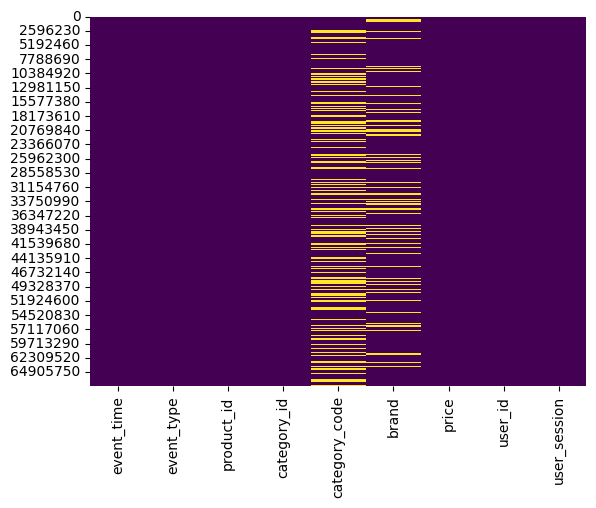

In [ ]:
# Visualize the missing values for November using a heat map
sns.heatmap(data_nov.isna(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
data_oct.isna().sum()

Missing values in the 2019-Oct dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

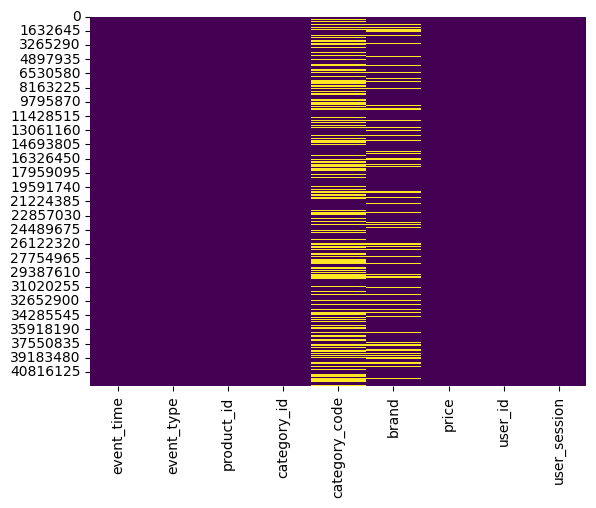

In [ ]:
# Visualize the missing values for October using a heat map
sns.heatmap(data_oct.isna(), cbar=False, cmap='viridis')
plt.show()

# Attempted to use product_id with brand and catagory_code to map unknown brand and category_code with same product_id
Not particularly successful, code needs correcting - we should be able to update the brand and/or category code with the product_id using a dictionary. We will need to decide what to do with the row with neither brand nor category_code - Tom

Mapping brands from category id works well. - Amy
Mapping category code from category id does not work. - Amy

In [ ]:
# SUCCESS
# Create dictionaries of product_id to fill in empty or unknown brand and category_code columns

# Copy the original data to prevent modifying the original datasets
data_oct_copy = data_oct.copy()
data_nov_copy = data_nov.copy()

# Step 1: Create a mapping of category_id to brand, using non-null values for each category_id
brand_mapping_oct = data_oct_copy.dropna(subset=['brand']).groupby('category_id')['brand'].first()
brand_mapping_nov = data_nov_copy.dropna(subset=['brand']).groupby('category_id')['brand'].first()

# Step 2: Use the mappings to fill missing brand values based on category_id in both datasets
data_oct_copy['brand'] = data_oct_copy.apply(
    lambda row: brand_mapping_oct.get(row['category_id'], row['brand']) if pd.isnull(row['brand']) else row['brand'],
    axis=1
)

data_nov_copy['brand'] = data_nov_copy.apply(
    lambda row: brand_mapping_nov.get(row['category_id'], row['brand']) if pd.isnull(row['brand']) else row['brand'],
    axis=1
)

# Check the result (inspect the first few rows to ensure brand is filled)
print(data_oct_copy[['product_id', 'category_id', 'brand']].head())
print(data_nov_copy[['product_id', 'category_id', 'brand']].head())


   product_id          category_id     brand
0    44600062  2103807459595387724  shiseido
1     3900821  2053013552326770905      aqua
2    17200506  2053013559792632471      rals
3     1307067  2053013558920217191    lenovo
4     1004237  2053013555631882655     apple
   product_id          category_id   brand
0     1003461  2053013555631882655  xiaomi
1     5000088  2053013566100866035  janome
2    17302664  2053013553853497655   creed
3     3601530  2053013563810775923      lg
4     1004775  2053013555631882655  xiaomi


In [ ]:
# UNSUCCESSFUL attempt
# Step 1: Create a mapping of category_id to category_code, using non-null values for each category_id
#category_mapping_oct = data_oct_copy.dropna(subset=['category_code']).groupby('category_id')['category_code'].first()
#category_mapping_nov = data_nov_copy.dropna(subset=['category_code']).groupby('category_id')['category_code'].first()

# Step 2: Use the mappings to fill missing category_code values based on category_id in both datasets
#data_oct_copy['category_code'] = data_oct_copy.apply(
#    lambda row: category_mapping_oct.get(row['category_id'], row['category_code']) if pd.isnull(row['category_code']) else row['category_code'],
#    axis=1
#)

#data_nov_copy['category_code'] = data_nov_copy.apply(
#    lambda row: category_mapping_nov.get(row['category_id'], row['category_code']) if pd.isnull(row['category_code']) else row['category_code'],
#    axis=1
#)

# Check the result (inspect the first few rows to ensure category_code is filled)
#print(data_oct_copy[['product_id', 'category_id', 'category_code']].head())
#print(data_nov_copy[['product_id', 'category_id', 'category_code']].head())


   product_id          category_id                        category_code
0    44600062  2103807459595387724                                  NaN
1     3900821  2053013552326770905  appliances.environment.water_heater
2    17200506  2053013559792632471           furniture.living_room.sofa
3     1307067  2053013558920217191                   computers.notebook
4     1004237  2053013555631882655               electronics.smartphone
   product_id          category_id              category_code
0     1003461  2053013555631882655     electronics.smartphone
1     5000088  2053013566100866035  appliances.sewing_machine
2    17302664  2053013553853497655                        NaN
3     3601530  2053013563810775923  appliances.kitchen.washer
4     1004775  2053013555631882655     electronics.smartphone


In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
data_oct_copy.isna().sum()

Missing values in the 2019-Oct dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand               84420
price                   0
user_id                 0
user_session            2
dtype: int64

In [ ]:
print(data_oct_copy['product_id'].head())  # Inspect the product_id column
print(brand_mapping_oct.head())  # Inspect the mapping dictionary


0    44600062
1     3900821
2    17200506
3     1307067
4     1004237
Name: product_id, dtype: int64
category_id
2053013552226107603    willmark
2053013552259662037       bosch
2053013552293216471       midea
2053013552326770905        aqua
2053013552351936731    elenberg
Name: brand, dtype: object


In [ ]:
# Prints November missing values
print("Missing values in the 2019-Nov dataset:")
data_nov_copy.isna().sum()

Missing values in the 2019-Nov dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand               55293
price                   0
user_id                 0
user_session           10
dtype: int64

# Analyze null category codes [Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.] to price. Potentially fill null category codes for accessories, and remove higher priced null categories due to unlikelihood of being an accessory. - Tom

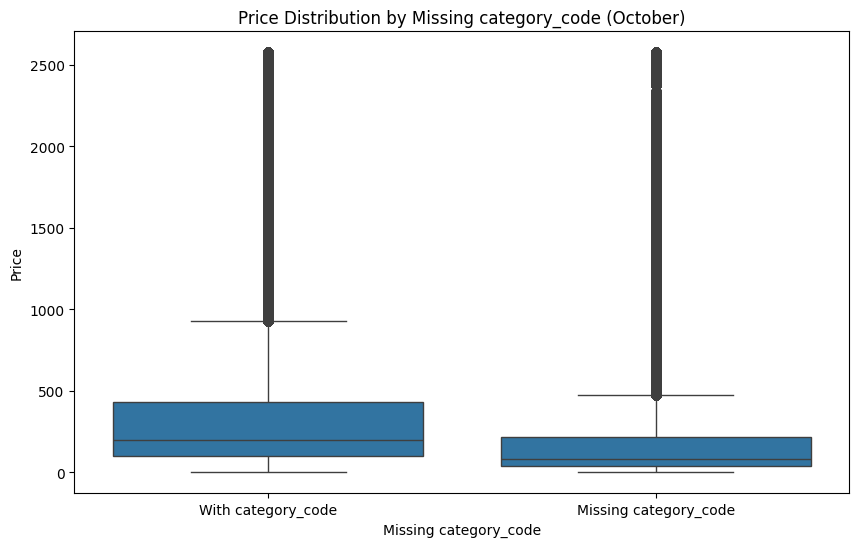

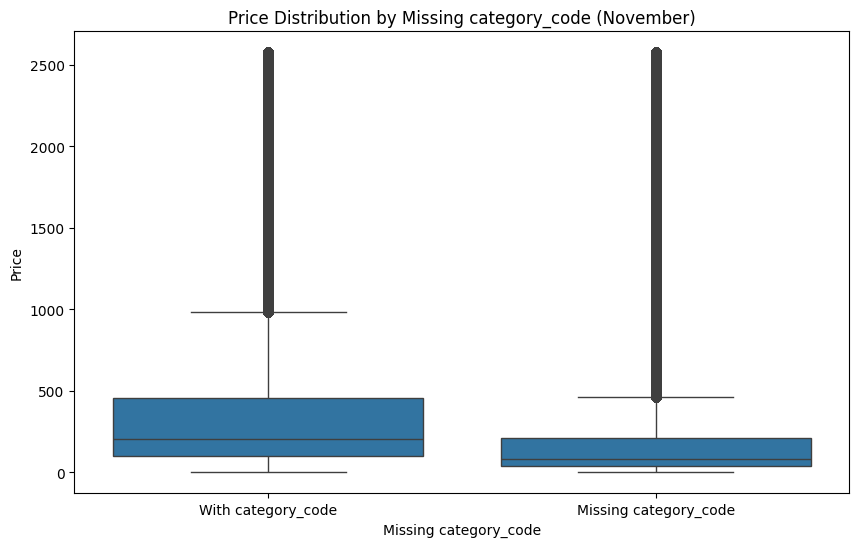

In [ ]:
# Check for missing values in category_code and plot the comparison with price
def plot_missing_category_vs_price(data, dataset_name):
    # Create a new column to indicate if category_code is missing
    data['category_code_missing'] = data['category_code'].isnull()

    # Plot the boxplot for price distribution based on category_code missing or not
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='category_code_missing', y='price', data=data)
    plt.title(f'Price Distribution by Missing category_code ({dataset_name})')
    plt.xlabel('Missing category_code')
    plt.ylabel('Price')
    plt.xticks([0, 1], ['With category_code', 'Missing category_code'])
    plt.show()

# For October dataset
plot_missing_category_vs_price(data_oct_copy, 'October')

# For November dataset
plot_missing_category_vs_price(data_nov_copy, 'November')

# View price distribution of null category_code - Tom

Price distribution for Missing category_code in October dataset:
price_category
Low Price (0-50)        4605203
Mid Price (50-200)      5350893
High Price (200-500)    2536283
Premium Price (500+)    1023230
Name: count, dtype: int64

Price distribution for Missing category_code in November dataset:
price_category
Low Price (0-50)        7428476
Mid Price (50-200)      8743154
High Price (200-500)    4249508
Premium Price (500+)    1477033
Name: count, dtype: int64


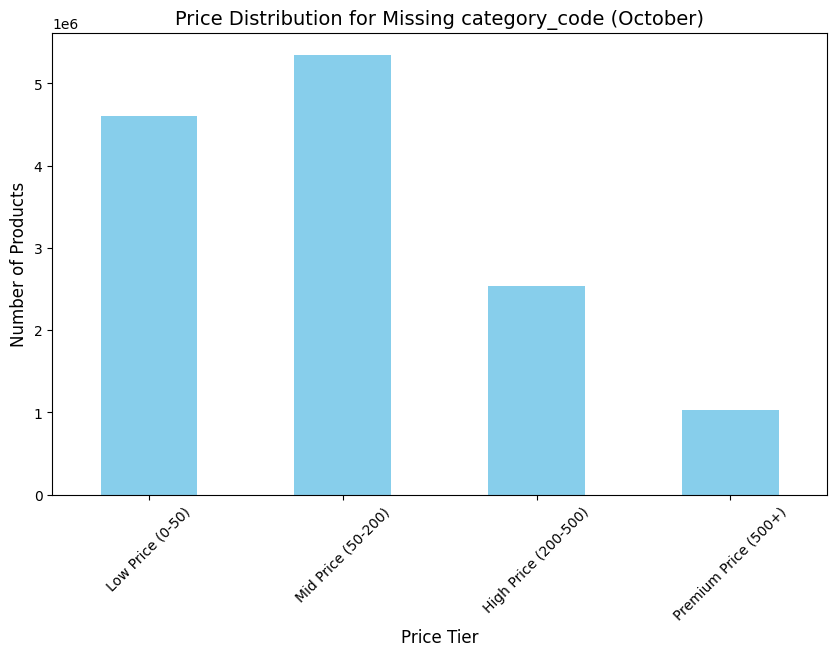

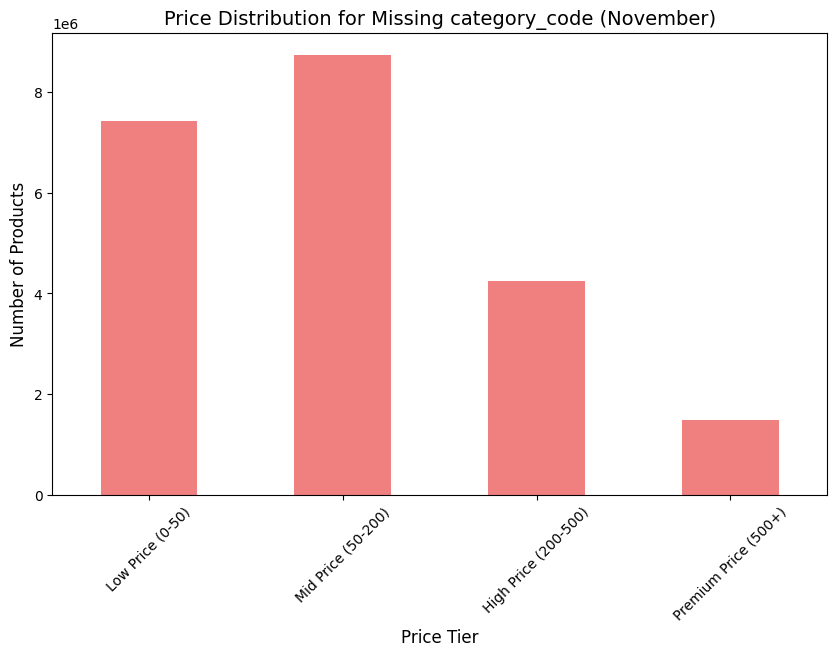

In [ ]:
# Define price bins for categorizing products into price ranges
price_bins = [0, 50, 200, 500, float('inf')]  # Define bins
price_labels = ['Low Price (0-50)', 'Mid Price (50-200)', 'High Price (200-500)', 'Premium Price (500+)']  # Bin labels

# Function to categorize prices into bins
def categorize_price(price):
    if price <= 50:
        return 'Low Price (0-50)'
    elif price <= 200:
        return 'Mid Price (50-200)'
    elif price <= 500:
        return 'High Price (200-500)'
    else:
        return 'Premium Price (500+)'

# Apply the categorize_price function to the dataset
data_oct_copy['price_category'] = data_oct_copy['price'].apply(categorize_price)
data_nov_copy['price_category'] = data_nov_copy['price'].apply(categorize_price)

# Filter the rows where category_code is missing (likely accessories) and get the counts of each price tier
missing_category_oct = data_oct_copy[data_oct_copy['category_code'].isnull()]
missing_category_nov = data_nov_copy[data_nov_copy['category_code'].isnull()]

# Count the number of products in each price category for both October and November datasets
price_counts_oct = missing_category_oct['price_category'].value_counts()
price_counts_nov = missing_category_nov['price_category'].value_counts()

# Reindex the results to ensure the bins are ordered correctly
price_counts_oct = price_counts_oct.reindex(price_labels)
price_counts_nov = price_counts_nov.reindex(price_labels)

# Print the results in lowest to highest price order
print("Price distribution for Missing category_code in October dataset:")
print(price_counts_oct)
print("\nPrice distribution for Missing category_code in November dataset:")
print(price_counts_nov)

# Plot for October
plt.figure(figsize=(10, 6))
price_counts_oct.plot(kind='bar', color='skyblue')
plt.title('Price Distribution for Missing category_code (October)', fontsize=14)
plt.xlabel('Price Tier', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Plot for November
plt.figure(figsize=(10, 6))
price_counts_nov.plot(kind='bar', color='lightcoral')
plt.title('Price Distribution for Missing category_code (November)', fontsize=14)
plt.xlabel('Price Tier', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Fill null values of category_code and brand with unknown_category and unknown_brand - Tom

In [ ]:
# Fill missing values in category_code and brand with 'unknown_category' and 'unknown_brand' respectively
df_fill_oct = data_oct_copy['category_code'].fillna('unknown_category')
df_fill_oct = data_oct_copy['brand'].fillna('unknown_brand')

df_fill_nov = data_nov_copy['category_code'].fillna('unknown_category')
df_fill_nov = data_nov_copy['brand'].fillna('unknown_brand')

# Check the result to ensure the missing values have been filled
print("Missing values after filling in October dataset:")
print(data_oct_copy[['category_code', 'brand']].isnull().sum())

print("\nMissing values after filling in November dataset:")
print(data_nov_copy[['category_code', 'brand']].isnull().sum())

# Optional: Display the first few rows of the updated datasets to confirm
print("\nFirst few rows of the updated October dataset:")
print(data_oct_copy[['product_id', 'category_code', 'brand']].head())

print("\nFirst few rows of the updated November dataset:")
print(data_nov_copy[['product_id', 'category_code', 'brand']].head())

# Amy - Cleaned Data
1. brands filled in from category_id
2. df_fill_oct and df_fill_nov will have rows filled for null brand and category code
3. data_copy_oct and data_copy_nov will have rows removed that have null brand or category code
4. clean_data_copy will have have rows removed for null brand or category code and removed for null user session
5. clean_data_filled will have rows filled for null brand or category code and removed for null user session

## Part 1 - brands filled in from category_id

In [ ]:
# SUCCESS
# Create dictionaries of product_id to fill in empty or unknown brand and category_code columns

# Copy the original data to prevent modifying the original datasets
data_oct_copy = data_oct.copy()
data_nov_copy = data_nov.copy()

# Step 1: Create a mapping of category_id to brand, using non-null values for each category_id
brand_mapping_oct = data_oct_copy.dropna(subset=['brand']).groupby('category_id')['brand'].first()
brand_mapping_nov = data_nov_copy.dropna(subset=['brand']).groupby('category_id')['brand'].first()

# Step 2: Use the mappings to fill missing brand values based on category_id in both datasets
data_oct_copy['brand'] = data_oct_copy.apply(
    lambda row: brand_mapping_oct.get(row['category_id'], row['brand']) if pd.isnull(row['brand']) else row['brand'],
    axis=1
)

data_nov_copy['brand'] = data_nov_copy.apply(
    lambda row: brand_mapping_nov.get(row['category_id'], row['brand']) if pd.isnull(row['brand']) else row['brand'],
    axis=1
)

# Check the result (inspect the first few rows to ensure brand is filled)
print(data_oct_copy[['product_id', 'category_id', 'brand']].head())
print(data_nov_copy[['product_id', 'category_id', 'brand']].head())

   product_id          category_id     brand
0    44600062  2103807459595387724  shiseido
1     3900821  2053013552326770905      aqua
2    17200506  2053013559792632471      rals
3     1307067  2053013558920217191    lenovo
4     1004237  2053013555631882655     apple
   product_id          category_id   brand
0     1003461  2053013555631882655  xiaomi
1     5000088  2053013566100866035  janome
2    17302664  2053013553853497655   creed
3     3601530  2053013563810775923      lg
4     1004775  2053013555631882655  xiaomi


### Check pt. 1

In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
data_oct_copy.isna().sum()

Missing values in the 2019-Oct dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand               84420
price                   0
user_id                 0
user_session            2
dtype: int64

In [ ]:
# Prints October missing values
print("Missing values in the 2019-Nov dataset:")
data_nov_copy.isna().sum()

Missing values in the 2019-Nov dataset:


event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand               55293
price                   0
user_id                 0
user_session           10
dtype: int64

## Part 2 - df_fill_oct and df_fill_nov will have rows filled for null brand and category code

In [ ]:
df_fill_oct = data_oct_copy.fillna({'category_code': 'unknown_category', 'brand': 'unknown_brand'})
df_fill_nov = data_nov_copy.fillna({'category_code': 'unknown_category', 'brand': 'unknown_brand'})

### Check pt. 2

In [ ]:
# Check the result to ensure the missing values have been filled
print("Missing values after filling in October dataset:")
print(df_fill_oct[['category_code', 'brand']].isnull().sum())

print("\nMissing values after filling in November dataset:")
print(df_fill_nov[['category_code', 'brand']].isnull().sum())

# Optional: Display the first few rows of the updated datasets to confirm
print("\nFirst few rows of the updated October dataset:")
print(df_fill_oct[['product_id', 'category_code', 'brand']].head())

print("\nFirst few rows of the updated November dataset:")
print(df_fill_nov[['product_id', 'category_code', 'brand']].head())

Missing values after filling in October dataset:
category_code    0
brand            0
dtype: int64

Missing values after filling in November dataset:
category_code    0
brand            0
dtype: int64

First few rows of the updated October dataset:
   product_id                        category_code     brand
0    44600062                     unknown_category  shiseido
1     3900821  appliances.environment.water_heater      aqua
2    17200506           furniture.living_room.sofa      rals
3     1307067                   computers.notebook    lenovo
4     1004237               electronics.smartphone     apple

First few rows of the updated November dataset:
   product_id              category_code   brand
0     1003461     electronics.smartphone  xiaomi
1     5000088  appliances.sewing_machine  janome
2    17302664           unknown_category   creed
3     3601530  appliances.kitchen.washer      lg
4     1004775     electronics.smartphone  xiaomi


In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
df_fill_oct.isna().sum()

Missing values in the 2019-Oct dataset:


event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     2
dtype: int64

In [ ]:
# Prints November missing values
print("Missing values in the 2019-Nov dataset:")
df_fill_nov.isna().sum()

Missing values in the 2019-Nov dataset:


event_time        0
event_type        0
product_id        0
category_id       0
category_code     0
brand             0
price             0
user_id           0
user_session     10
dtype: int64

## Part 3 - data_copy_oct and data_copy_nov will have rows removed that have null brand or category code

In [ ]:
data_oct_copy = data_oct_copy.dropna(subset=['category_code', 'brand'])
data_nov_copy = data_nov_copy.dropna(subset=['category_code', 'brand'])

## Part 4 - clean_data_copy will have have rows removed for null brand or category code and removed for null user session

In [ ]:
clean_copy_oct = data_oct_copy.dropna(subset=['user_session'])
clean_copy_nov = data_nov_copy.dropna(subset=['user_session'])

## Part 5 - clean_data_filled will have rows filled for null brand or category code and removed for null user session

In [ ]:
clean_filled_oct = df_fill_oct.dropna(subset=['user_session'])
clean_filled_nov = df_fill_nov.dropna(subset=['user_session'])

### check pt.4,5

In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
clean_copy_oct.isna().sum()

Missing values in the 2019-Oct dataset:


event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [ ]:
# Prints November missing values
print("Missing values in the 2019-Nov dataset:")
clean_copy_nov.isna().sum()

Missing values in the 2019-Nov dataset:


event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [ ]:
# Prints October missing values
print("Missing values in the 2019-Oct dataset:")
clean_filled_oct.isna().sum()

Missing values in the 2019-Oct dataset:


event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [ ]:
# Prints November missing values
print("Missing values in the 2019-Nov dataset:")
clean_filled_nov.isna().sum()

Missing values in the 2019-Nov dataset:


event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

### Optional - merging oct and nov datasets

In [ ]:
clean_copy_merge = pd.concat([clean_copy_oct,clean_copy_nov],ignore_index=True,axis=0)
clean_filled_merge = pd.concat([clean_filled_oct,clean_filled_nov],ignore_index=True,axis=0)

In [ ]:
clean_copy_merge.head()

In [ ]:
clean_filled_merge.head()

## Save Copies - note: already saved, check our shared ecommerceDataset folder on your drive

In [ ]:
# Save the updated data_oct_copy DataFrame to a CSV file
clean_copy_oct.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_copy_oct.csv', index=False)
clean_copy_nov.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_copy_nov.csv', index=False)
#clean_copy_merge.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_copy_merge.csv', index=False)

# Save the updated data_nov_copy DataFrame to a CSV file
clean_filled_oct.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv', index=False)
clean_filled_nov.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv', index=False)
#clean_filled_merge.to_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_merge.csv', index=False)

# Vy's attempt to and analyze patterns in user behavior and trends over time.






In [ ]:
# Count unique values for Oct data
unique_values_oct = data_oct.nunique()
print("Unique values count for October data:")
print(unique_values_oct)

# Count unique values for Nov data
unique_values_nov = data_nov.nunique()
print("Unique values count for November data:")
print(unique_values_nov)

Unique values count for October data:
event_time       2621538
event_type             3
product_id        166794
category_id          624
category_code        126
brand               3444
price              65298
user_id          3022290
user_session     9244421
dtype: int64
Unique values count for November data:
event_time        2549559
event_type              3
product_id         190662
category_id           684
category_code         129
brand                4200
price               60435
user_id           3696117
user_session     13776050
dtype: int64





**1.   Compare event type distribution to see if purchasing behavior increased in November**







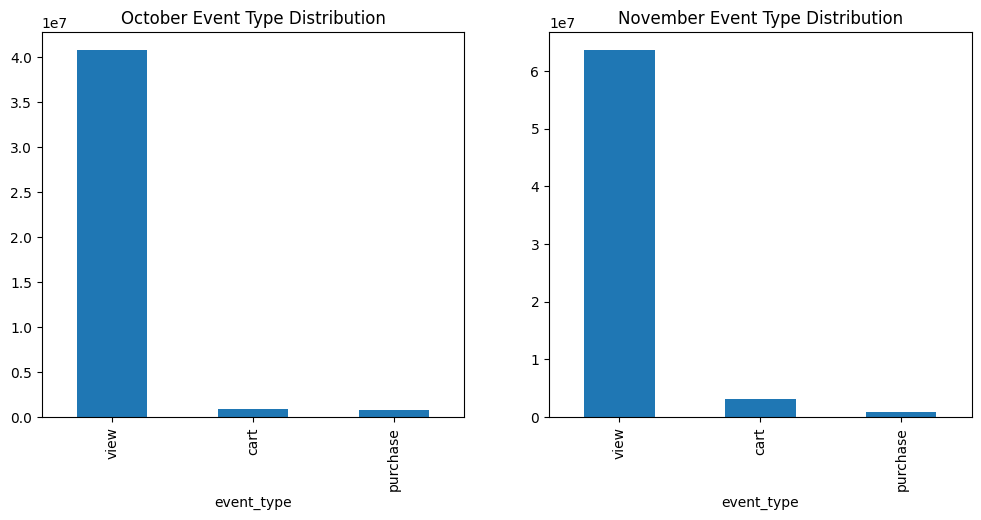

In [ ]:
# Count event type
event_type_counts_oct = data_oct['event_type'].value_counts()
event_type_counts_nov = data_nov['event_type'].value_counts()

# Plot event distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
event_type_counts_oct.plot(kind="bar", ax=ax[0], title="October Event Type Distribution")
event_type_counts_nov.plot(kind="bar", ax=ax[1], title="November Event Type Distribution")

plt.show()


* Both October and November have an huge number of "view" events compared to "cart" and "purchase" events.
* November has more views, cart additions, and purchases than October.
* This could be due to seasonal factors like Black Friday or early holiday shopping.





**2.   Identify Most Popular Products**



In [ ]:
#Top viewed products
top_viewed_oct = data_oct[data_oct["event_type"] == "view"]["product_id"].value_counts().head(10)
top_purchased_oct = data_oct[data_oct["event_type"] == "purchase"]["product_id"].value_counts().head(10)

top_viewed_nov = data_nov[data_nov["event_type"] == "view"]["product_id"].value_counts().head(10)
top_purchased_nov = data_nov[data_nov["event_type"] == "purchase"]["product_id"].value_counts().head(10)

print("Top Viewed Products (Oct):", top_viewed_oct)
print("Top Purchased Products (Oct):", top_purchased_oct)

print("Top Viewed Products (Nov):", top_viewed_nov)
print("Top Purchased Products (Nov):", top_purchased_nov)

Top Viewed Products (Oct): product_id
1004856    419287
1004767    378777
1005115    327715
1004249    207422
1004833    203018
1005105    197930
1004870    190435
1002544    179249
4804056    179092
5100816    164608
Name: count, dtype: int64
Top Purchased Products (Oct): product_id
1004856    28944
1004767    21806
1004833    12697
1005115    12543
4804056    12381
1004870    10615
1002544    10549
1004249     9090
1004836     7691
1005105     7293
Name: count, dtype: int64
Top Viewed Products (Nov): product_id
1005115    583010
1004856    522880
1004767    482898
4804056    318339
1005160    304614
1005105    275721
1004870    272097
1004249    254931
1004833    247446
1002544    229920
Name: count, dtype: int64
Top Purchased Products (Nov): product_id
1004856    32321
1004767    22613
1005115    22244
4804056    17800
1004833    13486
1002544    11678
1004870    10673
1005100    10132
1004249     8881
1005105     8483
Name: count, dtype: int64




*  Check with products have higher conversion rate
*  Check if Nov generates more purchases



In [ ]:
#Top viewed and purchased catogories
top_viewed_oct = data_oct[data_oct["event_type"] == "view"]["category_code"].value_counts().head(10)
top_purchased_oct = data_oct[data_oct["event_type"] == "purchase"]["category_code"].value_counts().head(10)

top_viewed_nov = data_nov[data_nov["event_type"] == "view"]["category_code"].value_counts().head(10)
top_purchased_nov = data_nov[data_nov["event_type"] == "purchase"]["category_code"].value_counts().head(10)

print("Top Viewed Products (Oct):", top_viewed_oct)
print("Top Purchased Products (Oct):", top_purchased_oct)

print("Top Viewed Products (Nov):", top_viewed_nov)
print("Top Purchased Products (Nov):", top_purchased_nov)

Top Viewed Products (Oct): category_code
electronics.smartphone              10619448
electronics.clocks                   1272783
computers.notebook                   1106406
electronics.video.tv                 1055961
electronics.audio.headphone          1018542
appliances.kitchen.refrigerators      863411
appliances.kitchen.washer             831279
appliances.environment.vacuum         772029
apparel.shoes                         759646
auto.accessories.player               464272
Name: count, dtype: int64
Top Purchased Products (Oct): category_code
electronics.smartphone              338018
electronics.audio.headphone          30503
electronics.video.tv                 21565
electronics.clocks                   17906
appliances.kitchen.washer            16148
computers.notebook                   15590
appliances.environment.vacuum        12378
appliances.kitchen.refrigerators     11218
electronics.tablet                    5603
auto.accessories.player               4647
Name: cou



*   Smartphones are the top product that are viewed and purchased the most within Oct. and Nov.
*   Following are more electronics products like notebooks, headphones




**3. Calculate the conversion rates (the amount of products purchased compared to the amount of products viewed)**

In [ ]:
#Conversion rates
conversion_rate_oct = (top_purchased_oct / top_viewed_oct) * 100
conversion_rate_nov = (top_purchased_nov / top_viewed_nov) * 100

print("Conversion Rates (Oct):", conversion_rate_oct)
print("Conversion Rates (Nov):", conversion_rate_nov)

Conversion Rates (Oct): category_code
apparel.shoes                            NaN
appliances.environment.vacuum       1.603308
appliances.kitchen.refrigerators    1.299265
appliances.kitchen.washer           1.942549
auto.accessories.player             1.000922
computers.notebook                  1.409067
electronics.audio.headphone         2.994771
electronics.clocks                  1.406838
electronics.smartphone              3.183009
electronics.tablet                       NaN
electronics.video.tv                2.042216
Name: count, dtype: float64
Conversion Rates (Nov): category_code
apparel.shoes                       0.552084
appliances.environment.vacuum       1.259006
appliances.kitchen.refrigerators    0.957550
appliances.kitchen.washer           1.504939
computers.desktop                        NaN
computers.notebook                  0.876500
electronics.audio.headphone         2.482446
electronics.clocks                  1.165089
electronics.smartphone              2.579



*  Smartphone has the highest conversion rate among all products in Oct.
*   In Nov. Smartphone again generates the highest conversion, however it's not as high as Oct's (reasoning?)




#Priya's Attempt to remove Null values


##As we got confirmation to omit Null values, I will attempt to create a data set by omiting Null values in both Oct and Nov Datsets

In [ ]:
#Creating duplicate data frames for testing
Nov_omitting_nulls =data_nov.copy()
Oct_omitting_nulls =data_oct.copy()

In [ ]:
#data with no null values
Nov_omitting_nulls = Nov_omitting_nulls.dropna()
Oct_omitting_nulls = Oct_omitting_nulls.dropna()

In [ ]:
#checking the column names to see the posibility of merging the Oct and Nov Datasets
Nov_omitting_nulls.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [ ]:
Oct_omitting_nulls.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [ ]:
# Check if column names are the same in both dataframes
if list(Nov_omitting_nulls.columns) == list(Oct_omitting_nulls.columns):
    print("Column names match. Proceeding with appending the dataframes.")

    # Append both dataframes (combine them)
    combined_df = pd.concat([Nov_omitting_nulls, Oct_omitting_nulls], ignore_index=True)

    # Count the number of rows in the combined dataframe
    total_rows = len(combined_df)
    print(f"Total number of rows after appending: {total_rows}")

    # Randomly select 10% of the data for test data
    test_data = combined_df.sample(frac=0.1, random_state=42)  # random_state ensures reproducibility

    # Display the number of rows in test data
    print(f"Number of rows in test data: {len(test_data)}")

else:
    print("Column names do not match. Cannot append dataframes.")


Column names match. Proceeding with appending the dataframes.
Total number of rows after appending: 68650184
Number of rows in test data: 6865018


In [ ]:
test_data.head()

event_time event_type  product_id          category_id  \
57969368  2019-10-19 10:18:53 UTC       view     1004872  2053013555631882655   
40899689  2019-11-29 19:32:27 UTC       view   100018487  2053013558920217191   
29528260  2019-11-18 17:25:32 UTC       view     1004190  2053013555631882655   
51816799  2019-10-13 02:03:03 UTC       view     1801512  2053013554415534427   
54120486  2019-10-15 09:40:39 UTC       view    14300244  2053013557603205653   

                                category_code    brand   price    user_id  \
57969368               electronics.smartphone  samsung  286.43  514616418   
40899689                   computers.notebook     asus  587.15  514150152   
29528260               electronics.smartphone   xiaomi  185.33  550887205   
51816799                 electronics.video.tv    haier  900.90  513463965   
54120486  electronics.audio.music_tools.piano   alesis   67.76  516067450   

                                  user_session  
57969368  a71db662-17b8-4c92-b9fe-55d262dcc715  
40899689  fa296d6d-b718-4bda-8677-76b40041c6c4  
29528260  875ae5ea-699c-4b51-ac0d-bfe602cb1769  
51816799  a8f763bb-b196-41ea-ba09-fce1b1650aa6  
54120486  69bd7422-5bf7-4f99-8966-d5ea67c7637d

In [ ]:
# Display basic info
print(test_data.info())

# Check for missing values
print("Missing values per column:\n", test_data.isnull().sum())

# Summary statistics
print("Summary statistics:\n", test_data.describe)

<class 'pandas.core.frame.DataFrame'>
Index: 6865018 entries, 57969368 to 57796140
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 523.8+ MB
None
Missing values per column:
 event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64
Summary statistics:
 <bound method NDFrame.describe of                        event_time event_type  product_id          category_id  \
57969368  2019-10-19 10:18:53 UTC       view     1004872  2053013555631882655   
40899689  2019-11-29 19:32:27 UTC       view   100018487  2053013558920217191  

<ipython-input-13-1060ff5cb1a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='event_type', order=test_data['event_type'].value_counts().index, palette="viridis")


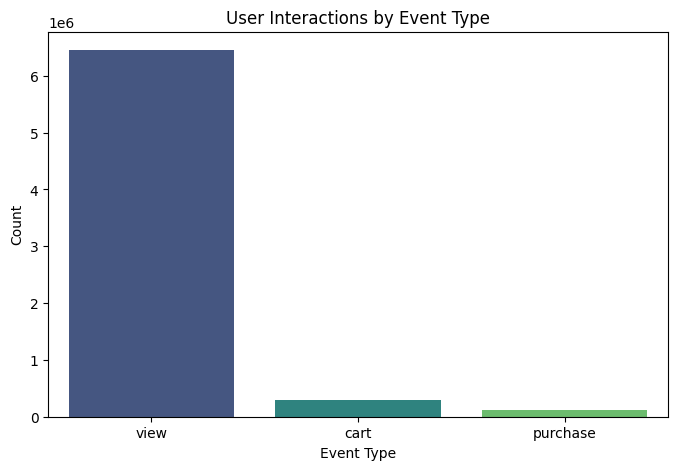

In [ ]:
# Count event types (browsing, adding to cart, purchasing)
plt.figure(figsize=(8,5))
sns.countplot(data=test_data, x='event_type', order=test_data['event_type'].value_counts().index, palette="viridis")
plt.title("User Interactions by Event Type")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

<ipython-input-14-5cf8a2e0ffad>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette="magma")


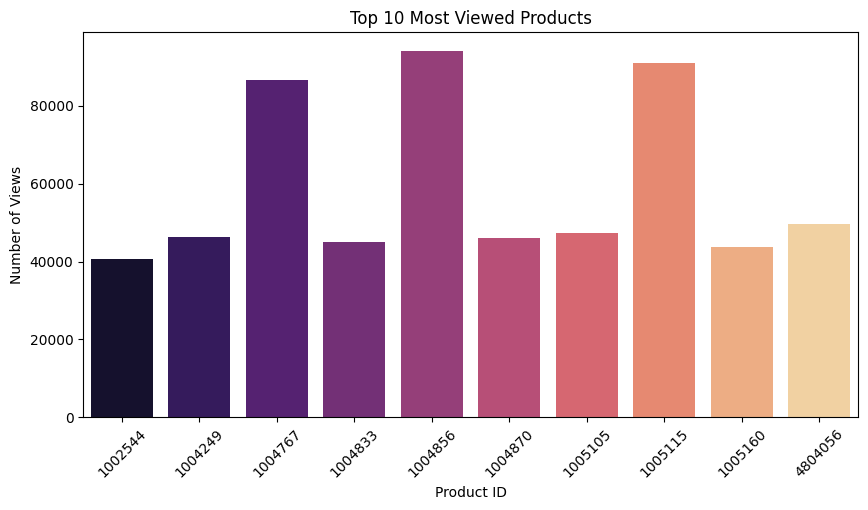

In [ ]:
# Top 10 most browsed products
top_products = test_data[test_data['event_type'] == 'view']['product_id'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values, palette="magma")
plt.title("Top 10 Most Viewed Products")
plt.xlabel("Product ID")
plt.ylabel("Number of Views")
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-53628e417468>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette="coolwarm")


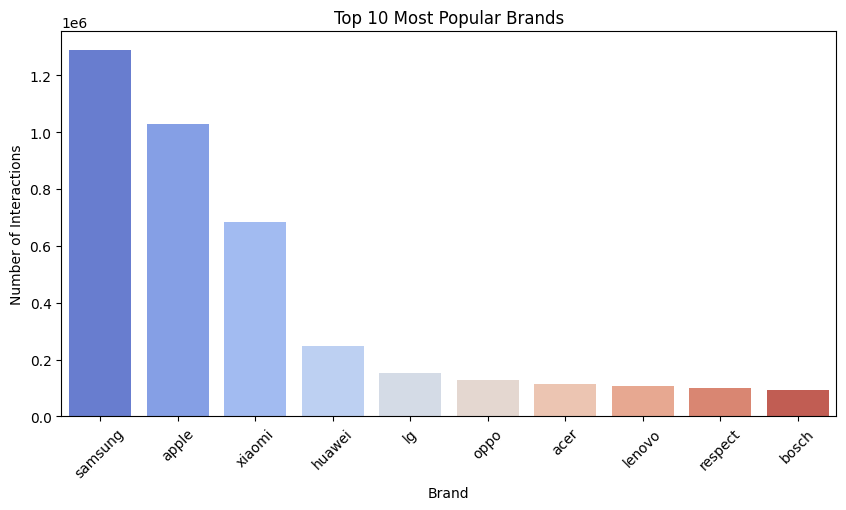

In [ ]:
# Top brands by interactions
top_brands = test_data['brand'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_brands.index, y=top_brands.values, palette="coolwarm")
plt.title("Top 10 Most Popular Brands")
plt.xlabel("Brand")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)
plt.show()

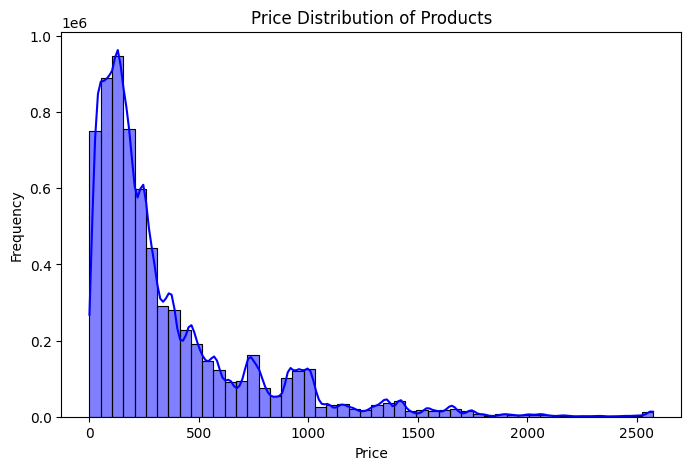

In [ ]:
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(test_data['price'], bins=50, kde=True, color='blue')
plt.title("Price Distribution of Products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Number of unique users
print(f"Total unique users: {test_data['user_id'].nunique()}")

Total unique users: 2010067


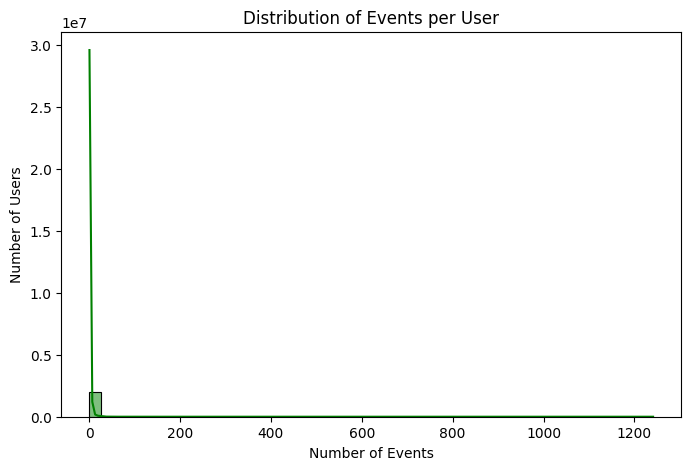

In [ ]:
# Average number of events per user
events_per_user = test_data['user_id'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(events_per_user, bins=50, kde=True, color='green')
plt.title("Distribution of Events per User")
plt.xlabel("Number of Events")
plt.ylabel("Number of Users")
plt.show()

Total unique sessions: 4640171


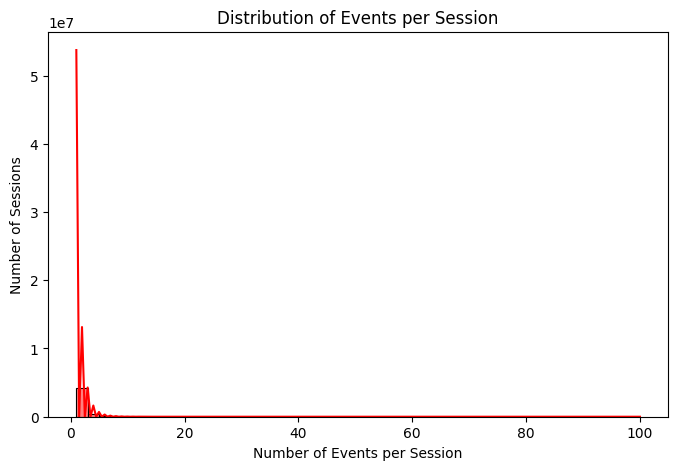

In [ ]:
# User session analysis
session_counts = test_data['user_session'].value_counts()
print(f"Total unique sessions: {len(session_counts)}")
plt.figure(figsize=(8,5))
sns.histplot(session_counts, bins=50, kde=True, color='red')
plt.title("Distribution of Events per Session")
plt.xlabel("Number of Events per Session")
plt.ylabel("Number of Sessions")
plt.show()

# Model training

# Unused clean dataset, filled dataset includes accessories and a large amount of objects click and purchased by users

In [ ]:
# Combine datasets for comprehensive analysis
#df_clean_combined = pd.concat([df_clean_oct, df_clean_nov]).reset_index(drop=True)

# Make sure event_time is in datetime format
#df_clean_combined['event_time'] = pd.to_datetime(df_clean_combined['event_time'])

## Cleaned Data that has been processed - Tom

In [ ]:
# Load the datasets with null values removed
#df_clean_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_copy_oct.csv')
#df_clean_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_copy_nov.csv')

# Preview the data
#print("October clean dataset shape:", df_clean_oct.shape)
#print("November clean dataset shape:", df_clean_nov.shape)

# Check the first few rows of each dataset
#print("\nOctober clean dataset preview:")
#print(df_clean_oct.head())

#print("\nNovember clean dataset preview:")
#print(df_clean_nov.head())

# Check data types and missing values
#print("\nOctober clean dataset info:")
#print(df_clean_oct.info())

#print("\nNovember clean dataset info:")
#print(df_clean_nov.info())

October clean dataset shape: (28907839, 9)
November clean dataset shape: (45579999, 9)

October clean dataset preview:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
1  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
2  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
3  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
4  2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   

                         category_code   brand    price    user_id  \
0  appliances.environment.water_heater    aqua    33.20  554748717   
1           furniture.living_room.sofa    rals   543.10  519107250   
2                   computers.notebook  lenovo   251.74  550050854   
3               electronics.smartphone   apple  1081.98  535871217   
4                    computers.desktop  pulser   908.62  512742880   

               

# User behavior analysis of unused clean data - Tom

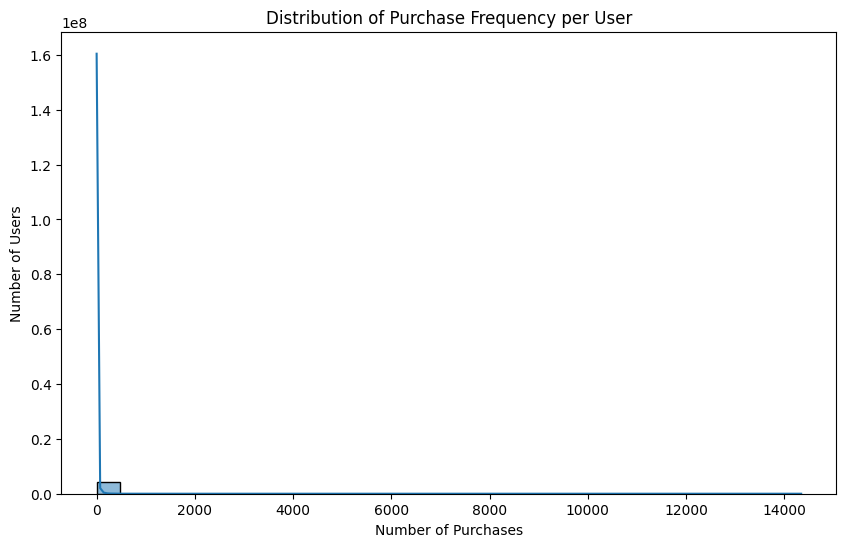

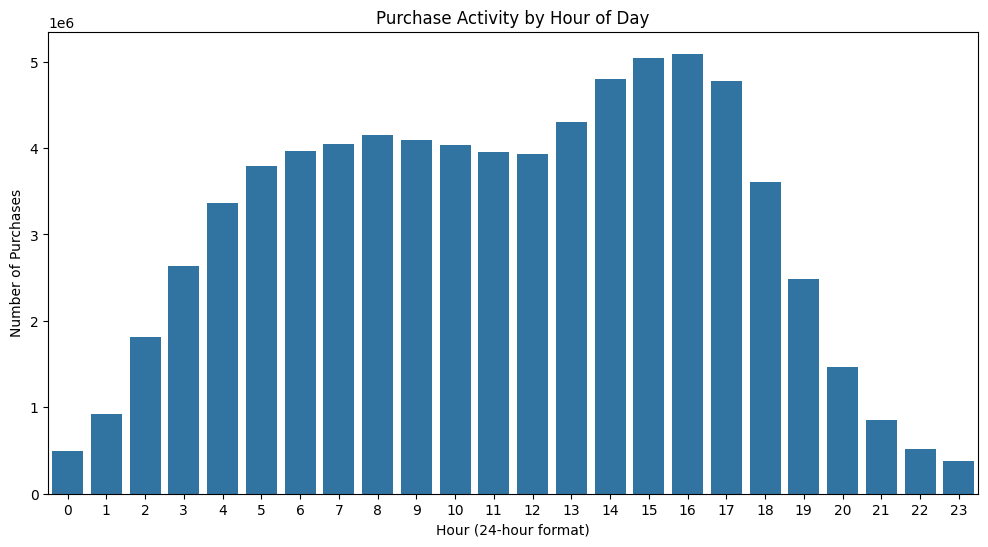

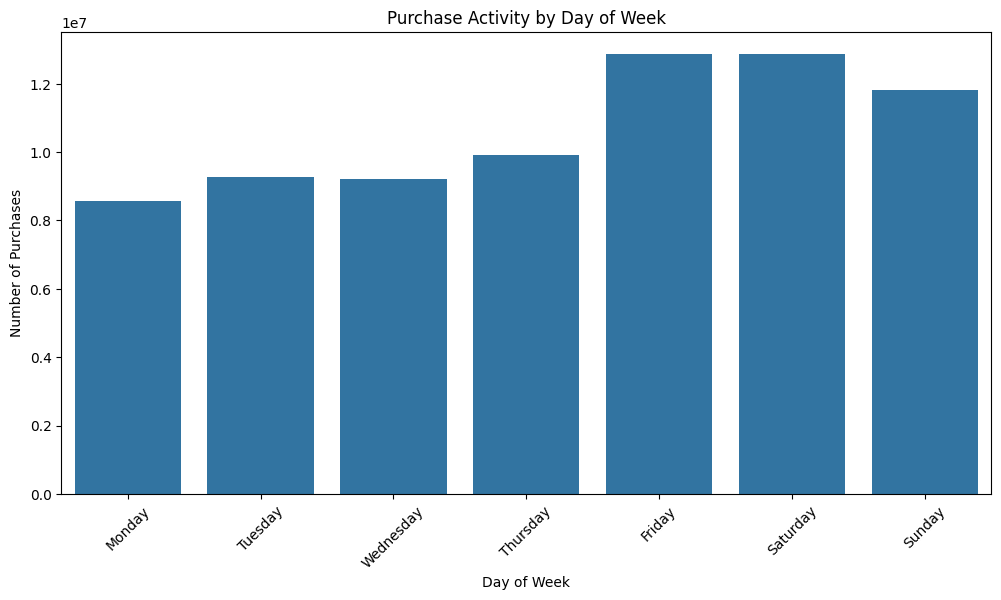

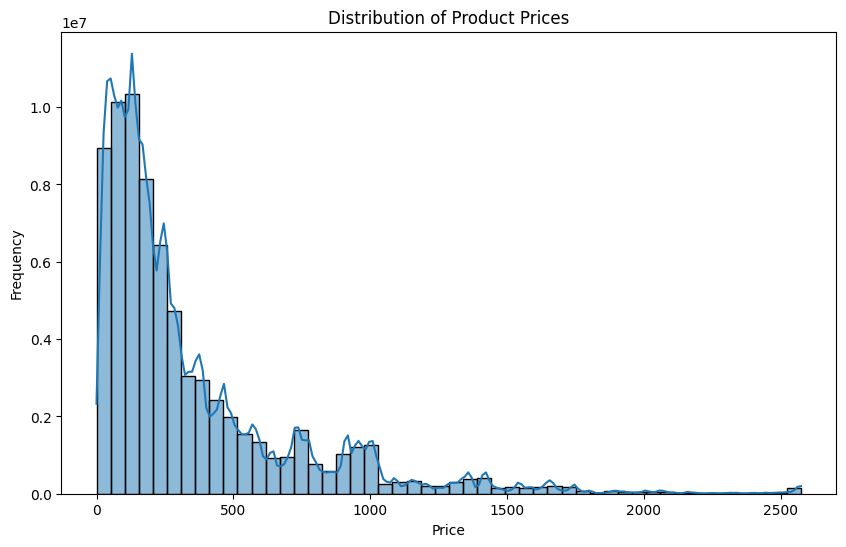

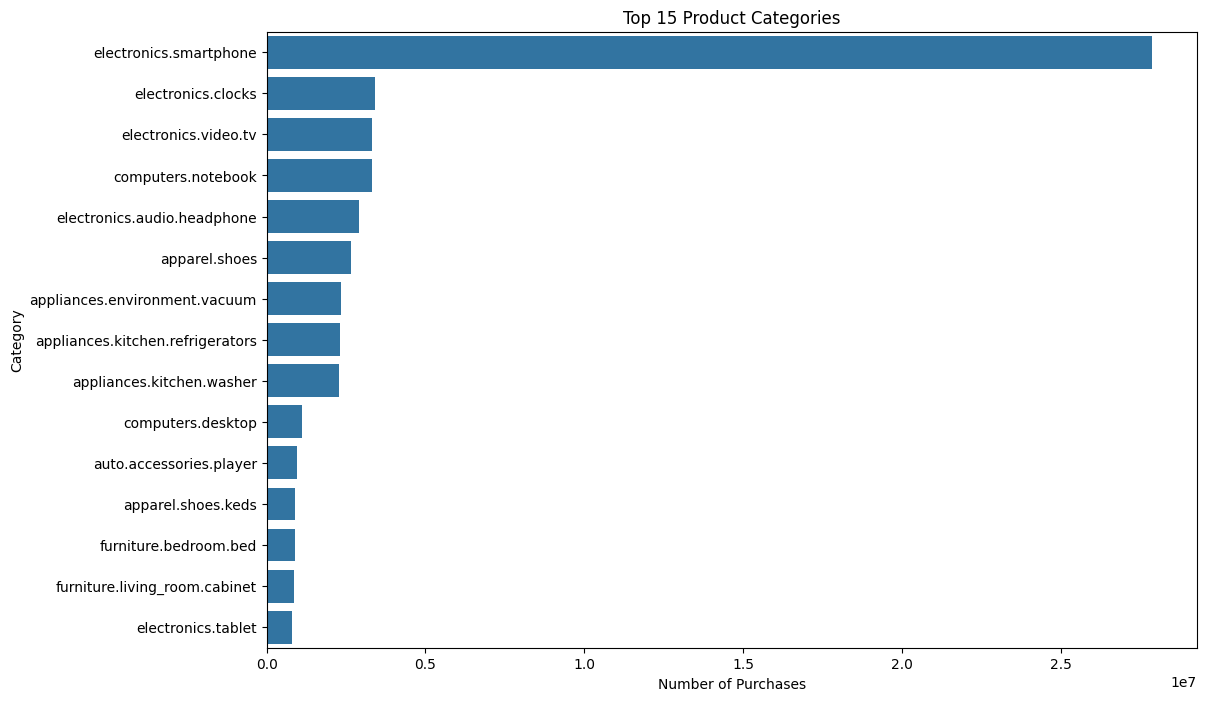

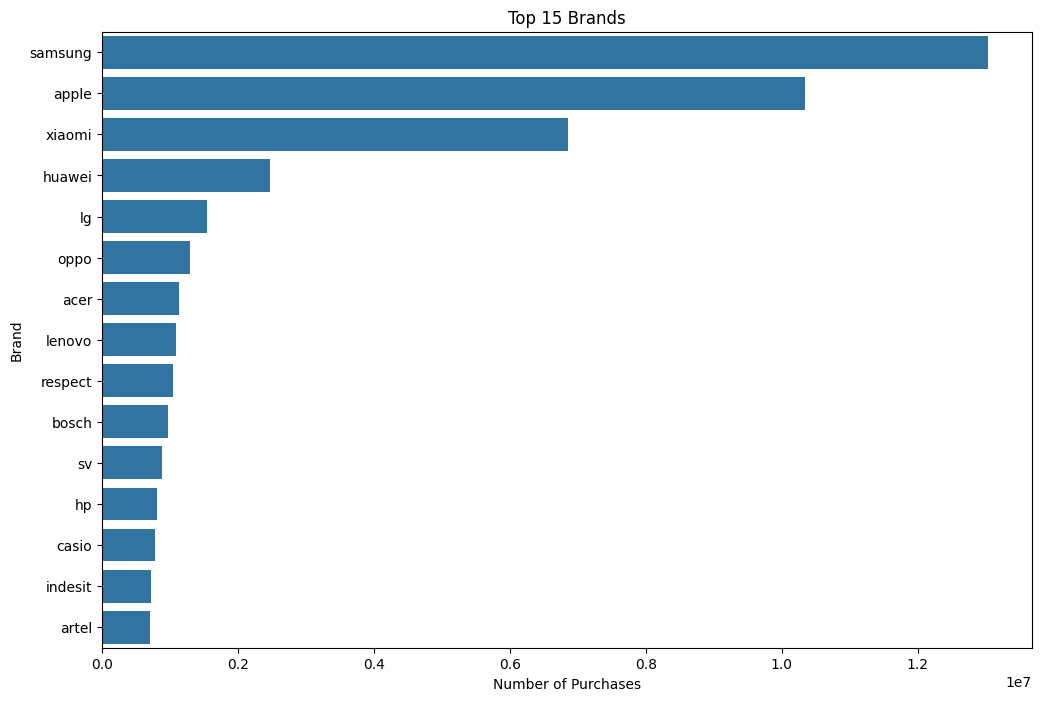

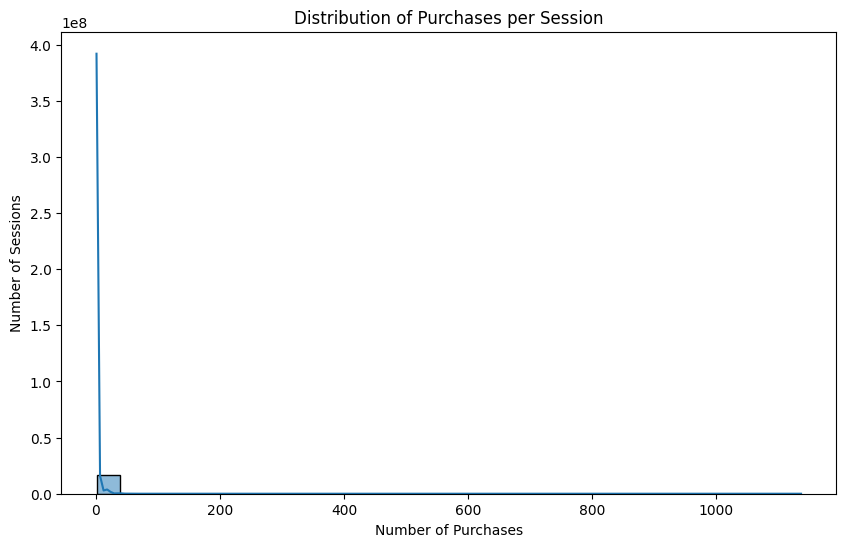

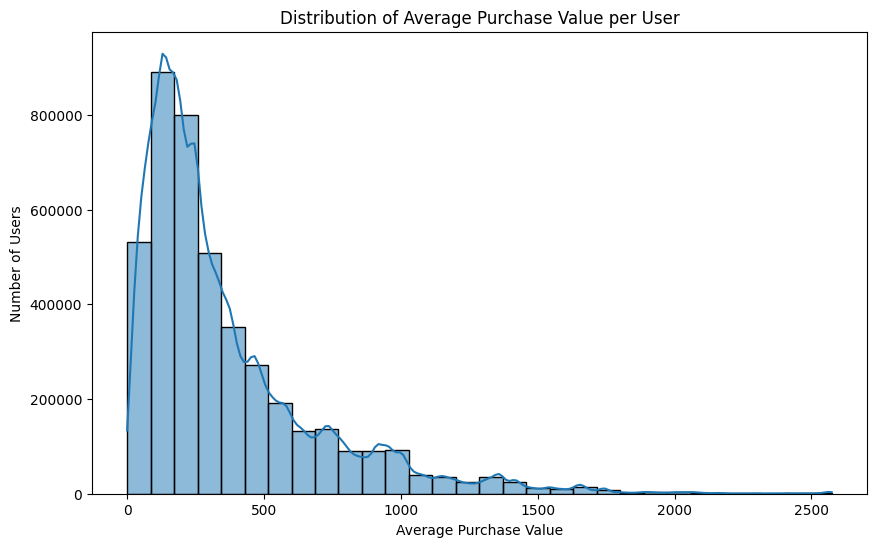

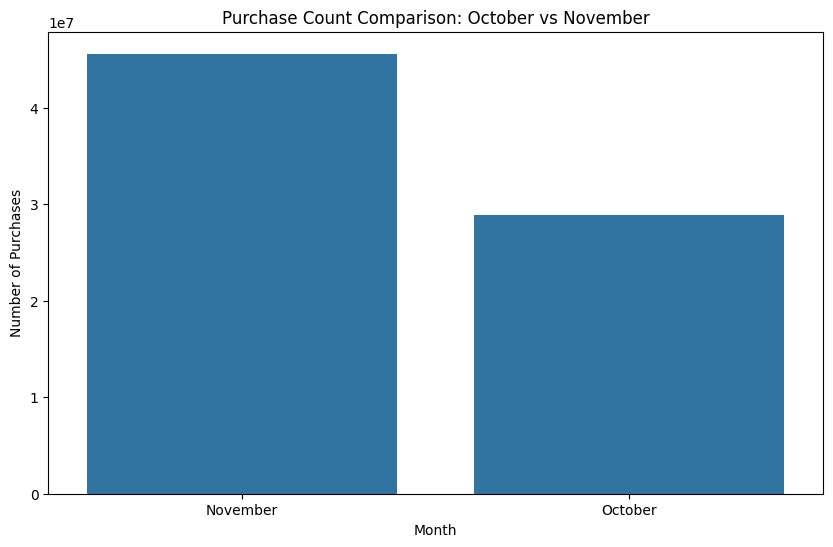

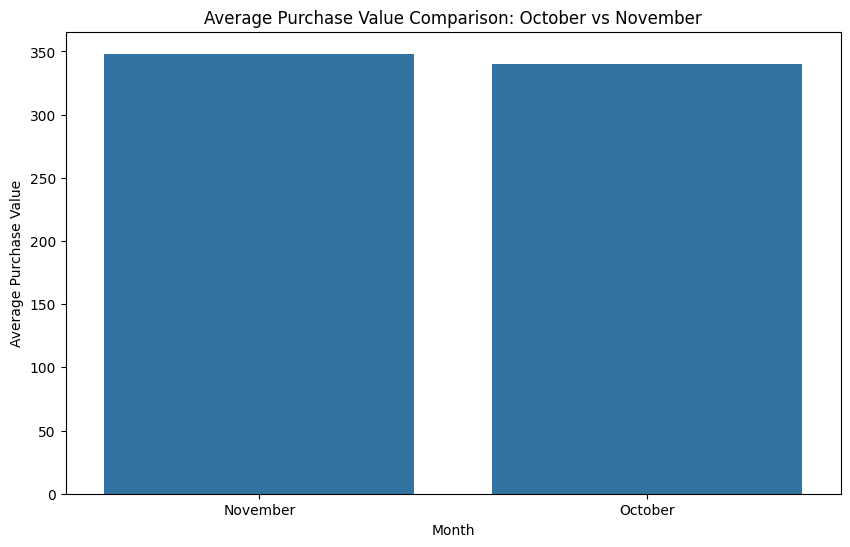

In [ ]:
# Combine datasets for comprehensive analysis
df_clean_combined = pd.concat([df_clean_oct, df_clean_nov]).reset_index(drop=True)

# Make sure event_time is in datetime format
df_clean_combined['event_time'] = pd.to_datetime(df_clean_combined['event_time'])

# Extract time components
df_clean_combined['hour'] = df_clean_combined['event_time'].dt.hour
df_clean_combined['day_of_week'] = df_clean_combined['event_time'].dt.dayofweek
df_clean_combined['day_name'] = df_clean_combined['event_time'].dt.day_name()
df_clean_combined['month'] = df_clean_combined['event_time'].dt.month
df_clean_combined['month_name'] = df_clean_combined['event_time'].dt.month_name()

# 1. Purchase Frequency Analysis
# Count number of purchases per user
user_purchase_counts = df_clean_combined.groupby('user_id').size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(user_purchase_counts['purchase_count'], bins=30, kde=True)
plt.title('Distribution of Purchase Frequency per User')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Users')
plt.show()

# 2. Time Analysis
# Analyze purchases by hour of day
hourly_purchases = df_clean_combined.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=hourly_purchases)
plt.title('Purchase Activity by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Purchases')
plt.xticks(range(0, 24))
plt.show()

# Analyze purchases by day of week
weekly_purchases = df_clean_combined.groupby(['day_of_week', 'day_name']).size().reset_index(name='count')
weekly_purchases = weekly_purchases.sort_values('day_of_week')

plt.figure(figsize=(12, 6))
sns.barplot(x='day_name', y='count', data=weekly_purchases, order=weekly_purchases['day_name'])
plt.title('Purchase Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.show()

# 3. Price Analysis
# Analyze average purchase price
plt.figure(figsize=(10, 6))
sns.histplot(df_clean_combined['price'], bins=50, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 4. Category Analysis
# Analyze most popular categories
top_categories = df_clean_combined['category_code'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_categories.index, x=top_categories.values)
plt.title('Top 15 Product Categories')
plt.xlabel('Number of Purchases')
plt.ylabel('Category')
plt.show()

# 5. Brand Analysis
# Analyze most popular brands
top_brands = df_clean_combined['brand'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_brands.index, x=top_brands.values)
plt.title('Top 15 Brands')
plt.xlabel('Number of Purchases')
plt.ylabel('Brand')
plt.show()

# 6. User Session Analysis
# Check number of purchases per session
session_purchase_counts = df_clean_combined.groupby('user_session').size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(session_purchase_counts['purchase_count'], bins=30, kde=True)
plt.title('Distribution of Purchases per Session')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Sessions')
plt.show()

# 7. Average Purchase Value per User
avg_purchase_per_user = df_clean_combined.groupby('user_id')['price'].mean().reset_index(name='avg_purchase_value')

plt.figure(figsize=(10, 6))
sns.histplot(avg_purchase_per_user['avg_purchase_value'], bins=30, kde=True)
plt.title('Distribution of Average Purchase Value per User')
plt.xlabel('Average Purchase Value')
plt.ylabel('Number of Users')
plt.show()

# 8. Comparison between October and November
# Monthly purchase count comparison
monthly_counts = df_clean_combined.groupby('month_name').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='count', data=monthly_counts)
plt.title('Purchase Count Comparison: October vs November')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()

# Monthly average purchase value comparison
monthly_avg_purchase = df_clean_combined.groupby('month_name')['price'].mean().reset_index(name='avg_price')

plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='avg_price', data=monthly_avg_purchase)
plt.title('Average Purchase Value Comparison: October vs November')
plt.xlabel('Month')
plt.ylabel('Average Purchase Value')
plt.show()

Product affinity analysis - Tom

In [ ]:
# 1. Create a transaction dataset
# Group by user_session to identify products purchased in the same session
transactions = df_clean_combined.groupby(['user_session', 'product_id'])['event_time'].count().reset_index()
transactions = transactions.groupby('user_session')['product_id'].apply(list).reset_index()

print(f"Total number of transactions: {len(transactions)}")
print(f"Sample of the first 5 transactions:")
for i, t in enumerate(transactions['product_id'][:5]):
    print(f"Transaction {i+1}: {len(t)} products")

# 2. Find most common product pairs
product_pairs = []
for products in transactions['product_id']:
    if len(products) >= 2:  # Only consider transactions with at least 2 products
        # Create all possible pairs of products
        pairs = [(a, b) for idx, a in enumerate(products) for b in products[idx + 1:]]
        product_pairs.extend(pairs)

# Count frequency of each pair
pair_counts = Counter(product_pairs)
most_common_pairs = pair_counts.most_common(20)  # Get top 20 most common pairs

print("\nTop 20 most frequently purchased product pairs:")
for pair, count in most_common_pairs:
    print(f"Products {pair[0]} and {pair[1]} were purchased together {count} times")

# 3. Create one-hot encoded transaction data for association rules mining
# Convert list of transactions to one-hot encoded format
te = TransactionEncoder()
te_data = te.fit_transform(transactions['product_id'])
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

# 4. Run Apriori algorithm to find frequent itemsets
# Start with a lower min_support and adjust as needed
min_support = 0.01  # Products that appear in at least 1% of transactions
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
print(f"\nNumber of frequent itemsets found: {len(frequent_itemsets)}")

# 5. Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print(f"Number of rules generated: {len(rules)}")

# Sort rules by lift (a measure of importance of the rule)
rules = rules.sort_values('lift', ascending=False)

# Display top 10 rules by lift
print("\nTop 10 association rules by lift:")
pd.set_option('display.max_columns', None)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# 6. Create a product affinity network visualization
# Use top 50 rules for visualization
top_rules = rules.head(50)

# Create a network graph
G = nx.Graph()

# Add edges for each rule
for i, row in top_rules.iterrows():
    # Convert frozensets to lists
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    # Add all possible pairs between antecedents and consequents
    for a in antecedents:
        for c in consequents:
            # Add nodes if they don't exist
            if not G.has_node(a):
                G.add_node(a)
            if not G.has_node(c):
                G.add_node(c)

            # Add edge with lift as weight
            if G.has_edge(a, c):
                # If edge exists, update weight to maximum of current and new lift
                G[a][c]['weight'] = max(G[a][c]['weight'], row['lift'])
            else:
                G.add_edge(a, c, weight=row['lift'])

# Draw the network
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using force-directed layout

# Edge weights for thickness
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
weights_normalized = [w/max(weights)*10 for w in weights]  # Normalize for better visualization

nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Product Affinity Network", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Category-level affinity analysis
# First, create a mapping from product_id to category_code
product_category_map = df_clean_combined[['product_id', 'category_code']].drop_duplicates().set_index('product_id')['category_code'].to_dict()

# Convert product transactions to category transactions
category_transactions = []
for prod_list in transactions['product_id']:
    # Convert each product to its category and remove duplicates (to avoid counting same category multiple times)
    categories = list(set([product_category_map.get(prod, 'unknown') for prod in prod_list]))
    category_transactions.append(categories)

# Encode category transactions
te_cat = TransactionEncoder()
te_cat_data = te_cat.fit_transform(category_transactions)
df_cat_encoded = pd.DataFrame(te_cat_data, columns=te_cat.columns_)

# Find frequent category itemsets
cat_frequent_itemsets = apriori(df_cat_encoded, min_support=0.02, use_colnames=True)

# Generate category association rules
cat_rules = association_rules(cat_frequent_itemsets, metric="lift", min_threshold=1.0)
cat_rules = cat_rules.sort_values('lift', ascending=False)

print("\nTop 10 category association rules by lift:")
print(cat_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# 8. Save the results for future use in recommendation systems
top_rules.to_csv('/content/drive/MyDrive/ecommerceDataset/product_association_rules.csv', index=False)
cat_rules.to_csv('/content/drive/MyDrive/ecommerceDataset/category_association_rules.csv', index=False)

NameError: name 'df_clean_combined' is not defined

# Filled null value preprocessed dataset to load in data for training- Tom

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the datasets with filled null values
df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')
df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')

# Preview the data
print("October filled dataset shape:", df_filled_oct.shape)
print("November filled dataset shape:", df_filled_nov.shape)

# Check the first few rows of each dataset
print("\nOctober filled dataset preview:")
print(df_filled_oct.head())
print(df_filled_oct.shape)

print("\nNovember filled dataset preview:")
print(df_filled_nov.head())
print(df_filled_nov.shape)

# Check data types and missing values
print("\nOctober filled dataset info:")
print(df_filled_oct.info())

print("\nNovember filled dataset info:")
print(df_filled_nov.info())

October filled dataset shape: (42448762, 9)
November filled dataset shape: (67501969, 9)

October filled dataset preview:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                     unknown_category  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa      rals   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   



## User behavior analysis - Tom

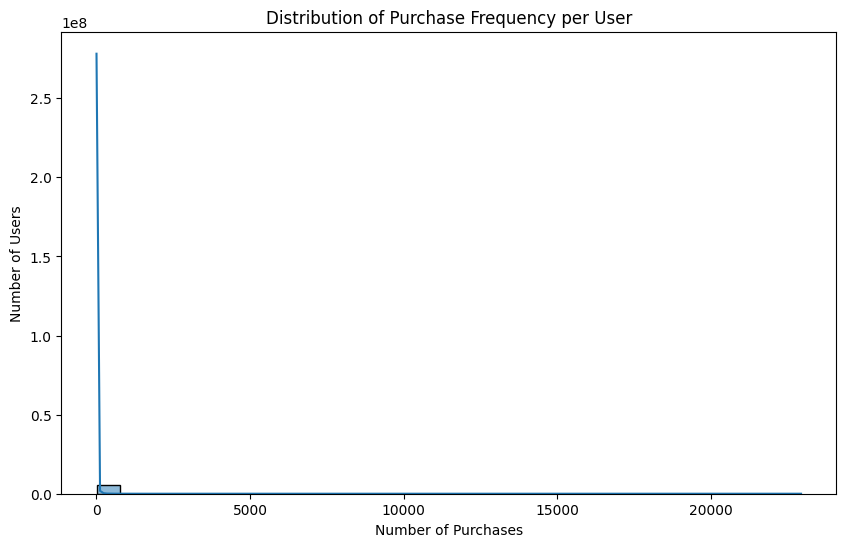

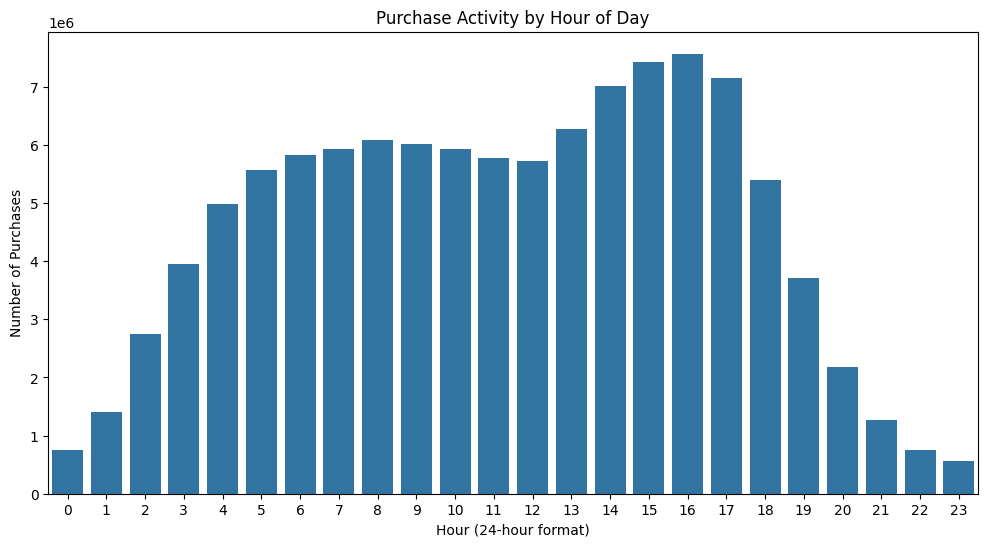

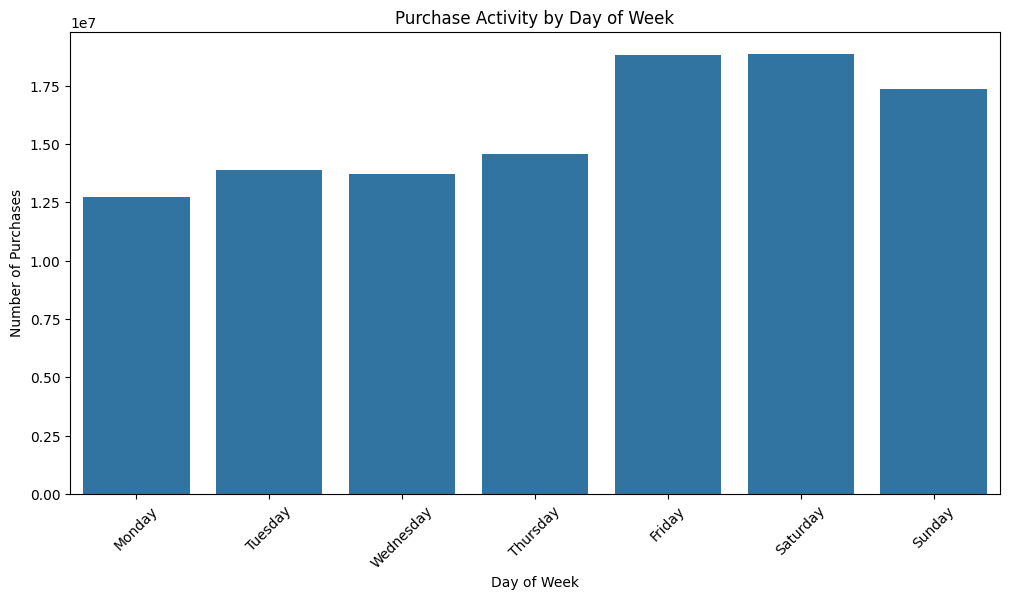

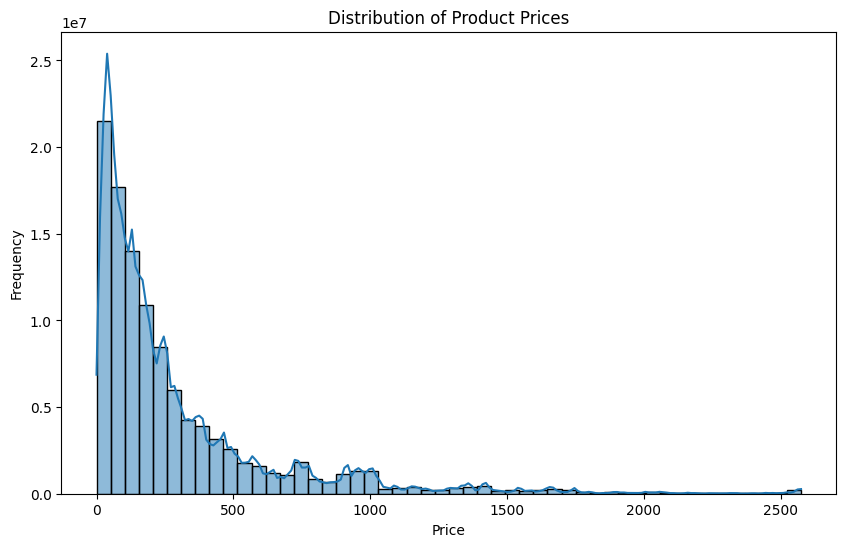

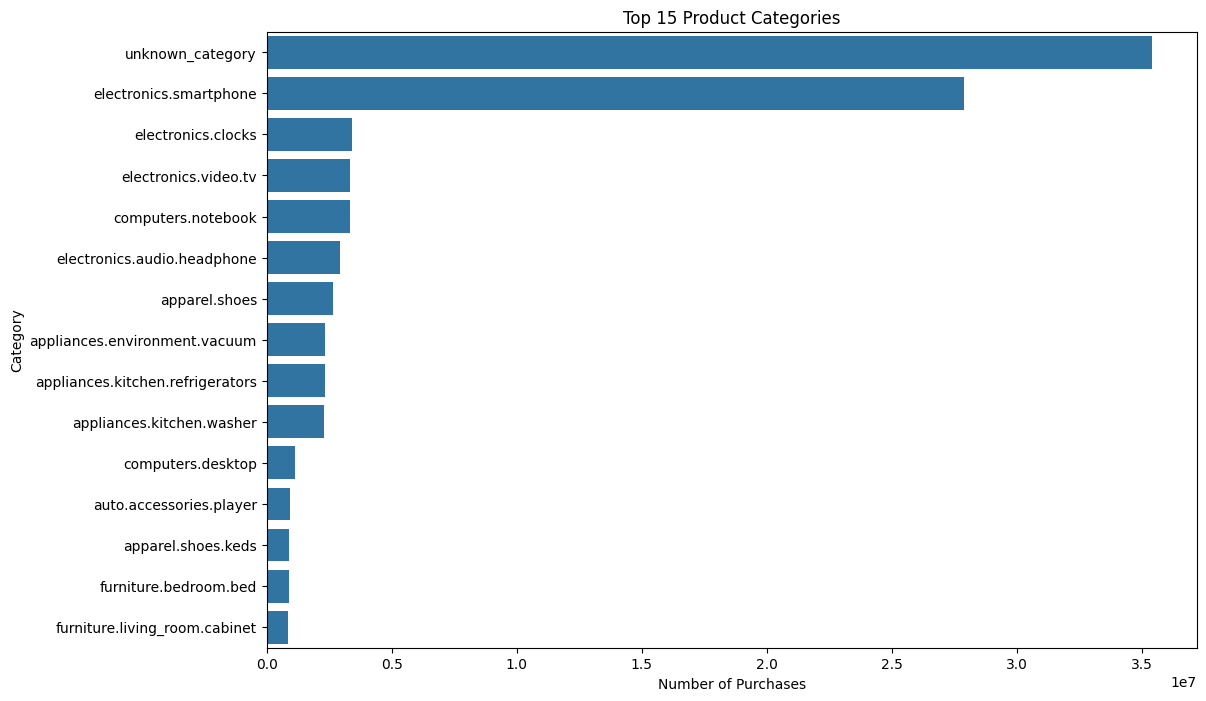

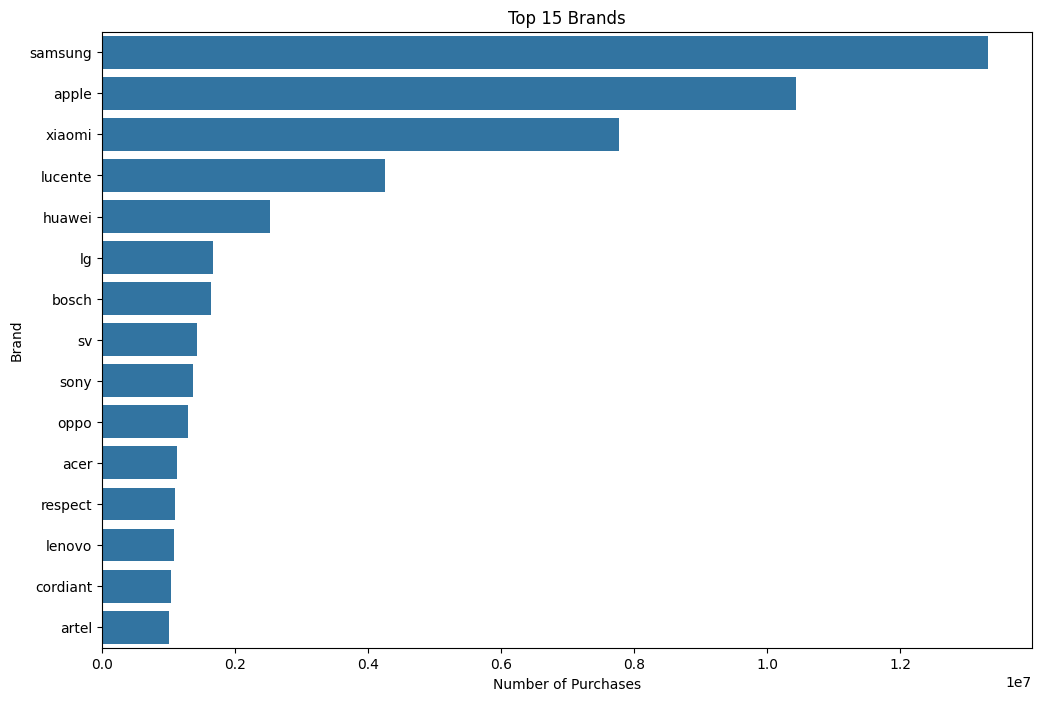

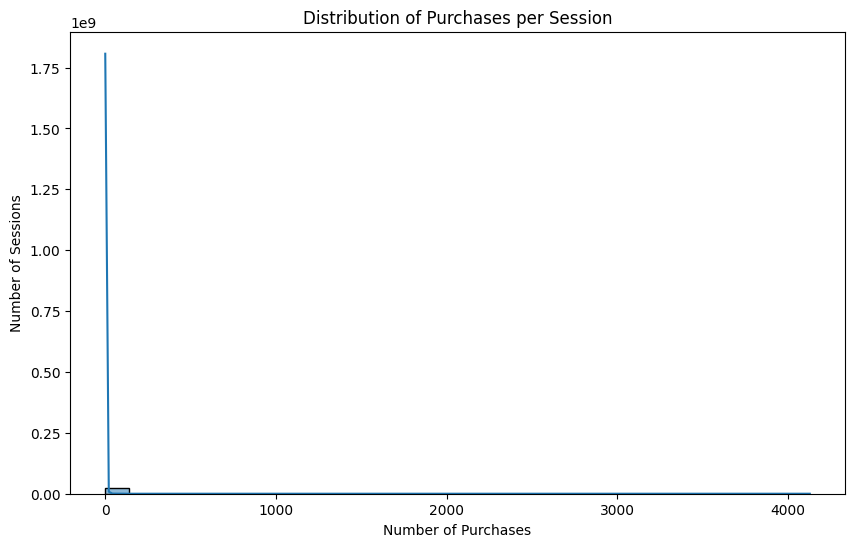

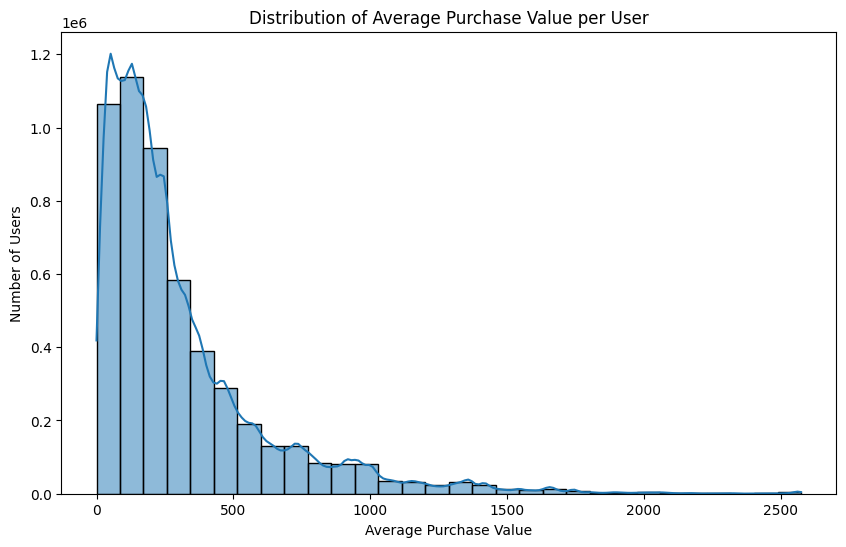

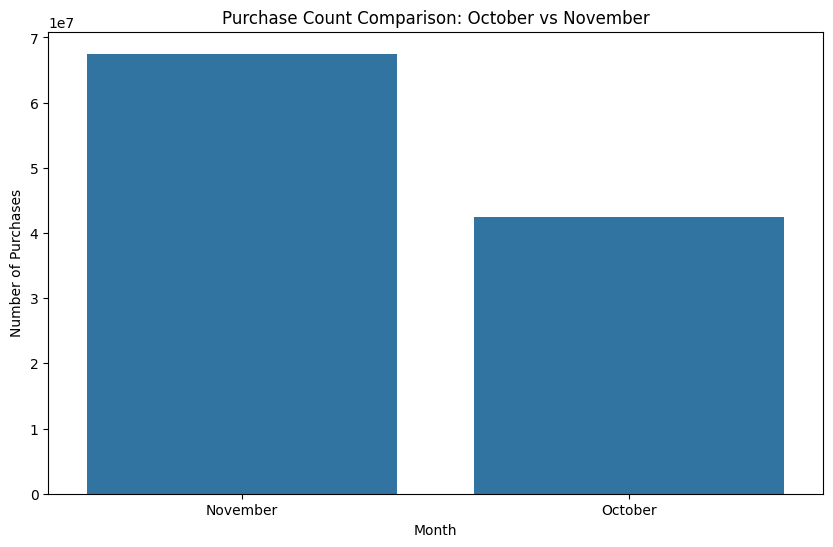

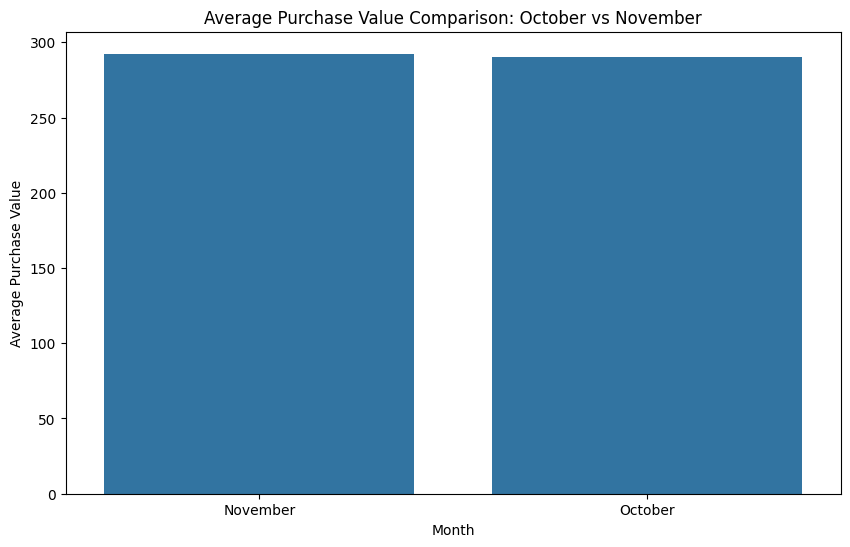

In [ ]:
# Combine datasets for comprehensive analysis
df_combined = pd.concat([df_filled_oct, df_filled_nov]).reset_index(drop=True)

# Make sure event_time is in datetime format
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# Extract time components
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek
df_combined['day_name'] = df_combined['event_time'].dt.day_name()
df_combined['month'] = df_combined['event_time'].dt.month
df_combined['month_name'] = df_combined['event_time'].dt.month_name()

# 1. Purchase Frequency Analysis
# Count number of purchases per user
user_purchase_counts = df_combined.groupby('user_id').size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(user_purchase_counts['purchase_count'], bins=30, kde=True)
plt.title('Distribution of Purchase Frequency per User')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Users')
plt.show()

# 2. Time Analysis
# Analyze purchases by hour of day
hourly_purchases = df_combined.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=hourly_purchases)
plt.title('Purchase Activity by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Purchases')
plt.xticks(range(0, 24))
plt.show()

# Analyze purchases by day of week
weekly_purchases = df_combined.groupby(['day_of_week', 'day_name']).size().reset_index(name='count')
weekly_purchases = weekly_purchases.sort_values('day_of_week')

plt.figure(figsize=(12, 6))
sns.barplot(x='day_name', y='count', data=weekly_purchases, order=weekly_purchases['day_name'])
plt.title('Purchase Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.show()

# 3. Price Analysis
# Analyze average purchase price
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['price'], bins=50, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 4. Category Analysis
# Analyze most popular categories
top_categories = df_combined['category_code'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_categories.index, x=top_categories.values)
plt.title('Top 15 Product Categories')
plt.xlabel('Number of Purchases')
plt.ylabel('Category')
plt.show()

# 5. Brand Analysis
# Analyze most popular brands
top_brands = df_combined['brand'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_brands.index, x=top_brands.values)
plt.title('Top 15 Brands')
plt.xlabel('Number of Purchases')
plt.ylabel('Brand')
plt.show()

# 6. User Session Analysis
# Check number of purchases per session
session_purchase_counts = df_combined.groupby('user_session').size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(session_purchase_counts['purchase_count'], bins=30, kde=True)
plt.title('Distribution of Purchases per Session')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Sessions')
plt.show()

# 7. Average Purchase Value per User
avg_purchase_per_user = df_combined.groupby('user_id')['price'].mean().reset_index(name='avg_purchase_value')

plt.figure(figsize=(10, 6))
sns.histplot(avg_purchase_per_user['avg_purchase_value'], bins=30, kde=True)
plt.title('Distribution of Average Purchase Value per User')
plt.xlabel('Average Purchase Value')
plt.ylabel('Number of Users')
plt.show()

# 8. Comparison between October and November
# Monthly purchase count comparison
monthly_counts = df_combined.groupby('month_name').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='count', data=monthly_counts)
plt.title('Purchase Count Comparison: October vs November')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()

# Monthly average purchase value comparison
monthly_avg_purchase = df_combined.groupby('month_name')['price'].mean().reset_index(name='avg_price')

plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='avg_price', data=monthly_avg_purchase)
plt.title('Average Purchase Value Comparison: October vs November')
plt.xlabel('Month')
plt.ylabel('Average Purchase Value')
plt.show()

Product Affinity Analysis - Tom

Total number of transactions: 23016650
Sample of the first 5 transactions:
Transaction 1: 1 products
Transaction 2: 7 products
Transaction 3: 1 products
Transaction 4: 14 products
Transaction 5: 1 products

Top 20 most frequently purchased product pairs:
Products 1005105 and 1005115 were purchased together 100598 times
Products 1004833 and 1004856 were purchased together 78378 times
Products 1004249 and 1005115 were purchased together 75602 times
Products 1004767 and 1004856 were purchased together 74479 times
Products 1004856 and 1005100 were purchased together 64407 times
Products 1004767 and 1004870 were purchased together 63412 times
Products 4804055 and 4804056 were purchased together 55435 times
Products 1004767 and 1004833 were purchased together 46828 times
Products 1004767 and 1004836 were purchased together 46476 times
Products 1005160 and 1005239 were purchased together 43457 times
Products 1004767 and 1004873 were purchased together 42680 times
Products 1003317 and 1005115 

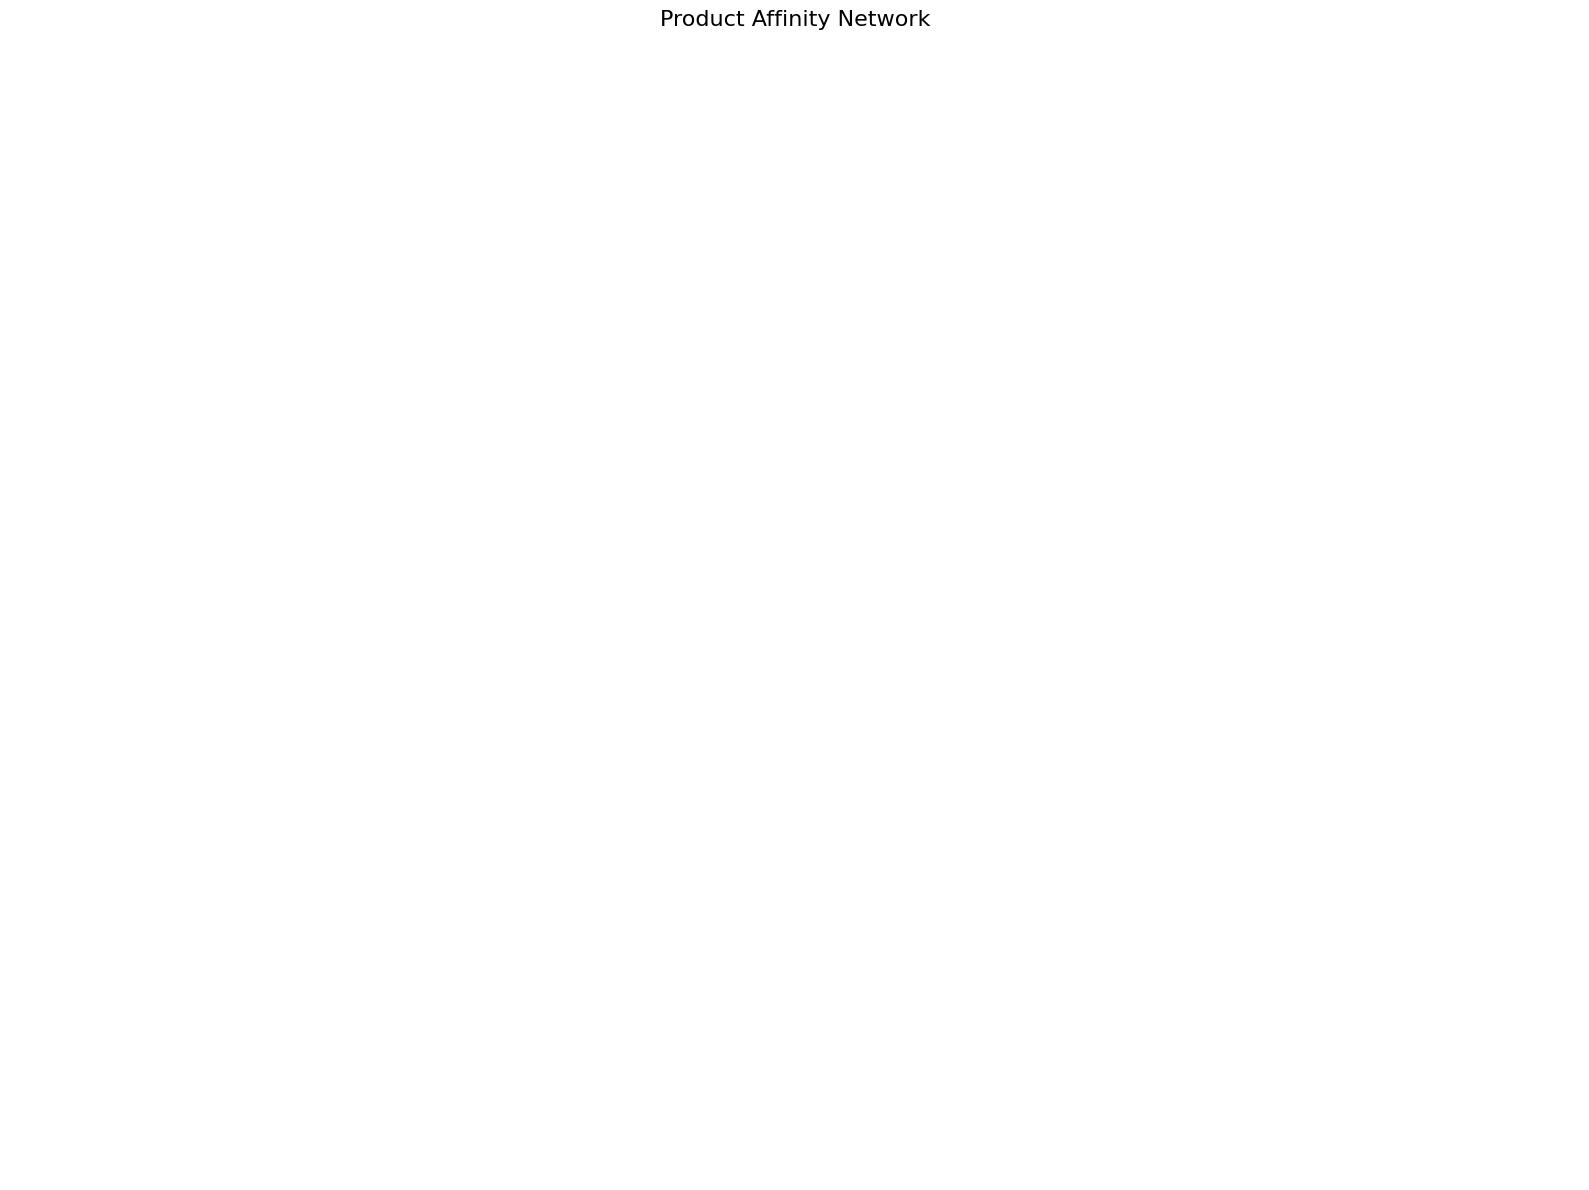


Top 10 category association rules by lift:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [ ]:
# 1. Create a transaction dataset
# Group by user_session to identify products purchased in the same session
transactions = df_combined.groupby(['user_session', 'product_id'])['event_time'].count().reset_index()
transactions = transactions.groupby('user_session')['product_id'].apply(list).reset_index()

print(f"Total number of transactions: {len(transactions)}")
print(f"Sample of the first 5 transactions:")
for i, t in enumerate(transactions['product_id'][:5]):
    print(f"Transaction {i+1}: {len(t)} products")

# 2. Find most common product pairs
product_pairs = []
for products in transactions['product_id']:
    if len(products) >= 2:  # Only consider transactions with at least 2 products
        # Create all possible pairs of products
        pairs = [(a, b) for idx, a in enumerate(products) for b in products[idx + 1:]]
        product_pairs.extend(pairs)

# Count frequency of each pair
pair_counts = Counter(product_pairs)
most_common_pairs = pair_counts.most_common(20)  # Get top 20 most common pairs

print("\nTop 20 most frequently purchased product pairs:")
for pair, count in most_common_pairs:
    print(f"Products {pair[0]} and {pair[1]} were purchased together {count} times")

# 3. Create one-hot encoded transaction data for association rules mining
# Convert list of transactions to one-hot encoded format
te = TransactionEncoder()
te_data = te.fit_transform(transactions['product_id'])
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

# 4. Run Apriori algorithm to find frequent itemsets
# Start with a lower min_support and adjust as needed
min_support = 0.01  # Products that appear in at least 1% of transactions
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
print(f"\nNumber of frequent itemsets found: {len(frequent_itemsets)}")

# 5. Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print(f"Number of rules generated: {len(rules)}")

# Sort rules by lift (a measure of importance of the rule)
rules = rules.sort_values('lift', ascending=False)

# Display top 10 rules by lift
print("\nTop 10 association rules by lift:")
pd.set_option('display.max_columns', None)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# 6. Create a product affinity network visualization
# Use top 50 rules for visualization
top_rules = rules.head(50)

# Create a network graph
G = nx.Graph()

# Add edges for each rule
for i, row in top_rules.iterrows():
    # Convert frozensets to lists
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    # Add all possible pairs between antecedents and consequents
    for a in antecedents:
        for c in consequents:
            # Add nodes if they don't exist
            if not G.has_node(a):
                G.add_node(a)
            if not G.has_node(c):
                G.add_node(c)

            # Add edge with lift as weight
            if G.has_edge(a, c):
                # If edge exists, update weight to maximum of current and new lift
                G[a][c]['weight'] = max(G[a][c]['weight'], row['lift'])
            else:
                G.add_edge(a, c, weight=row['lift'])

# Draw the network
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using force-directed layout

# Edge weights for thickness
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
weights_normalized = [w/max(weights)*10 for w in weights]  # Normalize for better visualization

nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Product Affinity Network", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Category-level affinity analysis
# First, create a mapping from product_id to category_code
product_category_map = df_combined[['product_id', 'category_code']].drop_duplicates().set_index('product_id')['category_code'].to_dict()

# Convert product transactions to category transactions
category_transactions = []
for prod_list in transactions['product_id']:
    # Convert each product to its category and remove duplicates (to avoid counting same category multiple times)
    categories = list(set([product_category_map.get(prod, 'unknown') for prod in prod_list]))
    category_transactions.append(categories)

# Encode category transactions
te_cat = TransactionEncoder()
te_cat_data = te_cat.fit_transform(category_transactions)
df_cat_encoded = pd.DataFrame(te_cat_data, columns=te_cat.columns_)

# Find frequent category itemsets
cat_frequent_itemsets = apriori(df_cat_encoded, min_support=0.02, use_colnames=True)

# Generate category association rules
cat_rules = association_rules(cat_frequent_itemsets, metric="lift", min_threshold=1.0)
cat_rules = cat_rules.sort_values('lift', ascending=False)

print("\nTop 10 category association rules by lift:")
print(cat_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# 8. Save the results for future use in recommendation systems
top_rules.to_csv('/content/drive/MyDrive/ecommerceDataset/product_association_filled_rules.csv', index=False)
cat_rules.to_csv('/content/drive/MyDrive/ecommerceDataset/category_association_filled_rules.csv', index=False)

# Neural Collaborative Filtering (NCF)  dependencies - Tom

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import random
import gc  # Garbage collector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.models import load_model
import pickle, gc
from scipy.sparse import csr_matrix
from collections import defaultdict
import time
from sklearn.preprocessing import MinMaxScaler

# Neural Collaborative Filtering (NCF) Model for E-commerce Recommendations - Tom
This model learns user and product embeddings from purchase interactions and predicts purchase likelihood. It samples a small portion of the full dataset to handle memory constraints, creates a sparse user-item matrix, trains a neural network on positive and negative examples, and generates personalized product recommendations for users.

In [ ]:
# 1 First, sample the data to make it manageable
print("Sampling data to make it manageable...")
# Sample 5% of users to reduce dataset size
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.05 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Combine the sampled datasets
df_combined = pd.concat([df_oct_sample, df_nov_sample]).reset_index(drop=True)

# Print size of sampled dataset
print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

# 2 Further filter to most common products (to reduce matrix dimensions)
# Keep only the top 10,000 products
top_products = df_combined['product_id'].value_counts().nlargest(10000).index
df_combined = df_combined[df_combined['product_id'].isin(top_products)]
print(f"After product filtering: {df_combined.shape}")

# 3 Create the user-item matrix
print("Creating user-item matrix...")
# Create user and product ID mappings first (to use integers instead of original IDs)
unique_users = df_combined['user_id'].unique()
unique_products = df_combined['product_id'].unique()

user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_user = {i: user for user, i in user_to_idx.items()}
idx_to_product = {i: product for product, i in product_to_idx.items()}

# Create sparse matrix directly (without going through a dense DataFrame)
user_indices = [user_to_idx[user] for user in df_combined['user_id']]
product_indices = [product_to_idx[product] for product in df_combined['product_id']]
ones = np.ones(len(df_combined), dtype=np.int8)  # Use int8 to save memory

# Create sparse matrix
sparse_user_item = csr_matrix(
    (ones, (user_indices, product_indices)),
    shape=(len(unique_users), len(unique_products))
)

print(f"Matrix shape: {sparse_user_item.shape} (Users × Products)")
print(f"Sparsity: {sparse_user_item.count_nonzero() / (sparse_user_item.shape[0] * sparse_user_item.shape[1]):.5f}")

# Free more memory
del df_combined
gc.collect()

# 4 Generate training examples in batches to avoid memory issues
print("Preparing training data...")
# Get positive examples (actual purchases)
pos_user_idx, pos_product_idx = sparse_user_item.nonzero()

# Limit the number of positive examples if too many
max_pos_examples = 500000  # Adjust based on your memory constraints
if len(pos_user_idx) > max_pos_examples:
    random_indices = np.random.choice(
        len(pos_user_idx),
        size=max_pos_examples,
        replace=False
    )
    pos_user_idx = pos_user_idx[random_indices]
    pos_product_idx = pos_product_idx[random_indices]

print(f"Using {len(pos_user_idx)} positive examples")

# Create positive examples
user_ids = pos_user_idx.copy()
product_ids = pos_product_idx.copy()
labels = np.ones(len(pos_user_idx), dtype=np.int8)

# Generate negative examples (limiting the number)
num_negative = min(len(pos_user_idx), 500000)  # Limit negative examples
print(f"Generating {num_negative} negative examples...")

neg_user_idx = np.random.randint(0, sparse_user_item.shape[0], size=num_negative)
neg_product_idx = np.random.randint(0, sparse_user_item.shape[1], size=num_negative)

# Filter out positive examples from negatives
neg_mask = np.zeros(num_negative, dtype=bool)
for i in range(num_negative):
    if sparse_user_item[neg_user_idx[i], neg_product_idx[i]] == 0:
        neg_mask[i] = True

# Only keep valid negative examples
neg_user_idx = neg_user_idx[neg_mask]
neg_product_idx = neg_product_idx[neg_mask]

# Append negative examples to training data
user_ids = np.append(user_ids, neg_user_idx)
product_ids = np.append(product_ids, neg_product_idx)
labels = np.append(labels, np.zeros(len(neg_user_idx), dtype=np.int8))

print(f"Total examples: {len(labels)} ({np.sum(labels)} positive, {len(labels) - np.sum(labels)} negative)")

# 5 Split into train and test sets
print("Splitting into train and test sets...")
indices = np.random.permutation(len(labels))
split_point = int(0.8 * len(labels))
train_idx, test_idx = indices[:split_point], indices[split_point:]

X_train = [user_ids[train_idx], product_ids[train_idx]]
y_train = labels[train_idx]
X_test = [user_ids[test_idx], product_ids[test_idx]]
y_test = labels[test_idx]

# 6 Build the model with reduced complexity
print("Building neural collaborative filtering model...")
num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]
embedding_size = 32  # Reduced from 50 to save memory

# Input layers
user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

# Embedding layers
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
product_embedding = Embedding(num_products, embedding_size, name='product_embedding')(product_input)

# Flatten embeddings
user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Concatenate embeddings
concat = Concatenate()([user_vector, product_vector])

# Reduced network complexity
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

# Create and compile model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

# 7 Train the model
print("Training the model...")
history = model.fit(
    [X_train[0], X_train[1]], y_train,
    batch_size=32,  # Smaller batch size to save memory
    epochs=3,       # Fewer epochs for faster training
    validation_data=([X_test[0], X_test[1]], y_test),
    verbose=1
)

# 8. Save the model
model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5')
print("Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5")

# 9. Define recommendation function (modified to use the mappings)
def recommend_products_for_user(user_id, top_n=10):
    if user_id not in user_to_idx:
        return "User not found in the sampled dataset"

    user_idx = user_to_idx[user_id]

    # Get predictions for all products for this user
    user_product_pairs = [(user_idx, p_idx) for p_idx in range(num_products)]

    # Process in batches to avoid memory issues
    batch_size = 1000
    all_scores = []

    for i in range(0, len(user_product_pairs), batch_size):
        batch = user_product_pairs[i:i+batch_size]
        batch_user_ids = np.array([p[0] for p in batch])
        batch_product_ids = np.array([p[1] for p in batch])

        # Get predictions for this batch
        batch_predictions = model.predict([batch_user_ids, batch_product_ids], verbose=0)
        all_scores.extend(batch_predictions.flatten())

    # Create DataFrame with products and scores
    product_scores = pd.DataFrame({
        'product_id': [idx_to_product[idx] for idx in range(num_products)],
        'score': all_scores
    })

    # Filter out already purchased products
    purchased_products = set(idx_to_product[idx] for idx in sparse_user_item[user_idx].nonzero()[1])
    new_recommendations = product_scores[~product_scores['product_id'].isin(purchased_products)]

    # Return top N recommendations
    return new_recommendations.sort_values('score', ascending=False).head(top_n)

# 10. Test with a few users
print("\nGenerating recommendations for sample users:")
# Get a few sample users
sample_test_users = np.random.choice(unique_users, size=3)

for user_id in sample_test_users:
    print(f"\nRecommendations for user {user_id}:")
    recommendations = recommend_products_for_user(user_id, top_n=5)
    print(recommendations)

print("\nCollaborative filtering model training and testing complete!")

Sampling data to make it manageable...
Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Combined=(4264822, 9)
After product filtering: (3127378, 9)
Creating user-item matrix...
Matrix shape: (142284, 10000) (Users × Products)
Sparsity: 0.00103
Preparing training data...
Using 500000 positive examples
Generating 500000 negative examples...
Total examples: 999463 (500000 positive, 499463 negative)
Splitting into train and test sets...
Building neural collaborative filtering model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 32)          │      4,553,088 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_embedding         │ (None, 1, 32)          │        320,000 │ product_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32)             │              0 │ product_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,879,361 (18.61 MB)

 Trainable params: 4,879,361 (18.61 MB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/3
24987/24987 ━━━━━━━━━━━━━━━━━━━━ 233s 9ms/step - accuracy: 0.7353 - loss: 0.5247 - val_accuracy: 0.7948 - val_loss: 0.4471
Epoch 2/3
24987/24987 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.8422 - loss: 0.3600 - val_accuracy: 0.7914 - val_loss: 0.4529
Epoch 3/3
24987/24987 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.8735 - loss: 0.2981 - val_accuracy: 0.7853 - val_loss: 0.4804


Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5

Generating recommendations for sample users:

Recommendations for user 554299543:
     product_id     score
79      1004767  0.990585
77      1005115  0.984529
123     1002544  0.982935
184     1004870  0.980591
44      1004249  0.979064

Recommendations for user 559367920:
     product_id     score
61      1004856  0.976608
79      1004767  0.958341
123     1002544  0.942941
77      1005115  0.912131
44      1004249  0.904841

Recommendations for user 560711363:
     product_id     score
61      1004856  0.996255
79      1004767  0.991263
123     1002544  0.986038
128     1004833  0.983749
184     1004870  0.982017

Collaborative filtering model training and testing complete!


Increase diversity of recommended products, increased sample of users to 10%, increased epochs and added early stopping - Tom

In [ ]:
# 1. First, sample the data to make it manageable
print("Sampling data to make it manageable...")
# Sample 10% of users to reduce dataset size
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Combine the sampled datasets
df_combined = pd.concat([df_oct_sample, df_nov_sample]).reset_index(drop=True)

# Print size of sampled dataset
print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

# 2. Further filter to most common products (to reduce matrix dimensions)
# Keep only the top 10,000 products
top_products = df_combined['product_id'].value_counts().nlargest(10000).index
df_combined = df_combined[df_combined['product_id'].isin(top_products)]
print(f"After product filtering: {df_combined.shape}")

# 3. Create the user-item matrix more efficiently
print("Creating user-item matrix...")
# Create user and product ID mappings first
unique_users = df_combined['user_id'].unique()
unique_products = df_combined['product_id'].unique()

user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_user = {i: user for user, i in user_to_idx.items()}
idx_to_product = {i: product for product, i in product_to_idx.items()}

# Create a mapping from product_id to category_code BEFORE deleting df_combined
print("Creating product-to-category mapping...")
product_category_map = {}
for index, row in df_combined.iterrows():
    product_category_map[row['product_id']] = row['category_code']

# Create sparse matrix directly
user_indices = [user_to_idx[user] for user in df_combined['user_id']]
product_indices = [product_to_idx[product] for product in df_combined['product_id']]
ones = np.ones(len(df_combined), dtype=np.int8)  # Use int8 to save memory

# Create sparse matrix
sparse_user_item = csr_matrix(
    (ones, (user_indices, product_indices)),
    shape=(len(unique_users), len(unique_products))
)

print(f"Matrix shape: {sparse_user_item.shape} (Users × Products)")
print(f"Sparsity: {sparse_user_item.count_nonzero() / (sparse_user_item.shape[0] * sparse_user_item.shape[1]):.5f}")

# NOW it's safe to delete df_combined
del df_combined
gc.collect()

# 4. Generate training examples in batches to avoid memory issues
print("Preparing training data...")
# Get positive examples (actual purchases)
pos_user_idx, pos_product_idx = sparse_user_item.nonzero()

# Limit the number of positive examples if too many
max_pos_examples = 500000  # Adjust based on your memory constraints
if len(pos_user_idx) > max_pos_examples:
    random_indices = np.random.choice(
        len(pos_user_idx),
        size=max_pos_examples,
        replace=False
    )
    pos_user_idx = pos_user_idx[random_indices]
    pos_product_idx = pos_product_idx[random_indices]

print(f"Using {len(pos_user_idx)} positive examples")

# Create positive examples
user_ids = pos_user_idx.copy()
product_ids = pos_product_idx.copy()
labels = np.ones(len(pos_user_idx), dtype=np.int8)

# Generate negative examples (limiting the number)
num_negative = min(len(pos_user_idx), 500000)  # Limit negative examples
print(f"Generating {num_negative} negative examples...")

neg_user_idx = np.random.randint(0, sparse_user_item.shape[0], size=num_negative)
neg_product_idx = np.random.randint(0, sparse_user_item.shape[1], size=num_negative)

# Filter out positive examples from negatives
neg_mask = np.zeros(num_negative, dtype=bool)
for i in range(num_negative):
    if sparse_user_item[neg_user_idx[i], neg_product_idx[i]] == 0:
        neg_mask[i] = True

# Only keep valid negative examples
neg_user_idx = neg_user_idx[neg_mask]
neg_product_idx = neg_product_idx[neg_mask]

# Append negative examples to training data
user_ids = np.append(user_ids, neg_user_idx)
product_ids = np.append(product_ids, neg_product_idx)
labels = np.append(labels, np.zeros(len(neg_user_idx), dtype=np.int8))

print(f"Total examples: {len(labels)} ({np.sum(labels)} positive, {len(labels) - np.sum(labels)} negative)")

# 5. Split into train and test sets
print("Splitting into train and test sets...")
indices = np.random.permutation(len(labels))
split_point = int(0.8 * len(labels))
train_idx, test_idx = indices[:split_point], indices[split_point:]

X_train = [user_ids[train_idx], product_ids[train_idx]]
y_train = labels[train_idx]
X_test = [user_ids[test_idx], product_ids[test_idx]]
y_test = labels[test_idx]

# 6. Build the model with reduced complexity
print("Building neural collaborative filtering model...")
num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]
embedding_size = 32  # Reduced from 50 to save memory

# Input layers
user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

# Embedding layers
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
product_embedding = Embedding(num_products, embedding_size, name='product_embedding')(product_input)

# Flatten embeddings
user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Concatenate embeddings
concat = Concatenate()([user_vector, product_vector])

# Reduced network complexity
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

# Create and compile model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

# 7. Train the model with a smaller batch size and fewer epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    [X_train[0], X_train[1]], y_train,
    batch_size=32,
    epochs=15,
    validation_data=([X_test[0], X_test[1]], y_test),
    callbacks=[early_stopping],
    verbose=1
)
# 8. Save the model
model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5')
print("Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5")


# 9. Define enhanced recommendation function with diversity
def recommend_products_for_user(user_id, top_n=10, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    user_idx = user_to_idx[user_id]

    # Get predictions for all products for this user
    user_product_pairs = [(user_idx, p_idx) for p_idx in range(num_products)]

    # Process in batches to avoid memory issues
    batch_size = 1000
    all_scores = []

    for i in range(0, len(user_product_pairs), batch_size):
        batch = user_product_pairs[i:i+batch_size]
        batch_user_ids = np.array([p[0] for p in batch])
        batch_product_ids = np.array([p[1] for p in batch])

        # Get predictions for this batch
        batch_predictions = model.predict([batch_user_ids, batch_product_ids], verbose=0)
        all_scores.extend(batch_predictions.flatten())

    # Create DataFrame with products and scores
    product_scores = pd.DataFrame({
        'product_id': [idx_to_product[idx] for idx in range(num_products)],
        'score': all_scores
    })

    # Filter out already purchased products
    purchased_products = set(idx_to_product[idx] for idx in sparse_user_item[user_idx].nonzero()[1])
    new_recommendations = product_scores[~product_scores['product_id'].isin(purchased_products)]

    # Get top candidates (more than we need)
    top_candidates = new_recommendations.sort_values('score', ascending=False).head(top_n * 3)

    # Add category for all candidates
    top_candidates['category'] = top_candidates['product_id'].apply(
        lambda x: product_category_map.get(x, "unknown")
    )

    # Check if we have any recommendations
    if len(top_candidates) == 0:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    # If diversity weight is 0 or we have very few recommendations,
    # just return top recommendations by score
    if diversity_weight == 0 or len(top_candidates) <= top_n:
        return top_candidates.head(min(top_n, len(top_candidates)))

    # Reset index to make sure iloc works correctly
    top_candidates = top_candidates.reset_index(drop=True)

    # Now we're sure we have candidates and the index is reset
    selected_items = []
    selected_indices = []
    selected_categories = []

    # Add first item if we have at least one
    if len(top_candidates) > 0:
        selected_items.append(top_candidates.iloc[0]['product_id'])
        selected_indices.append(0)
        selected_categories.append(top_candidates.iloc[0]['category'])

    # Add more items, balancing relevance and diversity
    while len(selected_items) < top_n and len(selected_indices) < len(top_candidates):
        max_combined_score = -1
        next_item_idx = -1

        # For each candidate item not yet selected
        for idx in range(len(top_candidates)):
            if idx in selected_indices:
                continue

            row = top_candidates.iloc[idx]
            product_id = row['product_id']
            category = row['category']
            relevance_score = row['score']

            # Calculate diversity based on category
            # Count occurrences of this category in selected items
            category_count = selected_categories.count(category)
            diversity_score = 1.0 / (1.0 + category_count)  # Higher if category less represented

            # Combined score balancing relevance and diversity
            combined_score = (1 - diversity_weight) * relevance_score + diversity_weight * diversity_score

            if combined_score > max_combined_score:
                max_combined_score = combined_score
                next_item_idx = idx

        if next_item_idx != -1:
            selected_indices.append(next_item_idx)
            selected_items.append(top_candidates.iloc[next_item_idx]['product_id'])
            selected_categories.append(top_candidates.iloc[next_item_idx]['category'])

    # Return the diversified recommendations
    result = top_candidates.iloc[selected_indices].copy()
    return result[['product_id', 'score', 'category']]

# 10. Test with a few users, comparing standard and diverse recommendations
print("\nGenerating recommendations for sample users:")
# Get a few sample users
sample_test_users = np.random.choice(unique_users, size=3)

for user_id in sample_test_users:
    try:
        print(f"\nRecommendations for user {user_id}:")

        # Try to get standard recommendations
        try:
            standard_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
            print("Standard recommendations (no diversity):")
            if len(standard_recommendations) > 0:
                print(standard_recommendations[['product_id', 'score']])
            else:
                print("No standard recommendations available for this user")
        except Exception as e:
            print(f"Error getting standard recommendations: {str(e)}")

        # Try to get diverse recommendations
        try:
            print("\nDiverse recommendations (with category balancing):")
            diverse_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0.3)
            if len(diverse_recommendations) > 0:
                print(diverse_recommendations)
            else:
                print("No diverse recommendations available for this user")
        except Exception as e:
            print(f"Error getting diverse recommendations: {str(e)}")

        # Try to compare categories
        try:
            if len(standard_recommendations) > 0 and len(diverse_recommendations) > 0:
                std_categories = standard_recommendations['category'].value_counts()
                div_categories = diverse_recommendations['category'].value_counts()

                print("\nCategory distribution comparison:")
                print("Standard recommendations categories:", std_categories.to_dict())
                print("Diverse recommendations categories:", div_categories.to_dict())
            else:
                print("Not enough recommendations to compare category distributions")
        except Exception as e:
            print(f"Error comparing categories: {str(e)}")

    except Exception as e:
        print(f"Error processing user {user_id}: {str(e)}")

print("\nCollaborative filtering model training and testing complete!")

Sampling data to make it manageable...
Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Combined=(4220134, 9)
After product filtering: (3097490, 9)
Creating user-item matrix...
Creating product-to-category mapping...
Matrix shape: (142200, 10000) (Users × Products)
Sparsity: 0.00102
Preparing training data...
Using 500000 positive examples
Generating 500000 negative examples...
Total examples: 999513 (500000 positive, 499513 negative)
Splitting into train and test sets...
Building neural collaborative filtering model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  4,550,400 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 1, 32)     │    320,000 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,876,673 (18.60 MB)

 Trainable params: 4,876,673 (18.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.7342 - loss: 0.5258 - val_accuracy: 0.7943 - val_loss: 0.4472
Epoch 2/15
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 249s 10ms/step - accuracy: 0.8417 - loss: 0.3602 - val_accuracy: 0.7925 - val_loss: 0.4548
Epoch 3/15
24988/24988 ━━━━━━━━━━━━━━━━━━━━ 248s 10ms/step - accuracy: 0.8731 - loss: 0.2978 - val_accuracy: 0.7842 - val_loss: 0.4777


Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5

Generating recommendations for sample users:

Recommendations for user 535701629:
Standard recommendations (no diversity):
    product_id     score
10     1004870  0.989925
5      1005115  0.989107
81     1004856  0.988359
9      1004767  0.986254
88     1004249  0.983260

Diverse recommendations (with category balancing):
    product_id     score                     category
0      1004870  0.989925       electronics.smartphone
8      4803977  0.970183  electronics.audio.headphone
1      1005115  0.989107       electronics.smartphone
14     4804056  0.963002  electronics.audio.headphone
2      1004856  0.988359       electronics.smartphone

Category distribution comparison:
Standard recommendations categories: {'electronics.smartphone': 5}
Diverse recommendations categories: {'electronics.smartphone': 3, 'electronics.audio.headphone': 2}

Recommendations for user 552087795:
Standard recommendations (no divers

# Added L2 regularization and set seed for reproducibility - Tom

In [ ]:
# Set global random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Sampling data to make it manageable...")

# Sample 10% of users to reduce dataset size
user_ids_unique = df_filled_oct['user_id'].unique()
user_ids_unique.sort()  # Sort for consistent seed behavior
rng = np.random.default_rng(SEED)
sample_users = rng.choice(
    user_ids_unique,
    size=int(0.10 * len(user_ids_unique)),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Use October for training
df_combined = df_oct_sample.copy()

print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

# Keep only the top 10,000 products
top_products = df_combined['product_id'].value_counts().nlargest(10000).index
df_combined = df_combined[df_combined['product_id'].isin(top_products)]
print(f"After product filtering: {df_combined.shape}")

# Create user and product ID mappings
unique_users = df_combined['user_id'].unique()
unique_products = df_combined['product_id'].unique()

user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_user = {i: user for user, i in user_to_idx.items()}
idx_to_product = {i: product for product, i in product_to_idx.items()}

print("Creating product-to-category mapping...")
product_category_map = {}
for index, row in df_combined.iterrows():
    product_category_map[row['product_id']] = row['category_code']

# Create sparse matrix
total_interactions = len(df_combined)
user_indices = [user_to_idx[user] for user in df_combined['user_id']]
product_indices = [product_to_idx[product] for product in df_combined['product_id']]
ones = np.ones(total_interactions, dtype=np.int8)

sparse_user_item = csr_matrix(
    (ones, (user_indices, product_indices)),
    shape=(len(unique_users), len(unique_products))
)

print(f"Matrix shape: {sparse_user_item.shape} (Users × Products)")
print(f"Sparsity: {sparse_user_item.count_nonzero() / (sparse_user_item.shape[0] * sparse_user_item.shape[1]):.5f}")

del df_combined
gc.collect()

# Prepare training data
print("Preparing training data...")
pos_user_idx, pos_product_idx = sparse_user_item.nonzero()

max_pos_examples = 500000
if len(pos_user_idx) > max_pos_examples:
    random_indices = rng.choice(
        len(pos_user_idx),
        size=max_pos_examples,
        replace=False
    )
    pos_user_idx = pos_user_idx[random_indices]
    pos_product_idx = pos_product_idx[random_indices]

print(f"Using {len(pos_user_idx)} positive examples")

user_ids = pos_user_idx.copy()
product_ids = pos_product_idx.copy()
labels = np.ones(len(pos_user_idx), dtype=np.int8)

num_negative = min(len(pos_user_idx), 500000)
print(f"Generating {num_negative} negative examples...")

neg_user_idx = rng.integers(0, sparse_user_item.shape[0], size=num_negative)
neg_product_idx = rng.integers(0, sparse_user_item.shape[1], size=num_negative)

neg_mask = np.zeros(num_negative, dtype=bool)
for i in range(num_negative):
    if sparse_user_item[neg_user_idx[i], neg_product_idx[i]] == 0:
        neg_mask[i] = True

neg_user_idx = neg_user_idx[neg_mask]
neg_product_idx = neg_product_idx[neg_mask]

user_ids = np.append(user_ids, neg_user_idx)
product_ids = np.append(product_ids, neg_product_idx)
labels = np.append(labels, np.zeros(len(neg_user_idx), dtype=np.int8))

print(f"Total examples: {len(labels)} ({np.sum(labels)} positive, {len(labels) - np.sum(labels)} negative)")

print("Splitting into train and test sets...")
indices = rng.permutation(len(labels))
split_point = int(0.8 * len(labels))
train_idx, test_idx = indices[:split_point], indices[split_point:]

X_train = [user_ids[train_idx], product_ids[train_idx]]
y_train = labels[train_idx]
X_test = [user_ids[test_idx], product_ids[test_idx]]
y_test = labels[test_idx]

print("Building neural collaborative filtering model...")
num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]
embedding_size = 32

user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

user_embedding = Embedding(
    input_dim=num_users,
    output_dim=embedding_size,
    name='user_embedding',
    embeddings_regularizer=l2(1e-6)
)(user_input)

product_embedding = Embedding(
    input_dim=num_products,
    output_dim=embedding_size,
    name='product_embedding',
    embeddings_regularizer=l2(1e-6)
)(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

concat = Concatenate()([user_vector, product_vector])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    [X_train[0], X_train[1]], y_train,
    batch_size=32,
    epochs=15,
    validation_data=([X_test[0], X_test[1]], y_test),
    callbacks=[early_stopping],
    verbose=1
)

model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras')
print("Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras")

Sampling data to make it manageable...
Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Combined=(4229897, 9)
After product filtering: (3240336, 9)
Creating product-to-category mapping...
Matrix shape: (280841, 10000) (Users × Products)
Sparsity: 0.00060
Preparing training data...
Using 500000 positive examples
Generating 500000 negative examples...
Total examples: 999709 (500000 positive, 499709 negative)
Splitting into train and test sets...
Building neural collaborative filtering model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  8,986,912 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 1, 32)     │    320,000 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,313,185 (35.53 MB)

 Trainable params: 9,313,185 (35.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
24993/24993 ━━━━━━━━━━━━━━━━━━━━ 1516s 61ms/step - accuracy: 0.7358 - loss: 0.5322 - val_accuracy: 0.7831 - val_loss: 0.4808
Epoch 2/15
24993/24993 ━━━━━━━━━━━━━━━━━━━━ 1522s 61ms/step - accuracy: 0.7967 - loss: 0.4602 - val_accuracy: 0.7848 - val_loss: 0.4810
Epoch 3/15
24993/24993 ━━━━━━━━━━━━━━━━━━━━ 1523s 61ms/step - accuracy: 0.8119 - loss: 0.4374 - val_accuracy: 0.7755 - val_loss: 0.5001
Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras


## Continue from trained model

In [ ]:
model = load_model('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras')
print("Model loaded — ready to evaluate.")

# Recreate sample_users and df_nov_sample since they were deleted earlier
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]


# pick random user for testing
some_user_id = list(sample_users)[0]  # or any valid user ID
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
user_nov_data = df_nov_sample[df_nov_sample['user_id'] == some_user_id]


# 9. Define enhanced recommendation function with diversity
def recommend_products_for_user(user_id, top_n=10, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    user_idx = user_to_idx[user_id]

    # Get predictions for all products for this user
    user_product_pairs = [(user_idx, p_idx) for p_idx in range(num_products)]

    # Process in batches to avoid memory issues
    batch_size = 1000
    all_scores = []

    for i in range(0, len(user_product_pairs), batch_size):
        batch = user_product_pairs[i:i+batch_size]
        batch_user_ids = np.array([p[0] for p in batch])
        batch_product_ids = np.array([p[1] for p in batch])

        # Get predictions for this batch
        batch_predictions = model.predict([batch_user_ids, batch_product_ids], verbose=0)
        all_scores.extend(batch_predictions.flatten())

    # Create DataFrame with products and scores
    product_scores = pd.DataFrame({
        'product_id': [idx_to_product[idx] for idx in range(num_products)],
        'score': all_scores
    })

    # Filter out already purchased products
    purchased_products = set(idx_to_product[idx] for idx in sparse_user_item[user_idx].nonzero()[1])
    new_recommendations = product_scores[~product_scores['product_id'].isin(purchased_products)]

    # Get top candidates (fallback if too few remain)
    num_candidates = min(top_n * 3, len(new_recommendations))
    if num_candidates == 0:
      return pd.DataFrame(columns=['product_id', 'score', 'category'])

top_candidates = new_recommendations.sort_values('score', ascending=False).head(num_candidates).copy()
 # updated to use in A/B

    # Add category for all candidates
    top_candidates['category'] = top_candidates['product_id'].apply(
        lambda x: product_category_map.get(x, "unknown")
    )

    # Check if we have any recommendations
    if len(top_candidates) == 0:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    # If diversity weight is 0 or we have very few recommendations,
    # just return top recommendations by score
    if diversity_weight == 0 or len(top_candidates) <= top_n:
        return top_candidates.head(min(top_n, len(top_candidates)))

    # Reset index to make sure iloc works correctly
    top_candidates = top_candidates.reset_index(drop=True)

    # Now we're sure we have candidates and the index is reset
    selected_items = []
    selected_indices = []
    selected_categories = []

    # Add first item if we have at least one
    if len(top_candidates) > 0:
        selected_items.append(top_candidates.iloc[0]['product_id'])
        selected_indices.append(0)
        selected_categories.append(top_candidates.iloc[0]['category'])

    # Add more items, balancing relevance and diversity
    while len(selected_items) < top_n and len(selected_indices) < len(top_candidates):
        max_combined_score = -1
        next_item_idx = -1

        # For each candidate item not yet selected
        for idx in range(len(top_candidates)):
            if idx in selected_indices:
                continue

            row = top_candidates.iloc[idx]
            product_id = row['product_id']
            category = row['category']
            relevance_score = row['score']

            # Calculate diversity based on category
            # Count occurrences of this category in selected items
            category_count = selected_categories.count(category)
            diversity_score = 1.0 / (1.0 + category_count)  # Higher if category less represented

            # Combined score balancing relevance and diversity
            combined_score = (1 - diversity_weight) * relevance_score + diversity_weight * diversity_score

            if combined_score > max_combined_score:
                max_combined_score = combined_score
                next_item_idx = idx

        if next_item_idx != -1:
            selected_indices.append(next_item_idx)
            selected_items.append(top_candidates.iloc[next_item_idx]['product_id'])
            selected_categories.append(top_candidates.iloc[next_item_idx]['category'])

    # Return the diversified recommendations
    result = top_candidates.iloc[selected_indices].copy()
    return result[['product_id', 'score', 'category']]

# 10. Test with a few users, comparing standard and diverse recommendations
print("\nGenerating recommendations for sample users:")
# Get a few sample users from the November sample
unique_users = df_nov_sample['user_id'].unique()
sample_test_users = np.random.choice(unique_users, size=3)

for user_id in sample_test_users:
    try:
        print(f"\nRecommendations for user {user_id}:")

        # Try to get standard recommendations
        try:
            standard_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
            print("Standard recommendations (no diversity):")
            if len(standard_recommendations) > 0:
                print(standard_recommendations[['product_id', 'score']])
            else:
                print("No standard recommendations available for this user")
        except Exception as e:
            print(f"Error getting standard recommendations: {str(e)}")

        # Try to get diverse recommendations
        try:
            print("\nDiverse recommendations (with category balancing):")
            diverse_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0.3)
            if len(diverse_recommendations) > 0:
                print(diverse_recommendations)
            else:
                print("No diverse recommendations available for this user")
        except Exception as e:
            print(f"Error getting diverse recommendations: {str(e)}")

        # Try to compare categories
        try:
            if len(standard_recommendations) > 0 and len(diverse_recommendations) > 0:
                std_categories = standard_recommendations['category'].value_counts()
                div_categories = diverse_recommendations['category'].value_counts()

                print("\nCategory distribution comparison:")
                print("Standard recommendations categories:", std_categories.to_dict())
                print("Diverse recommendations categories:", div_categories.to_dict())
            else:
                print("Not enough recommendations to compare category distributions")
        except Exception as e:
            print(f"Error comparing categories: {str(e)}")

    except Exception as e:
        print(f"Error processing user {user_id}: {str(e)}")

print("\nCollaborative filtering model training and testing complete!")

Model loaded — ready to evaluate.

Generating recommendations for sample users:

Recommendations for user 514414554:
Standard recommendations (no diversity):
No standard recommendations available for this user

Diverse recommendations (with category balancing):
No diverse recommendations available for this user
Not enough recommendations to compare category distributions

Recommendations for user 519083102:
Standard recommendations (no diversity):
    product_id     score
5      1004856  0.976449
84     1005105  0.975197
66     1002544  0.972507
6      1004767  0.972130
22     1005115  0.967479

Diverse recommendations (with category balancing):
    product_id     score                     category
0      1004856  0.976449       electronics.smartphone
13     4804056  0.942677  electronics.audio.headphone
14     5100816  0.940738             unknown_category
1      1005105  0.975197       electronics.smartphone
2      1002544  0.972507       electronics.smartphone

Category distribution

Plot Accuracy

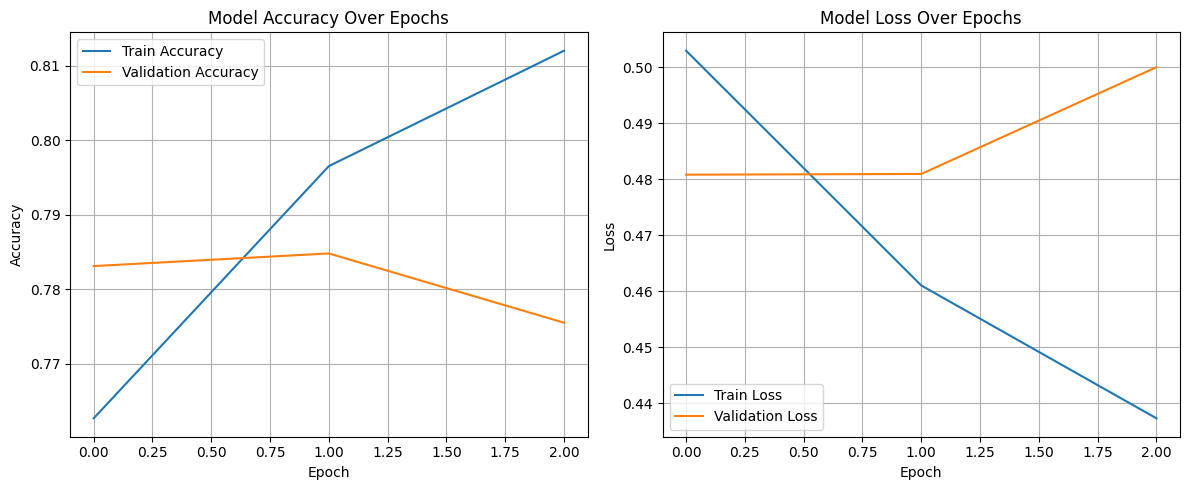

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## A/B Testing - failure
A: Top 5 popular products (non-personalized)
B: Top 5 NCF-predicted products (personalized, score-based, no diversity yet)
Stopped after 3 hours - changing methodology below

In [ ]:
# Group November purchases per user
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

ncf_recommendations = {}

for user_id in sample_users:
    try:
        top_recs = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
        ncf_recommendations[user_id] = set(top_recs['product_id']) if not top_recs.empty else set()
    except:
        ncf_recommendations[user_id] = set()


# Get top 5 popular products across October (can also use November)
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()

standard_recommendations = {user_id: set(popular_products) for user_id in sample_users}


def evaluate_recommendations(ground_truth, predictions):
    hits = 0
    total = 0

    for user_id in predictions:
        actual = ground_truth.get(user_id, set())
        recommended = predictions.get(user_id, set())
        if actual & recommended:
            hits += 1
        total += 1

    ctr = hits / total if total > 0 else 0
    return ctr, hits, total


ctr_ncf, hits_ncf, total_ncf = evaluate_recommendations(ground_truth_november, ncf_recommendations)
ctr_std, hits_std, total_std = evaluate_recommendations(ground_truth_november, standard_recommendations)

print(f"Standard Recs: CTR = {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"NCF Recs     : CTR = {ctr_ncf:.2%} ({hits_ncf}/{total_ncf})")
print(f"Improvement  : {(ctr_ncf - ctr_std) / ctr_std:.1%}" if ctr_std else "N/A")


A/B Testing using November data as B

In [ ]:
# A/B Evaluation: Offline test using real November purchases
from collections import defaultdict

# Step 1: Ground truth from November
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# Step 2A: Get NCF Recommendations
ncf_recommendations = {}
for user_id in sample_users:
    try:
        top_recs = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
        ncf_recommendations[user_id] = set(top_recs['product_id']) if not top_recs.empty else set()
    except:
        ncf_recommendations[user_id] = set()

# Step 2B: Get Standard Recommendations (popular products)
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {user_id: set(popular_products) for user_id in sample_users}

# Step 3: Evaluation function
def evaluate_recommendations(ground_truth, predictions):
    hits = 0
    total = 0
    for user_id in predictions:
        actual = ground_truth.get(user_id, set())
        recommended = predictions.get(user_id, set())
        if actual & recommended:
            hits += 1
        total += 1
    ctr = hits / total if total > 0 else 0
    return ctr, hits, total

# Step 4: Compare both models
ctr_std, hits_std, total_std = evaluate_recommendations(ground_truth_november, standard_recommendations)
ctr_ncf, hits_ncf, total_ncf = evaluate_recommendations(ground_truth_november, ncf_recommendations)

print("==== A/B Test Results ====")
print(f"Standard Recommendations:")
print(f" - CTR        : {ctr_std:.2%}")
print(f" - Hits       : {hits_std}")
print(f" - Users Eval : {total_std}")

print(f"\nNeural CF Recommendations:")
print(f" - CTR        : {ctr_ncf:.2%}")
print(f" - Hits       : {hits_ncf}")
print(f" - Users Eval : {total_ncf}")

if ctr_std > 0:
    improvement = (ctr_ncf - ctr_std) / ctr_std
    print(f"\n💡 CTR Improvement: {improvement:.1%}")
else:
    print("\nCTR Improvement: N/A (baseline CTR = 0)")

# Step 5 (optional): Bar chart to visualize
import matplotlib.pyplot as plt

plt.bar(['Standard', 'NCF'], [ctr_std * 100, ctr_ncf * 100], color=['blue', 'green'])
plt.ylabel('Click-Through Rate (%)')
plt.title('Offline A/B Test: Recommendation CTR')
plt.ylim(0, max(ctr_std, ctr_ncf) * 100 + 5)
plt.text(0, ctr_std * 100 + 1, f"{ctr_std:.2%}", ha='center')
plt.text(1, ctr_ncf * 100 + 1, f"{ctr_ncf:.2%}", ha='center')
plt.grid(axis='y')
plt.show()


In [ ]:
# Assume 100,000 monthly active users (adjust if needed)
total_users = 100000

# Use your real CTRs and AOV
extra_clicks = total_users * (ctr_ncf - ctr_std)
aov = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)].groupby('user_id')['price'].sum().mean()

# Revenue gain estimate
added_revenue = extra_clicks * aov

print("==== Revenue Projection ====")
print(f"User base (MAUs): {total_users:,}")
print(f"CTR Lift        : {(ctr_ncf - ctr_std):.2%}")
print(f"Extra Orders    : {int(extra_clicks):,}")
print(f"AOV             : ${aov:.2f}")
print(f"💸 Projected Monthly Revenue Increase: ${added_revenue:,.2f}")
print(f"📈 Annualized Impact (x12): ${added_revenue * 12:,.2f}")


# NCF Scalable production grade model

In [ ]:
np.random.seed(42)

# Step 1: Sample and Prepare Data
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
df_combined = df_oct_sample.copy()

print(f"Sampled size: Combined={df_combined.shape}")

# Step 2: Filter Top Products
top_products = df_combined['product_id'].value_counts().nlargest(10000).index
df_combined = df_combined[df_combined['product_id'].isin(top_products)]

# Step 3: Mappings and Matrix
unique_users = df_combined['user_id'].unique()
unique_products = df_combined['product_id'].unique()
user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_product = {i: product for product, i in product_to_idx.items()}
product_category_map = dict(zip(df_combined['product_id'], df_combined['category_code']))

user_indices = [user_to_idx[u] for u in df_combined['user_id']]
product_indices = [product_to_idx[p] for p in df_combined['product_id']]

sparse_user_item = csr_matrix((np.ones(len(user_indices), dtype=np.int8),
                                (user_indices, product_indices)),
                                shape=(len(unique_users), len(unique_products)))

# Step 4: Generate Training Examples
pos_user_idx, pos_product_idx = sparse_user_item.nonzero()
max_pos_examples = 500000

if len(pos_user_idx) > max_pos_examples:
    sampled_idx = np.random.choice(len(pos_user_idx), max_pos_examples, replace=False)
    pos_user_idx = pos_user_idx[sampled_idx]
    pos_product_idx = pos_product_idx[sampled_idx]

user_ids = pos_user_idx.copy()
product_ids = pos_product_idx.copy()
labels = np.ones(len(user_ids), dtype=np.int8)

neg_user_idx = np.random.randint(0, sparse_user_item.shape[0], size=max_pos_examples)
neg_product_idx = np.random.randint(0, sparse_user_item.shape[1], size=max_pos_examples)
neg_mask = np.array([sparse_user_item[u, p] == 0 for u, p in zip(neg_user_idx, neg_product_idx)])

neg_user_idx = neg_user_idx[neg_mask]
neg_product_idx = neg_product_idx[neg_mask]

user_ids = np.append(user_ids, neg_user_idx)
product_ids = np.append(product_ids, neg_product_idx)
labels = np.append(labels, np.zeros(len(neg_user_idx), dtype=np.int8))

# Step 5: Split Data
X_train_user, X_test_user, X_train_product, X_test_product, y_train, y_test = train_test_split(
    user_ids, product_ids, labels, test_size=0.2, random_state=42
)

X_train = [X_train_user, X_train_product]
X_test = [X_test_user, X_test_product]

# Step 6: Build Model
num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]
embedding_size = 32

user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

user_embedding = Embedding(num_users, embedding_size, name='user_embedding', embeddings_regularizer=l2(1e-6))(user_input)
product_embedding = Embedding(num_products, embedding_size, name='product_embedding', embeddings_regularizer=l2(1e-6))(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

concat = Concatenate()([user_vector, product_vector])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit([X_train[0], X_train[1]], y_train,
                    batch_size=32, epochs=15,
                    validation_data=([X_test[0], X_test[1]], y_test),
                    callbacks=[early_stopping], verbose=1)

# Step 8: Save Model and Artifacts
model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras')
np.save('/content/drive/MyDrive/ecommerceDataset/user_embeddings.npy',
        model.get_layer('user_embedding').get_weights()[0])
np.save('/content/drive/MyDrive/ecommerceDataset/product_embeddings.npy',
        model.get_layer('product_embedding').get_weights()[0])

with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'idx_to_product': idx_to_product,
        'product_category_map': product_category_map,
        'sparse_user_item': sparse_user_item,
        'num_products': num_products,
        'embedding_size': embedding_size
    }, f)

print("Model and all artifacts saved successfully.")


Sampled size: Combined=(4222471, 9)
Epoch 1/15
24992/24992 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.7344 - loss: 0.5330 - val_accuracy: 0.7824 - val_loss: 0.4826
Epoch 2/15
24992/24992 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.8158 - loss: 0.4282 - val_accuracy: 0.7863 - val_loss: 0.4758
Epoch 3/15
24992/24992 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.8361 - loss: 0.3949 - val_accuracy: 0.7887 - val_loss: 0.4753
Epoch 4/15
24992/24992 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.8414 - loss: 0.3872 - val_accuracy: 0.7906 - val_loss: 0.4759
Epoch 5/15
24992/24992 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.8443 - loss: 0.3841 - val_accuracy: 0.7897 - val_loss: 0.4794
Model and all artifacts saved successfully.


## Tom - New regression model to take in all behaviors, weights for view, cart and purchase
Behavioral signals (view, cart, purchase) used as weighted labels,
Normalized interaction strength labels,
Model and artifact filenames updated with a 2 suffix to avoid overwrite,
Changed loss to mean_squared_error since we're now doing regression on interaction strength

In [ ]:
np.random.seed(42)

# Uses more users - 30% instead of 10%
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.30 * df_filled_oct['user_id'].nunique()),
    replace=False
)

df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
df_combined = df_oct_sample.copy()

# Assign weights based on event_type
event_weights = {'view': 0.1, 'cart': 0.5, 'purchase': 1.0}
df_combined['interaction_strength'] = df_combined['event_type'].map(event_weights)

# Aggregate multiple interactions per user-product
interaction_matrix = (
    df_combined.groupby(['user_id', 'product_id'])['interaction_strength']
    .sum()
    .reset_index()
)

# Use more products - 50,000 instead of 10,000
top_products = interaction_matrix['product_id'].value_counts().nlargest(50000).index
interaction_matrix = interaction_matrix[interaction_matrix['product_id'].isin(top_products)]

# Mappings and Matrix
unique_users = interaction_matrix['user_id'].unique()
unique_products = interaction_matrix['product_id'].unique()

user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_product = {i: product for product, i in product_to_idx.items()}
product_category_map = dict(zip(df_combined['product_id'], df_combined['category_code']))

user_ids = interaction_matrix['user_id'].map(user_to_idx).values
product_ids = interaction_matrix['product_id'].map(product_to_idx).values
labels = interaction_matrix['interaction_strength'].values.astype(np.float32)

# Optional: Normalize interaction strength to [0,1]
labels = MinMaxScaler().fit_transform(labels.reshape(-1, 1)).flatten()

# Create sparse interaction matrix for filtering later
sparse_user_item = csr_matrix(
    (np.ones_like(user_ids), (user_ids, product_ids)),
    shape=(len(unique_users), len(unique_products))
)

# Train/Test Split
X_train_user, X_test_user, X_train_product, X_test_product, y_train, y_test = train_test_split(
    user_ids, product_ids, labels, test_size=0.2, random_state=42
)

X_train = [X_train_user, X_train_product]
X_test = [X_test_user, X_test_product]

# Build Model
embedding_size = 32
num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]

user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

user_embedding = Embedding(num_users, embedding_size, name='user_embedding', embeddings_regularizer=l2(1e-6))(user_input)
product_embedding = Embedding(num_products, embedding_size, name='product_embedding', embeddings_regularizer=l2(1e-6))(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

concat = Concatenate()([user_vector, product_vector])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 7: Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit([X_train[0], X_train[1]], y_train,
                    batch_size=32, epochs=15,
                    validation_data=([X_test[0], X_test[1]], y_test),
                    callbacks=[early_stopping], verbose=1)

# Step 8: Save Model and Artifacts
model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled2.keras')
np.save('/content/drive/MyDrive/ecommerceDataset/user_embeddings2.npy',
        model.get_layer('user_embedding').get_weights()[0])
np.save('/content/drive/MyDrive/ecommerceDataset/product_embeddings2.npy',
        model.get_layer('product_embedding').get_weights()[0])

import pickle
with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts2.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'idx_to_product': idx_to_product,
        'product_category_map': product_category_map,
        'sparse_user_item': sparse_user_item,
        'num_products': num_products,
        'embedding_size': embedding_size
    }, f)

print("✅ Weighted-interaction model and artifacts saved successfully.")


Epoch 1/15
164087/164087 ━━━━━━━━━━━━━━━━━━━━ 542s 3ms/step - loss: 7.2391e-04 - mae: 0.0030 - val_loss: 1.0619e-05 - val_mae: 0.0010
Epoch 2/15
164087/164087 ━━━━━━━━━━━━━━━━━━━━ 537s 3ms/step - loss: 1.0239e-05 - mae: 0.0010 - val_loss: 1.0676e-05 - val_mae: 0.0011
Epoch 3/15
164087/164087 ━━━━━━━━━━━━━━━━━━━━ 538s 3ms/step - loss: 1.0275e-05 - mae: 0.0010 - val_loss: 1.0635e-05 - val_mae: 9.7873e-04
✅ Weighted-interaction model and artifacts saved successfully.


In [ ]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()

## Load Models and embedded artifacts to be used in A/B Testing

In [ ]:
# Load trained model
model = load_model('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled2.keras')
print("Model loaded")

# Load NCF metadata artifacts
with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts2.pkl', 'rb') as f:
    artifacts = pickle.load(f)

# Unpack all components
user_to_idx = artifacts['user_to_idx']
idx_to_product = artifacts['idx_to_product']
product_category_map = artifacts['product_category_map']
sparse_user_item = artifacts['sparse_user_item']
num_products = artifacts['num_products']
embedding_size = artifacts['embedding_size']

print("Artifacts loaded")

✅ Model loaded
✅ Artifacts loaded


In [ ]:
# Load trained model and artifacts
model = load_model('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled2.keras')

with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts2.pkl', 'rb') as f:
    artifacts = pickle.load(f)

user_to_idx = artifacts['user_to_idx']
idx_to_product = artifacts['idx_to_product']
product_category_map = artifacts['product_category_map']
sparse_user_item = artifacts['sparse_user_item']
num_products = artifacts['num_products']
embedding_size = artifacts['embedding_size']

# Precompute product embeddings once
product_embeddings = model.get_layer('product_embedding').get_weights()[0]  # shape: (num_products, embedding_size)

# Updated to not use dot product
def recommend_products_for_user(user_id, top_n=5):
    if user_id not in user_to_idx:
        # Return popular items for cold-start users
        return set(df_filled_oct['product_id'].value_counts().head(top_n).index)

    user_idx = user_to_idx[user_id]

    # Create arrays for batch prediction
    all_product_indices = np.arange(num_products)
    user_indices = np.full_like(all_product_indices, user_idx)

    # Use the COMPLETE model for prediction, not just dot product
    scores = model.predict([user_indices, all_product_indices], batch_size=1024, verbose=0)
    scores = scores.flatten()

    # Filter out already purchased products
    purchased = set(idx_to_product[i] for i in sparse_user_item[user_idx].nonzero()[1])
    top_indices = np.argsort(scores)[::-1]

    # Return top-N not previously purchased
    recommendations = []
    for i in top_indices:
        product_id = idx_to_product[i]
        if product_id not in purchased:
            recommendations.append(product_id)
        if len(recommendations) == top_n:
            break

    return set(recommendations)

## A/B Testing Evaluation (October model → November real clicks)

In [ ]:
# Recreate sample users with consistent seed
np.random.seed(42)
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Get November purchases as ground truth
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# A: Recommend top-5 most popular products from October
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {u: set(popular_products) for u in sample_users}

# B: NCF recommendations using fast embedding-based inference
ncf_recommendations = {
    u: recommend_products_for_user(u, top_n=5) for u in sample_users
}

# Evaluation function (CTR)
def evaluate_recommendations(ground_truth, predictions):
    hits = sum(1 for u in predictions if ground_truth.get(u, set()) & predictions[u])
    total = len(predictions)
    return hits / total if total else 0, hits, total

# Run offline evaluation
ctr_std, hits_std, total_std = evaluate_recommendations(ground_truth_november, standard_recommendations)
ctr_ncf, hits_ncf, total_ncf = evaluate_recommendations(ground_truth_november, ncf_recommendations)

# Display results
print("==== A/B Test Results ====")
print(f"Standard CTR: {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"NCF CTR     : {ctr_ncf:.2%} ({hits_ncf}/{total_ncf})")

if ctr_std > 0:
    print(f"CTR Lift    : {(ctr_ncf - ctr_std) / ctr_std:.1%}")
else:
    print("CTR Lift    : N/A (baseline CTR = 0)")


KeyboardInterrupt: 

In [ ]:
# Load saved embeddings
user_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/user_embeddings.npy')
product_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/product_embeddings.npy')

# Recreate sample users with consistent seed
np.random.seed(42)
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Get November purchases as ground truth
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# A: Recommend top-5 most popular products from October
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {u: set(popular_products) for u in sample_users}

# B: NCF recommendations using the FULL MODEL (optimized with batching)
ncf_recommendations = {}

# Batch processing for faster execution
batch_size = 100  # Process 100 users at once
for i in range(0, len(sample_users), batch_size):
    batch_users = sample_users[i:i+batch_size]

    for u in batch_users:
        if u not in user_to_idx:
            ncf_recommendations[u] = set()
            continue

        u_idx = user_to_idx[u]

        # Use ALL products to get scores
        all_product_indices = np.arange(num_products)
        user_indices = np.full_like(all_product_indices, u_idx)

        # Use the complete neural network model
        scores = model.predict([user_indices, all_product_indices], batch_size=1024, verbose=0)
        scores = scores.flatten()

        # Get top-5 recommendations
        top_k = np.argsort(scores)[-5:][::-1]
        recommended_products = set(idx_to_product[i] for i in top_k)
        ncf_recommendations[u] = recommended_products

    # Print progress
    if (i + batch_size) % 1000 == 0:
        print(f"Processed {i + batch_size} users...")

# Evaluation function (CTR)
def evaluate_recommendations(ground_truth, predictions):
    hits = sum(1 for u in predictions if ground_truth.get(u, set()) & predictions[u])
    total = len(predictions)
    return hits / total if total else 0, hits, total

# Run offline evaluation
ctr_std, hits_std, total_std = evaluate_recommendations(ground_truth_november, standard_recommendations)
ctr_ncf, hits_ncf, total_ncf = evaluate_recommendations(ground_truth_november, ncf_recommendations)

# Display results
print("==== A/B Test Results ====")
print(f"Standard CTR: {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"NCF CTR     : {ctr_ncf:.2%} ({hits_ncf}/{total_ncf})")

if ctr_std > 0:
    print(f"CTR Lift    : {(ctr_ncf - ctr_std) / ctr_std:.1%}")
else:
    print("CTR Lift    : N/A (baseline CTR = 0)")


Processed 1000 users...
Processed 2000 users...
Processed 3000 users...
Processed 4000 users...
Processed 5000 users...
Processed 6000 users...
Processed 7000 users...
Processed 8000 users...
Processed 9000 users...
Processed 10000 users...
Processed 11000 users...
Processed 12000 users...
Processed 13000 users...
Processed 14000 users...
Processed 15000 users...
Processed 16000 users...
Processed 17000 users...
Processed 18000 users...
Processed 19000 users...
Processed 20000 users...
Processed 21000 users...
Processed 22000 users...
Processed 23000 users...
Processed 24000 users...
Processed 25000 users...
Processed 26000 users...
Processed 27000 users...
Processed 28000 users...


KeyboardInterrupt: 

## FAISS for A/B A/C analysis
What FAISS does:
    Index millions (or billions) of vectors (e.g., user/product embeddings)
    Quickly find top-k most similar items to a given query vector
    Use approximate nearest neighbor (ANN) techniques for huge speedups
    Run searches on CPU or GPU (very optimized for both)

In [ ]:
# FIRST: Install FAISS (if not already installed)
!pip install faiss-cpu # change to faiss-gpu if not using cpu

import faiss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 80.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/faiss/loader.py:49: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath.__cpu_features__.
  from numpy.core._multiarray_umath import __cpu_features__
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ a

## Model 1 A/B/C Testing

In [ ]:
# Load your model and embeddings as you already do
model = load_model('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.keras')
with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

# Extract your mappings (already in your code)
user_to_idx = artifacts['user_to_idx']
idx_to_product = artifacts['idx_to_product']
product_category_map = artifacts['product_category_map']
sparse_user_item = artifacts['sparse_user_item']
num_products = artifacts['num_products']
embedding_size = artifacts['embedding_size']

# Extract embeddings from the trained model
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# First, verify the actual number of products in your index mappings
print(f"Number of products in idx_to_product: {len(idx_to_product)}")
print(f"Number of product embeddings: {product_embeddings.shape[0]}")

# Use only as many embeddings as you have in your mapping
valid_products = min(len(idx_to_product), product_embeddings.shape[0])
product_embeddings = product_embeddings[:valid_products]

# Set up FAISS index with the correct number of products
# Fix the divide by zero warning for normalization
product_norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
# Replace zero norms with 1 to avoid division by zero
product_norms[product_norms == 0] = 1
product_embeddings_normalized = product_embeddings / product_norms

dimension = product_embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(product_embeddings_normalized.astype(np.float32))
print(f"FAISS index created with {index.ntotal} products")

# NOW continue with your existing setup
# Recreate sample users with consistent seed
np.random.seed(42)
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Get November purchases as ground truth
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# A: Recommend top-5 most popular products from October (unchanged)
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {u: set(popular_products) for u in sample_users}

# B: NCF recommendations using FAISS (OPTIMIZED for speed)
ncf_recommendations = {}

# Check sample size to estimate time
print(f"Number of users to process: {len(sample_users)}")

# Process in batches for faster performance
batch_size = 1000
processed = 0
start_time = time.time()

for i in range(0, len(sample_users), batch_size):
    batch_users = sample_users[i:i+batch_size]
    batch_embeddings = []
    batch_user_indices = []

    # Prepare batch of user embeddings
    for u in batch_users:
        if u in user_to_idx:
            u_idx = user_to_idx[u]
            user_embedding = user_embeddings[u_idx]

            # Fix divide by zero for user embedding normalization
            user_norm = np.linalg.norm(user_embedding)
            if user_norm == 0:
                user_norm = 1
            user_embedding_normalized = user_embedding / user_norm

            batch_embeddings.append(user_embedding_normalized)
            batch_user_indices.append(u)

    if len(batch_embeddings) > 0:
        # Convert to numpy array for batch search
        batch_embeddings = np.array(batch_embeddings).astype(np.float32)

        # Batch search - much faster!
        k = min(10, index.ntotal)
        distances, indices = index.search(batch_embeddings, k)

        # Process results for each user in batch
        for j, u in enumerate(batch_user_indices):
            recommended_products = []
            for idx in indices[j]:
                if 0 <= idx < len(idx_to_product):
                    product_id = idx_to_product[idx]
                    recommended_products.append(product_id)
                    if len(recommended_products) == 5:
                        break

            # Fill with popular products if needed
            if len(recommended_products) < 5:
                for prod in popular_products:
                    if prod not in recommended_products:
                        recommended_products.append(prod)
                    if len(recommended_products) == 5:
                        break

            ncf_recommendations[u] = set(recommended_products)

    # Fill in users not in user_to_idx
    for u in batch_users:
        if u not in ncf_recommendations:
            ncf_recommendations[u] = set()

    processed += len(batch_users)
    elapsed = time.time() - start_time
    print(f"Processed {processed}/{len(sample_users)} users in {elapsed:.1f}s")

print("NCF recommendations complete!")

# Precompute top products by category ONCE before the loop
print("Precomputing top products by category...")
top_products_by_category = {}
categories = df_filled_oct['category_code'].unique()

for cat in categories:
    top_5 = df_filled_oct[df_filled_oct['category_code'] == cat]['product_id'].value_counts().head(5).index
    top_products_by_category[cat] = set(top_5)

print(f"Precomputed top products for {len(top_products_by_category)} categories")

# C: Category-based recommendations (OPTIMIZED)
category_recommendations = {}
user_purchases_by_category = df_filled_oct.groupby(['user_id', 'category_code']).size().reset_index(name='count')

for u in sample_users:
    user_data = user_purchases_by_category[user_purchases_by_category['user_id'] == u]

    if len(user_data) > 0:
        # Get user's most purchased category
        top_category = user_data.sort_values('count', ascending=False).iloc[0]['category_code']

        # Get precomputed top products for this category
        if top_category in top_products_by_category:
            category_recommendations[u] = top_products_by_category[top_category]
        else:
            category_recommendations[u] = set()
    else:
        category_recommendations[u] = set()

print("Category recommendations complete!")

# Your existing evaluation function (unchanged)
def evaluate_recommendations(ground_truth, predictions):
    hits = sum(1 for u in predictions if ground_truth.get(u, set()) & predictions[u])
    total = len(predictions)
    return hits / total if total else 0, hits, total

# Run A/B/C testing
ctr_std, hits_std, total_std = evaluate_recommendations(ground_truth_november, standard_recommendations)
ctr_ncf, hits_ncf, total_ncf = evaluate_recommendations(ground_truth_november, ncf_recommendations)
ctr_cat, hits_cat, total_cat = evaluate_recommendations(ground_truth_november, category_recommendations)

# Display A/B/C results
print("==== A/B/C Test Results ====")
print(f"A - Standard CTR: {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"B - NCF CTR     : {ctr_ncf:.2%} ({hits_ncf}/{total_ncf})")
print(f"C - Category CTR: {ctr_cat:.2%} ({hits_cat}/{total_cat})")

if ctr_std > 0:
    print(f"B/A Lift: {(ctr_ncf - ctr_std) / ctr_std:.1%}")
    print(f"C/A Lift: {(ctr_cat - ctr_std) / ctr_std:.1%}")

Number of products in idx_to_product: 10000
Number of product embeddings: 10000
FAISS index created with 10000 products
Number of users to process: 302229
Processed 1000/302229 users in 0.2s
Processed 2000/302229 users in 0.5s
Processed 3000/302229 users in 0.7s
Processed 4000/302229 users in 0.9s
Processed 5000/302229 users in 1.1s
Processed 6000/302229 users in 1.3s
Processed 7000/302229 users in 1.5s
Processed 8000/302229 users in 1.7s
Processed 9000/302229 users in 1.9s
Processed 10000/302229 users in 2.1s
Processed 11000/302229 users in 2.4s
Processed 12000/302229 users in 2.6s
Processed 13000/302229 users in 2.8s
Processed 14000/302229 users in 3.0s
Processed 15000/302229 users in 3.2s
Processed 16000/302229 users in 3.5s
Processed 17000/302229 users in 3.7s
Processed 18000/302229 users in 3.9s
Processed 19000/302229 users in 4.1s
Processed 20000/302229 users in 4.3s
Processed 21000/302229 users in 4.5s
Processed 22000/302229 users in 4.8s
Processed 23000/302229 users in 4.9s
Pro

## Model 2 A/B/C/D Testing- All four recommendation strategies (Standard (A), NCF(B), Category(C), Hybrid (D))

Advanced evaluation metrics (CTR, Precision, Recall, F1, Coverage)
Optimized FAISS implementation for speed
Comprehensive revenue projection for the hybrid approach

In [ ]:
# Load trained model and artifacts
model = load_model('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled2.keras')
with open('/content/drive/MyDrive/ecommerceDataset/ncf_artifacts2.pkl', 'rb') as f:
    artifacts = pickle.load(f)

user_to_idx = artifacts['user_to_idx']
idx_to_product = artifacts['idx_to_product']
product_category_map = artifacts['product_category_map']
sparse_user_item = artifacts['sparse_user_item']
num_products = artifacts['num_products']
embedding_size = artifacts['embedding_size']

# Get embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# Normalize and build CPU FAISS index
product_norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
product_norms[product_norms == 0] = 1
product_embeddings_normalized = product_embeddings / product_norms

dimension = product_embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(product_embeddings_normalized.astype(np.float32))

# Re-sample users
np.random.seed(42)
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.01 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Ground truth
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# A: Standard recommendations
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {u: set(popular_products) for u in sample_users}

# B: NCF via FAISS
ncf_recommendations = {}
batch_size = 1000

for i in range(0, len(sample_users), batch_size):
    batch_users = sample_users[i:i+batch_size]
    batch_embeddings = []
    batch_user_indices = []

    for u in batch_users:
        if u in user_to_idx:
            u_idx = user_to_idx[u]
            emb = user_embeddings[u_idx]
            norm = np.linalg.norm(emb)
            if norm == 0: norm = 1
            batch_embeddings.append((emb / norm).astype(np.float32))
            batch_user_indices.append(u)

    if not batch_embeddings:
        continue

    batch_embeddings = np.array(batch_embeddings)
    k = min(10, index.ntotal)
    distances, indices = index.search(batch_embeddings, k)

    for j, u in enumerate(batch_user_indices):
        recs = []
        for idx in indices[j]:
            if 0 <= idx < len(idx_to_product):
                pid = idx_to_product[idx]
                recs.append(pid)
                if len(recs) == 5:
                    break
        while len(recs) < 5:
            for pid in popular_products:
                if pid not in recs:
                    recs.append(pid)
                if len(recs) == 5:
                    break
        ncf_recommendations[u] = set(recs)

    for u in batch_users:
        if u not in ncf_recommendations:
            ncf_recommendations[u] = set()

# C: Category recommendations
top_products_by_category = {}
for cat in df_filled_oct['category_code'].unique():
    top = df_filled_oct[df_filled_oct['category_code'] == cat]['product_id'].value_counts().head(5).index
    top_products_by_category[cat] = set(top)

category_recommendations = {}
user_purchases_by_category = df_filled_oct.groupby(['user_id', 'category_code']).size().reset_index(name='count')

for u in sample_users:
    user_data = user_purchases_by_category[user_purchases_by_category['user_id'] == u]
    if len(user_data) > 0:
        top_cat = user_data.sort_values('count', ascending=False).iloc[0]['category_code']
        category_recommendations[u] = top_products_by_category.get(top_cat, set())
    else:
        category_recommendations[u] = set()

# D: Hybrid (NCF + Category + Popular)
hybrid_recommendations = {}
for u in sample_users:
    hybrid = []

    if u in user_to_idx:
        u_idx = user_to_idx[u]
        emb = user_embeddings[u_idx]
        norm = np.linalg.norm(emb)
        if norm == 0: norm = 1
        emb = (emb / norm).astype(np.float32)
        dists, idxs = index.search(emb.reshape(1, -1), 5)
        hybrid += [idx_to_product[i] for i in idxs[0][:3] if i < len(idx_to_product)]

    purchases = df_filled_oct[df_filled_oct['user_id'] == u]
    if len(purchases) > 0:
        cat = purchases['category_code'].value_counts().index[0]
        cat_prod = list(top_products_by_category.get(cat, []))[:1]
        for p in cat_prod:
            if p not in hybrid:
                hybrid.append(p)

    for p in popular_products:
        if p not in hybrid and len(hybrid) < 5:
            hybrid.append(p)

    hybrid_recommendations[u] = set(hybrid)

# Evaluation
def advanced_evaluation(ground_truth, predictions):
    hits = 0
    precision_total = 0
    recall_total = 0
    all_recs = set()

    for u in predictions:
        truth = ground_truth.get(u, set())
        preds = predictions[u]
        all_recs.update(preds)
        if truth:
            hit = len(truth & preds)
            hits += int(hit > 0)
            precision_total += hit / len(preds) if preds else 0
            recall_total += hit / len(truth)

    n = len(predictions)
    precision = precision_total / n if n else 0
    recall = recall_total / n if n else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    coverage = len(all_recs) / len(idx_to_product)

    return {
        'ctr': hits / n,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'coverage': coverage
    }

# Run metrics
results_std = advanced_evaluation(ground_truth_november, standard_recommendations)
results_ncf = advanced_evaluation(ground_truth_november, ncf_recommendations)
results_cat = advanced_evaluation(ground_truth_november, category_recommendations)
results_hybrid = advanced_evaluation(ground_truth_november, hybrid_recommendations)

# Display
print("\n==== A/B/C/D Test Results ====")
print(f"A - Standard CTR: {results_std['ctr']:.2%}")
print(f"B - NCF CTR     : {results_ncf['ctr']:.2%}")
print(f"C - Category CTR: {results_cat['ctr']:.2%}")
print(f"D - Hybrid CTR  : {results_hybrid['ctr']:.2%}")

if results_std['ctr'] > 0:
    print(f"\nB/A Lift: {(results_ncf['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")
    print(f"C/A Lift: {(results_cat['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")
    print(f"D/A Lift: {(results_hybrid['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")

print("\n==== Advanced Metrics ====")
for m in ['ctr', 'precision', 'recall', 'f1', 'coverage']:
    print(f"\n{m.upper()}:")
    for name, res in zip(['Standard', 'NCF', 'Category', 'Hybrid'],
                         [results_std, results_ncf, results_cat, results_hybrid]):
        print(f"  {name:10}: {res[m]:.3f}")


==== A/B/C/D Test Results ====
A - Standard CTR: 10.88%
B - NCF CTR     : 0.05%
C - Category CTR: 9.00%
D - Hybrid CTR  : 5.41%

B/A Lift: -99.6%
C/A Lift: -17.3%
D/A Lift: -50.3%

==== Advanced Metrics ====

CTR:
  Standard  : 0.109
  NCF       : 0.000
  Category  : 0.090
  Hybrid    : 0.054

PRECISION:
  Standard  : 0.032
  NCF       : 0.000
  Category  : 0.026
  Hybrid    : 0.012

RECALL:
  Standard  : 0.023
  NCF       : 0.000
  Category  : 0.020
  Hybrid    : 0.009

F1:
  Standard  : 0.027
  NCF       : 0.000
  Category  : 0.022
  Hybrid    : 0.010

COVERAGE:
  Standard  : 0.000
  NCF       : 0.000
  Category  : 0.011
  Hybrid    : 0.003


## A/C Testing (Diverse Recommendations vs Popular)

In [ ]:
# C: NCF with diversity-based top 5 predictions
def recommend_diverse_products_for_user(user_id, top_n=5, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return set()

    user_idx = user_to_idx[user_id]
    product_array = np.arange(num_products)
    user_array = np.full(num_products, user_idx)
    scores = model.predict([user_array, product_array], verbose=0).flatten()

    product_scores = pd.DataFrame({
        'product_id': [idx_to_product[i] for i in range(num_products)],
        'score': scores
    })

    # Exclude already purchased
    purchased = set(idx_to_product[i] for i in sparse_user_item[user_idx].nonzero()[1])
    product_scores = product_scores[~product_scores['product_id'].isin(purchased)]
    product_scores['category'] = product_scores['product_id'].apply(lambda x: product_category_map.get(x, 'unknown'))

    candidates = product_scores.sort_values('score', ascending=False).head(top_n * 3).reset_index(drop=True)

    selected = []
    selected_cats = []

    for _ in range(min(top_n, len(candidates))):
        best_score, best_idx = -1, -1
        for idx, row in candidates.iterrows():
            if row['product_id'] in selected:
                continue
            diversity_score = 1.0 / (1.0 + selected_cats.count(row['category']))
            combined_score = (1 - diversity_weight) * row['score'] + diversity_weight * diversity_score
            if combined_score > best_score:
                best_score = combined_score
                best_idx = idx
        if best_idx != -1:
            selected.append(candidates.iloc[best_idx]['product_id'])
            selected_cats.append(candidates.iloc[best_idx]['category'])

    return set(selected)

# Generate diversity-aware NCF recommendations (C)
diverse_recommendations = {
    u: recommend_diverse_products_for_user(u, top_n=5, diversity_weight=0.3)
    for u in sample_users
}

# Compare with baseline
ctr_div, hits_div, total_div = evaluate_recommendations(ground_truth_november, diverse_recommendations)

print("\n==== A/C Test Results ====")
print(f"Standard CTR   : {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"Diverse CTR    : {ctr_div:.2%} ({hits_div}/{total_div})")

if ctr_std > 0:
    print(f"CTR Lift (div): {(ctr_div - ctr_std) / ctr_std:.1%}")
else:
    print("CTR Lift (div): N/A")


In [ ]:
# Load precomputed user & product embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# Diversity-aware recommendation using fast embedding-based inference
def recommend_diverse_products_for_user(user_id, top_n=5, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return set()

    user_idx = user_to_idx[user_id]
    user_vec = user_embeddings[user_idx]

    # Relevance scores using dot product
    scores = np.dot(product_embeddings, user_vec)
    product_ids = np.array([idx_to_product[i] for i in range(len(scores))])

    # Exclude already purchased
    purchased_idxs = sparse_user_item[user_idx].nonzero()[1]
    purchased_products = set(idx_to_product[i] for i in purchased_idxs)

    product_scores = pd.DataFrame({
        'product_id': product_ids,
        'score': scores
    })
    product_scores = product_scores[~product_scores['product_id'].isin(purchased_products)].copy()
    product_scores['category'] = product_scores['product_id'].map(lambda x: product_category_map.get(x, 'unknown'))

    # Select top candidates with diversity
    candidates = product_scores.sort_values('score', ascending=False).head(top_n * 3).reset_index(drop=True)

    selected = []
    selected_cats = []

    for _ in range(min(top_n, len(candidates))):
        best_score, best_idx = -1, -1
        for idx, row in candidates.iterrows():
            if row['product_id'] in selected:
                continue
            diversity_score = 1.0 / (1.0 + selected_cats.count(row['category']))
            combined_score = (1 - diversity_weight) * row['score'] + diversity_weight * diversity_score
            if combined_score > best_score:
                best_score = combined_score
                best_idx = idx
        if best_idx != -1:
            selected.append(candidates.at[best_idx, 'product_id'])
            selected_cats.append(candidates.at[best_idx, 'category'])

    return set(selected)

# Run diverse recommendations (C group)
diverse_recommendations = {
    u: recommend_diverse_products_for_user(u, top_n=5, diversity_weight=0.3)
    for u in sample_users
}

# Evaluate A vs C
ctr_div, hits_div, total_div = evaluate_recommendations(ground_truth_november, diverse_recommendations)

print("\n==== A/C Test Results ====")
print(f"Standard CTR   : {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"Diverse CTR    : {ctr_div:.2%} ({hits_div}/{total_div})")

if ctr_std > 0:
    print(f"CTR Lift (div): {(ctr_div - ctr_std) / ctr_std:.1%}")
else:
    print("CTR Lift (div): N/A")



KeyboardInterrupt: 

In [ ]:
# Precompute dot product scores for all users × products
user_scores_matrix = user_embeddings @ product_embeddings.T

# Diversity-aware NCF recommendation using embedding inference
def recommend_diverse_products_for_user(user_id, top_n=5, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return set()

    user_idx = user_to_idx[user_id]
    scores = user_scores_matrix[user_idx]
    product_ids = np.array([idx_to_product[i] for i in range(len(scores))])

    purchased_idxs = sparse_user_item[user_idx].nonzero()[1]
    purchased_products = set(idx_to_product[i] for i in purchased_idxs)

    product_scores = pd.DataFrame({
        'product_id': product_ids,
        'score': scores
    })
    product_scores = product_scores[~product_scores['product_id'].isin(purchased_products)].copy()
    product_scores['category'] = product_scores['product_id'].map(lambda x: product_category_map.get(x, 'unknown'))

    candidates = product_scores.sort_values('score', ascending=False).head(top_n * 3).reset_index(drop=True)

    selected = []
    selected_cats = []

    for _ in range(min(top_n, len(candidates))):
        best_score, best_idx = -1, -1
        for idx, row in candidates.iterrows():
            if row['product_id'] in selected:
                continue
            diversity_score = 1.0 / (1.0 + selected_cats.count(row['category']))
            combined_score = (1 - diversity_weight) * row['score'] + diversity_weight * diversity_score
            if combined_score > best_score:
                best_score = combined_score
                best_idx = idx
        if best_idx != -1:
            selected.append(candidates.at[best_idx, 'product_id'])
            selected_cats.append(candidates.at[best_idx, 'category'])

    return set(selected)

# Generate C recommendations
diverse_recommendations = {
    u: recommend_diverse_products_for_user(u, top_n=5, diversity_weight=0.3)
    for u in sample_users
}

# Evaluate
ctr_div, hits_div, total_div = evaluate_recommendations(ground_truth_november, diverse_recommendations)

print("\n==== A/C Test Results ====")
print(f"Standard CTR   : {ctr_std:.2%} ({hits_std}/{total_std})")
print(f"Diverse CTR    : {ctr_div:.2%} ({hits_div}/{total_div})")

if ctr_std > 0:
    print(f"CTR Lift (div): {(ctr_div - ctr_std) / ctr_std:.1%}")
else:
    print("CTR Lift (div): N/A")



==== A/C Test Results ====
Standard CTR   : 10.88% (32891/302229)
Diverse CTR    : 2.10% (6353/302229)
CTR Lift (div): -80.7%


## Revenue impact estimation for A/C Test

In [ ]:
# Revenue Impact Projection: Standard vs. NCF with Diversity

# Assume 100,000 monthly active users
total_users = 100_000

# Calculate extra predicted clicks from diverse recommendations
extra_clicks_div = total_users * (ctr_div - ctr_std)

# Estimate AOV from November data for sampled users
aov = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['price']
    .sum()
    .mean()
)

# Revenue impact estimation
added_revenue_div = extra_clicks_div * aov

print("==== Revenue Projection (NCF with Diversity) ====")
print(f"User base (MAUs): {total_users:,}")
print(f"CTR Lift        : {(ctr_div - ctr_std):.2%}")
print(f"Extra Orders    : {int(extra_clicks_div):,}")
print(f"AOV             : ${aov:.2f}")
print(f"💸 Projected Monthly Revenue Increase: ${added_revenue_div:,.2f}")
print(f"📈 Annualized Impact (x12): ${added_revenue_div * 12:,.2f}")


==== Revenue Projection (NCF with Diversity) ====
User base (MAUs): 100,000
CTR Lift        : -8.78%
Extra Orders    : -8,780
AOV             : $8826.17
💸 Projected Monthly Revenue Increase: $-77,500,443.11
📈 Annualized Impact (x12): $-930,005,317.38


Model Summary:

Trained an NCF model using:

    User-Product implicit interactions from October.
    Binary labels (1 = interacted, 0 = not interacted).
    Embedding layers + 2 dense layers with ReLU and sigmoid output.
    Training capped at 500,000 positive/negative pairs, early stopping, L2 regularization.

Saved:

    The model (.keras)
    User and product embeddings
    Index mappings and product-category map

Embedding dot-product inference for speed and scale.
A/B Test Setup:

    A (baseline): Recommend top 5 most popular products across all users from October.

    B (personalized): Recommend top 5 products per user using NCF predictions (based on user-product embeddings).

Result Interpretation:

    CTR_std: How often users clicked something from the top 5 popular products.
    CTR_ncf: How often users clicked something from their top 5 NCF-predicted products.
    CTR Lift: The % improvement of NCF over the baseline.

A/C Test Setup (Diversity Test):

    C (personalized + diverse): NCF predictions re-ranked with category diversity weighting.
    The re-ranking selects 5 products per user while avoiding redundant categories.
    Compared against A again.

Why Diversity Matters:

    Avoids recommending 5 similar items (e.g., all phone cases).
    Aims to increase coverage, novelty, and user satisfaction, which isn't always reflected in CTR but often improves long-term engagement.

Model Architecture Diagram - Tom

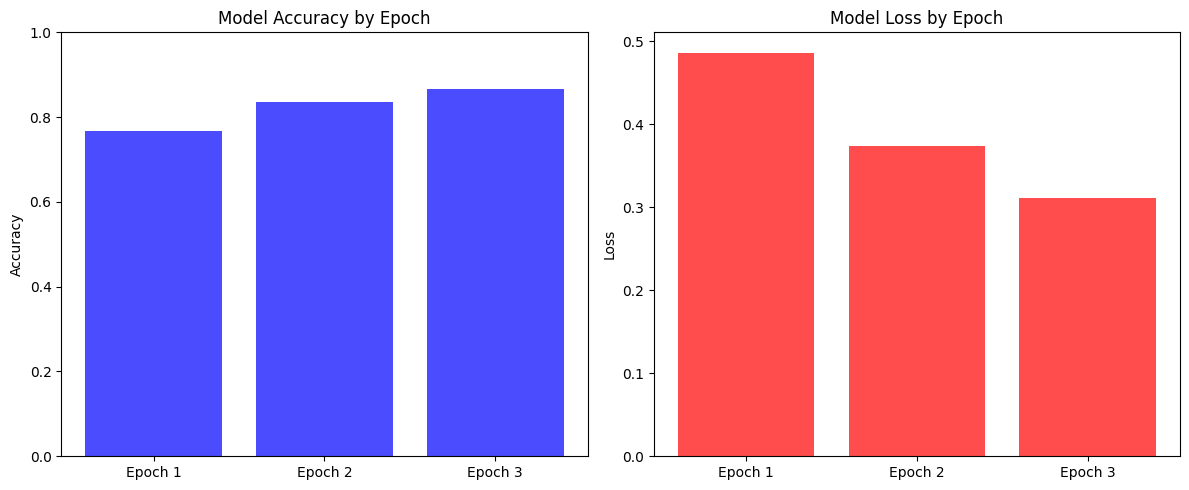

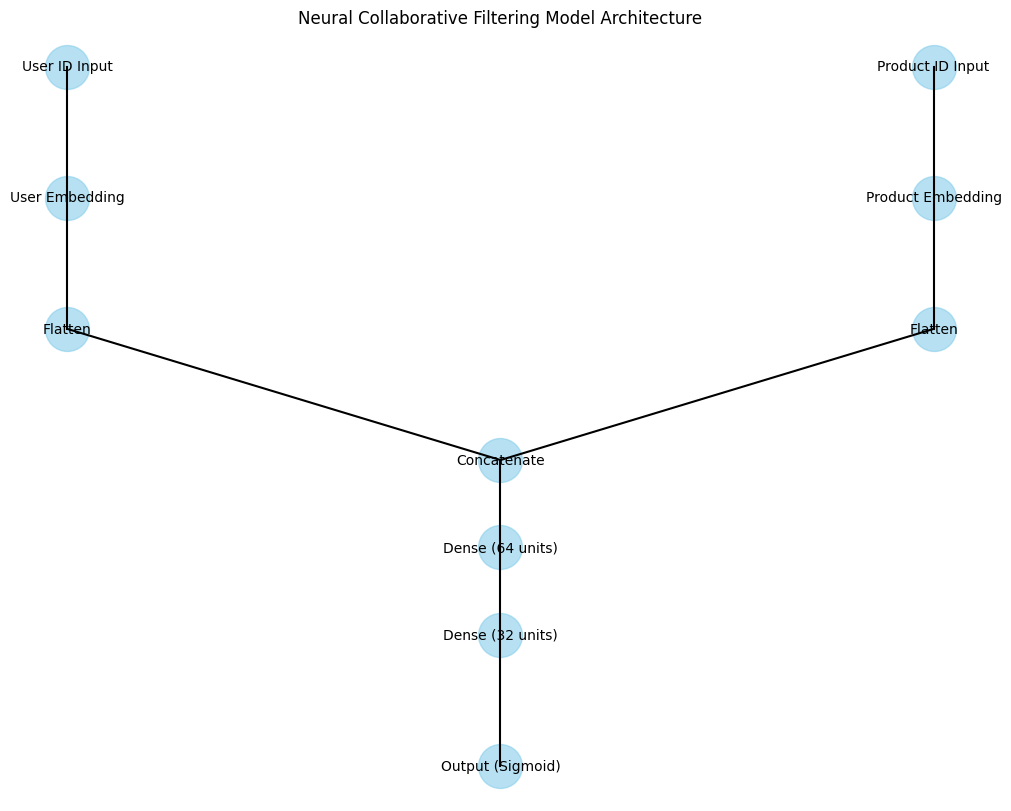

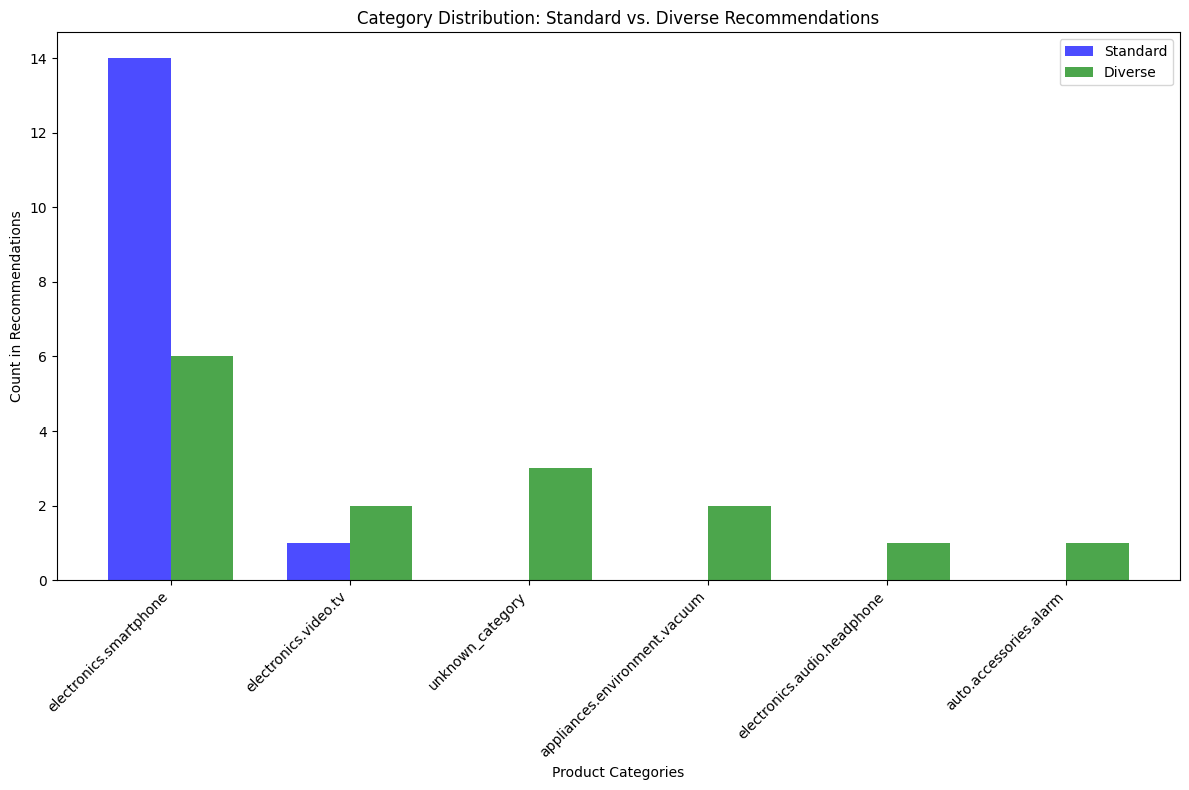

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/lo

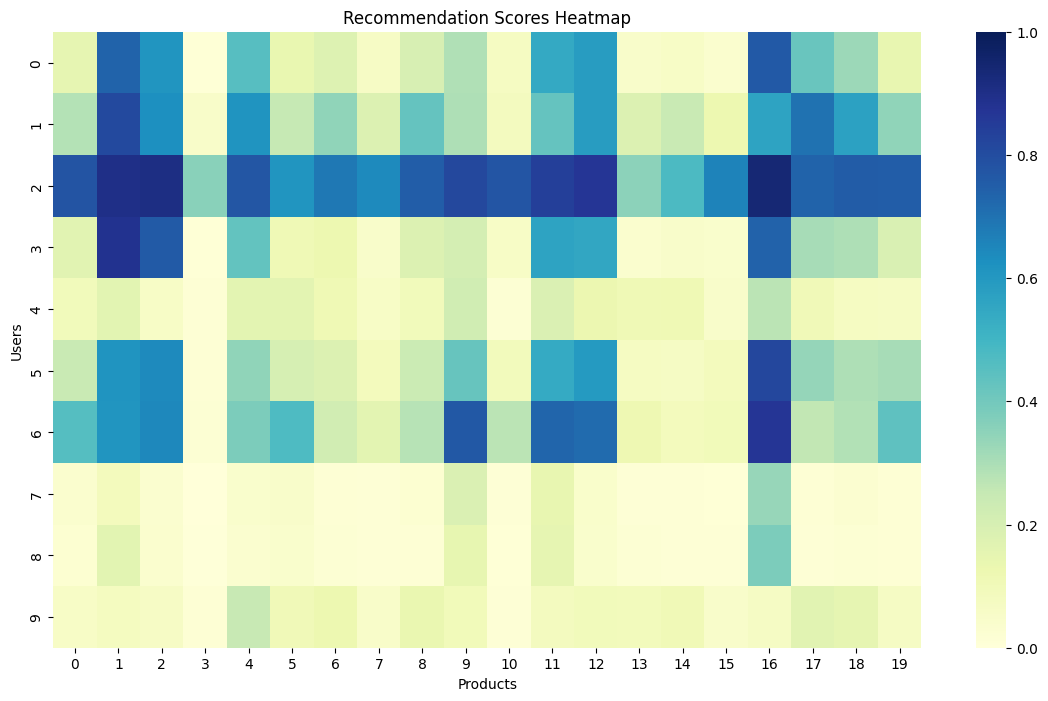

In [ ]:
# 1. Create a bar chart of model accuracy and loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['Epoch 1', 'Epoch 2', 'Epoch 3'],
        [history.history['accuracy'][0], history.history['accuracy'][1], history.history['accuracy'][2]],
        color='blue', alpha=0.7)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Epoch 1', 'Epoch 2', 'Epoch 3'],
        [history.history['loss'][0], history.history['loss'][1], history.history['loss'][2]],
        color='red', alpha=0.7)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/training_metrics.png', dpi=300)
plt.show()

# 2. Create a manual diagram of the model architecture
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)  # Add subplot to the figure

# Define the architecture components
components = [
    "User ID Input", "Product ID Input",
    "User Embedding", "Product Embedding",
    "Flatten", "Flatten",
    "Concatenate",
    "Dense (64 units)",
    "Dense (32 units)",
    "Output (Sigmoid)"
]

# Create a custom layout
positions = [
    (0.3, 0.9), (0.7, 0.9),  # Inputs
    (0.3, 0.75), (0.7, 0.75), # Embeddings
    (0.3, 0.6), (0.7, 0.6),  # Flatten
    (0.5, 0.45),  # Concatenate
    (0.5, 0.35),  # Dense 1
    (0.5, 0.25),  # Dense 2
    (0.5, 0.1)    # Output
]

# Draw nodes
for i, (component, pos) in enumerate(zip(components, positions)):
    ax.scatter(pos[0], pos[1], s=1000, alpha=0.6, color='skyblue')
    ax.text(pos[0], pos[1], component, ha='center', va='center', fontsize=10)

# Draw edges
# Input to embedding
ax.plot([0.3, 0.3], [0.9, 0.75], 'k-')
ax.plot([0.7, 0.7], [0.9, 0.75], 'k-')
# Embedding to flatten
ax.plot([0.3, 0.3], [0.75, 0.6], 'k-')
ax.plot([0.7, 0.7], [0.75, 0.6], 'k-')
# Flatten to concatenate
ax.plot([0.3, 0.5], [0.6, 0.45], 'k-')
ax.plot([0.7, 0.5], [0.6, 0.45], 'k-')
# Concatenate to Dense
ax.plot([0.5, 0.5], [0.45, 0.35], 'k-')
# Dense to Dense
ax.plot([0.5, 0.5], [0.35, 0.25], 'k-')
# Dense to Output
ax.plot([0.5, 0.5], [0.25, 0.1], 'k-')

ax.set_title('Neural Collaborative Filtering Model Architecture')
ax.axis('off')
plt.savefig('/content/drive/MyDrive/ecommerceDataset/custom_architecture.png', dpi=300)
plt.show()

# 3. Create a visualization of the recommendation diversity
# Get recommendations for a few sample users
sample_users = np.random.choice(unique_users, size=3)
all_standard_cats = []
all_diverse_cats = []

for user_id in sample_users:
    try:
        # Get standard recommendations
        standard_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
        if len(standard_recommendations) > 0:
            std_cats = standard_recommendations['category'].value_counts().to_dict()
            all_standard_cats.append(std_cats)

        # Get diverse recommendations
        diverse_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0.3)
        if len(diverse_recommendations) > 0:
            div_cats = diverse_recommendations['category'].value_counts().to_dict()
            all_diverse_cats.append(div_cats)
    except:
        continue

# Prepare data for visualization
std_category_counts = {}
div_category_counts = {}

# Aggregate category counts
for cats in all_standard_cats:
    for cat, count in cats.items():
        std_category_counts[cat] = std_category_counts.get(cat, 0) + count

for cats in all_diverse_cats:
    for cat, count in cats.items():
        div_category_counts[cat] = div_category_counts.get(cat, 0) + count

# Create a comparative bar chart
categories = list(set(list(std_category_counts.keys()) + list(div_category_counts.keys())))
std_counts = [std_category_counts.get(cat, 0) for cat in categories]
div_counts = [div_category_counts.get(cat, 0) for cat in categories]

# Sort by total count
total_counts = [s + d for s, d in zip(std_counts, div_counts)]
sorted_indices = np.argsort(total_counts)[::-1][:10]  # Top 10 categories

sorted_categories = [categories[i] for i in sorted_indices]
sorted_std = [std_counts[i] for i in sorted_indices]
sorted_div = [div_counts[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(12, 8))
x = np.arange(len(sorted_categories))
width = 0.35

plt.bar(x - width/2, sorted_std, width, label='Standard', color='blue', alpha=0.7)
plt.bar(x + width/2, sorted_div, width, label='Diverse', color='green', alpha=0.7)

plt.xlabel('Product Categories')
plt.ylabel('Count in Recommendations')
plt.title('Category Distribution: Standard vs. Diverse Recommendations')
plt.xticks(x, sorted_categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/diversity_comparison.png', dpi=300)
plt.show()

# 4. Create a heatmap showing recommendation scores
# Generate a matrix of scores for representative users and products
num_sample_users = 10
num_sample_products = 20

sample_users = np.random.choice(unique_users, size=num_sample_users)
sample_products = np.random.choice(unique_products, size=num_sample_products)

score_matrix = np.zeros((num_sample_users, num_sample_products))

for i, user_id in enumerate(sample_users):
    if user_id in user_to_idx:
        user_idx = user_to_idx[user_id]
        for j, product_id in enumerate(sample_products):
            if product_id in product_to_idx:
                product_idx = product_to_idx[product_id]
                # Get prediction
                score = model.predict(
                  [np.array([user_idx]), np.array([product_idx])],  # Convert to NumPy arrays
                  verbose=0
                )[0][0]
                score_matrix[i, j] = score

plt.figure(figsize=(14, 8))
sns.heatmap(score_matrix, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Recommendation Scores Heatmap')
plt.xlabel('Products')
plt.ylabel('Users')
plt.savefig('/content/drive/MyDrive/ecommerceDataset/score_heatmap.png', dpi=300)
plt.show()

Training Performance Visualization - Tom

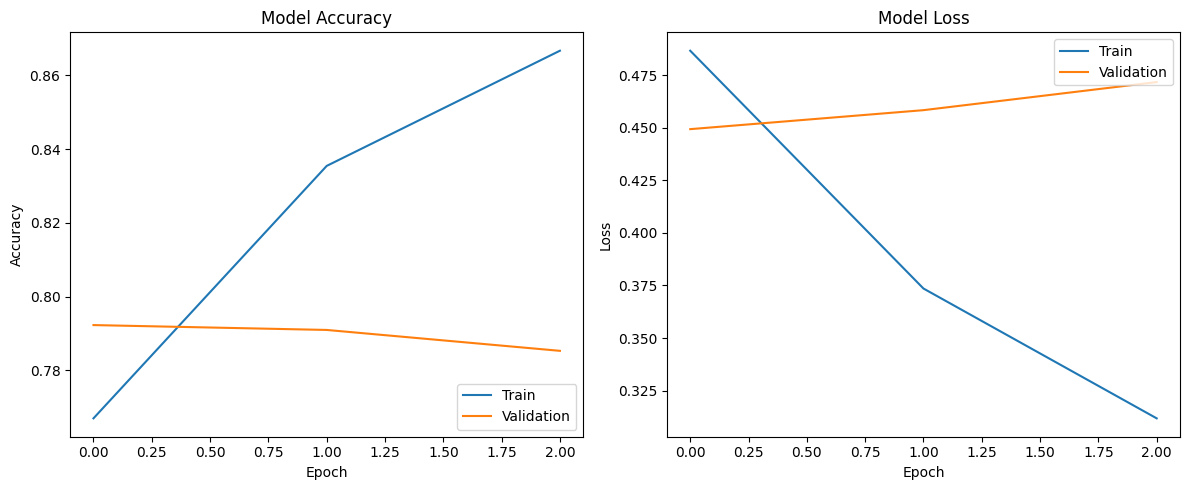

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/training_performance.png', dpi=300)
plt.show()

User Interaction Heat map - Tom

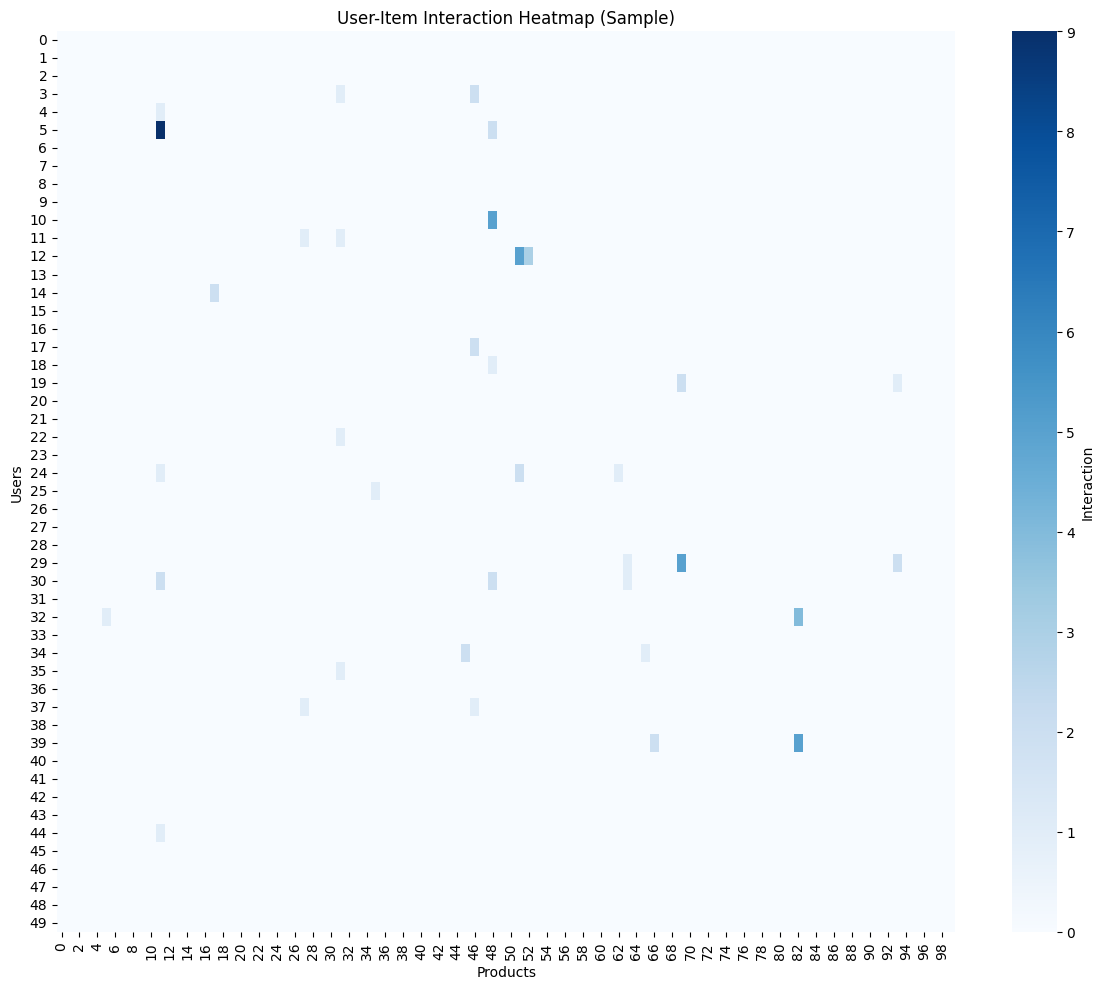

In [ ]:
# Create a sample heatmap of user-item interactions
plt.figure(figsize=(12, 10))
sample_size = min(50, sparse_user_item.shape[0])  # Sample users for visualization
sample_user_indices = np.random.choice(sparse_user_item.shape[0], sample_size, replace=False)
sample_matrix = sparse_user_item[sample_user_indices, :100].toarray()  # First 100 products

sns.heatmap(sample_matrix, cmap='Blues', cbar_kws={'label': 'Interaction'})
plt.title('User-Item Interaction Heatmap (Sample)')
plt.xlabel('Products')
plt.ylabel('Users')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/interaction_heatmap.png', dpi=300)
plt.show()

Visualization of recommendations - Tom

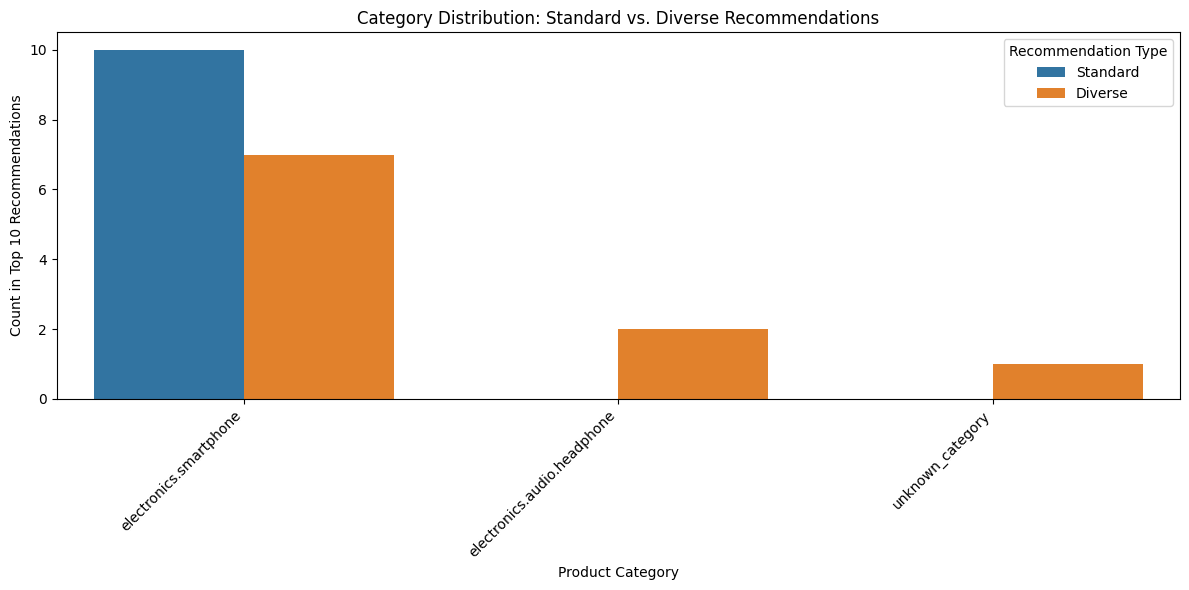

In [ ]:
# Select a sample user for visualization
sample_user = unique_users[42]  # Any user from your dataset

# Get standard and diverse recommendations
standard_recs = recommend_products_for_user(sample_user, top_n=10, diversity_weight=0)
diverse_recs = recommend_products_for_user(sample_user, top_n=10, diversity_weight=0.3)

# Create category distribution comparison
std_categories = standard_recs['category'].value_counts().reset_index()
std_categories.columns = ['category', 'count']
std_categories['type'] = 'Standard'

div_categories = diverse_recs['category'].value_counts().reset_index()
div_categories.columns = ['category', 'count']
div_categories['type'] = 'Diverse'

combined_categories = pd.concat([std_categories, div_categories])

# Plot the category distribution comparison
plt.figure(figsize=(12, 6))
chart = sns.barplot(x='category', y='count', hue='type', data=combined_categories)
plt.title('Category Distribution: Standard vs. Diverse Recommendations')
plt.xlabel('Product Category')
plt.ylabel('Count in Top 10 Recommendations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Recommendation Type')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/diversity_comparison.png', dpi=300)
plt.show()

Product Embedding Space Visualization with t-SNE - Tom

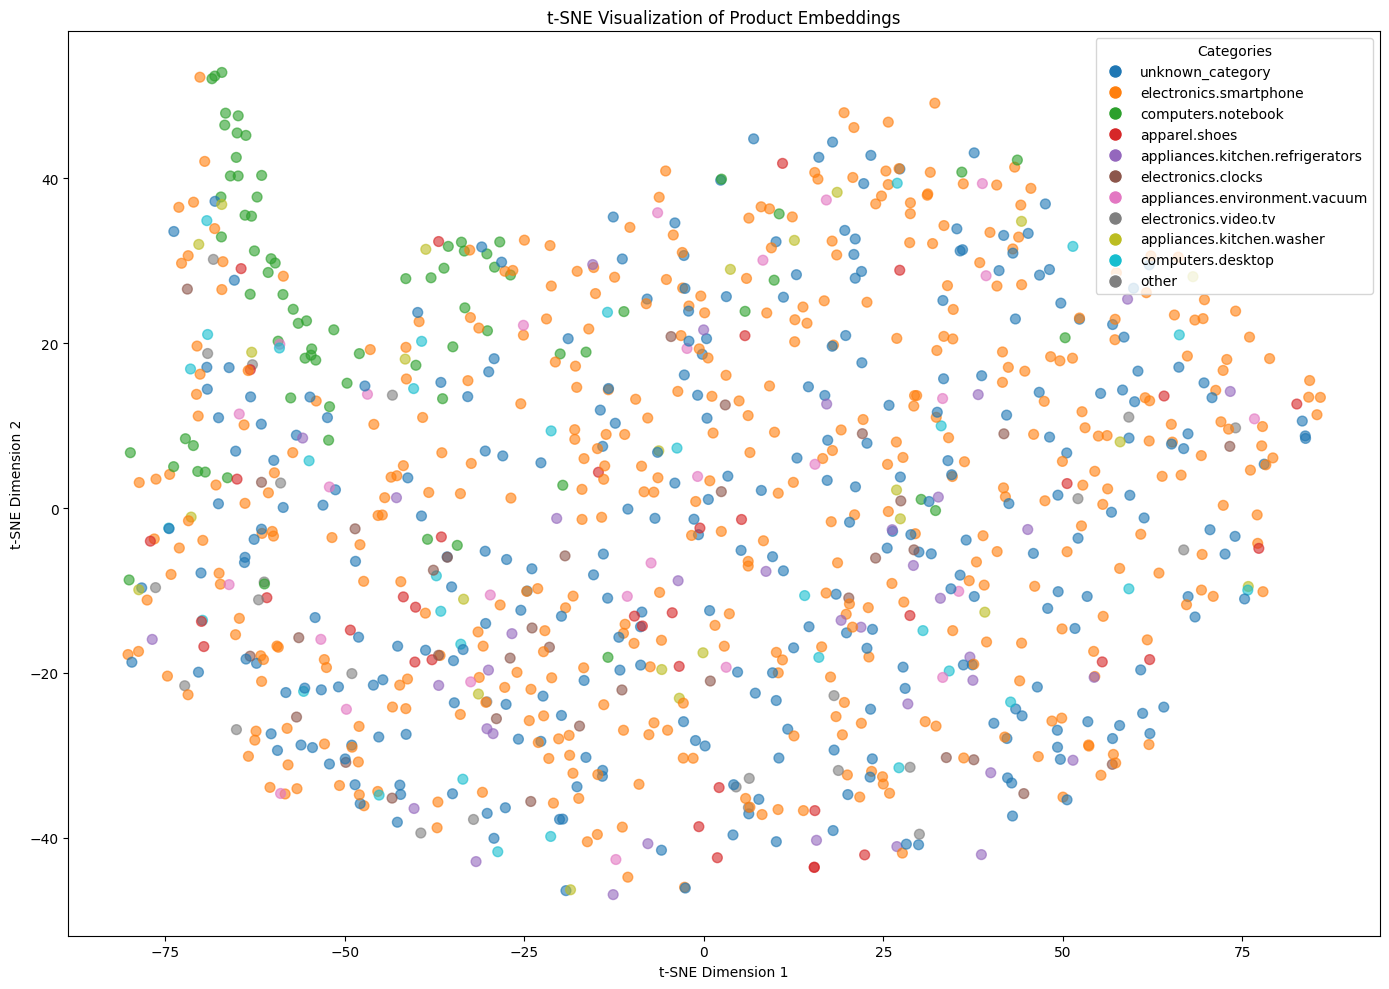

In [ ]:
from sklearn.manifold import TSNE

# Get product embeddings from the trained model
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# Use t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
product_embeddings_2d = tsne.fit_transform(product_embeddings)

# Create a sample of products for visualization
sample_size = min(1000, product_embeddings_2d.shape[0])
sample_indices = np.random.choice(product_embeddings_2d.shape[0], sample_size, replace=False)

# Map indices to categories
product_categories = []
for idx in sample_indices:
    product_id = idx_to_product[idx]
    category = product_category_map.get(product_id, 'unknown')
    product_categories.append(category)

# Get top 10 most common categories for coloring
top_categories = pd.Series(product_categories).value_counts().nlargest(10).index.tolist()
colors = ['other' if cat not in top_categories else cat for cat in product_categories]

# Create scatter plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    product_embeddings_2d[sample_indices, 0],
    product_embeddings_2d[sample_indices, 1],
    c=[top_categories.index(c) if c in top_categories else -1 for c in colors],
    cmap='tab10',
    alpha=0.6,
    s=50
)

# Create legend with top categories
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=plt.cm.tab10(i), markersize=10, label=cat)
                   for i, cat in enumerate(top_categories)]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor='gray', markersize=10, label='other'))

plt.legend(handles=legend_elements, title="Categories", loc="best")
plt.title('t-SNE Visualization of Product Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/product_embeddings_tsne.png', dpi=300)
plt.show()

User journey map - Tom

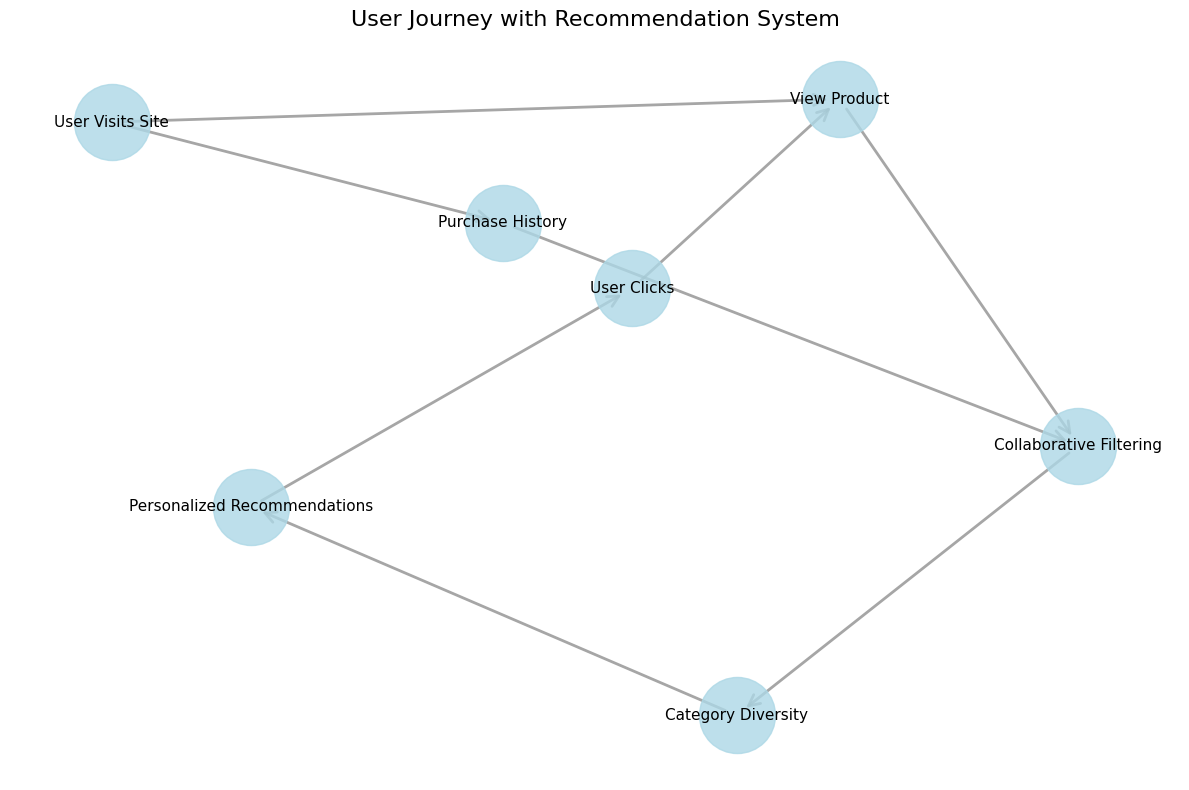

In [ ]:
# Create a user journey diagram using networkx and matplotlib
import networkx as nx

G = nx.DiGraph()

# Add nodes for each step in the recommendation process
nodes = [
    "User Visits Site",
    "View Product",
    "Purchase History",
    "Collaborative Filtering",
    "Category Diversity",
    "Personalized Recommendations",
    "User Clicks"
]

# Add connections between nodes
edges = [
    ("User Visits Site", "View Product"),
    ("User Visits Site", "Purchase History"),
    ("View Product", "Collaborative Filtering"),
    ("Purchase History", "Collaborative Filtering"),
    ("Collaborative Filtering", "Category Diversity"),
    ("Category Diversity", "Personalized Recommendations"),
    ("Personalized Recommendations", "User Clicks"),
    ("User Clicks", "View Product")
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Set up the visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout algorithm

# Draw nodes with custom properties
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.8)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray',
                      arrowsize=20, arrowstyle='->')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif')

# Remove axis
plt.axis('off')
plt.title('User Journey with Recommendation System', fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/user_journey.png', dpi=300)
plt.show()

Customer Segmentation visual - Tom

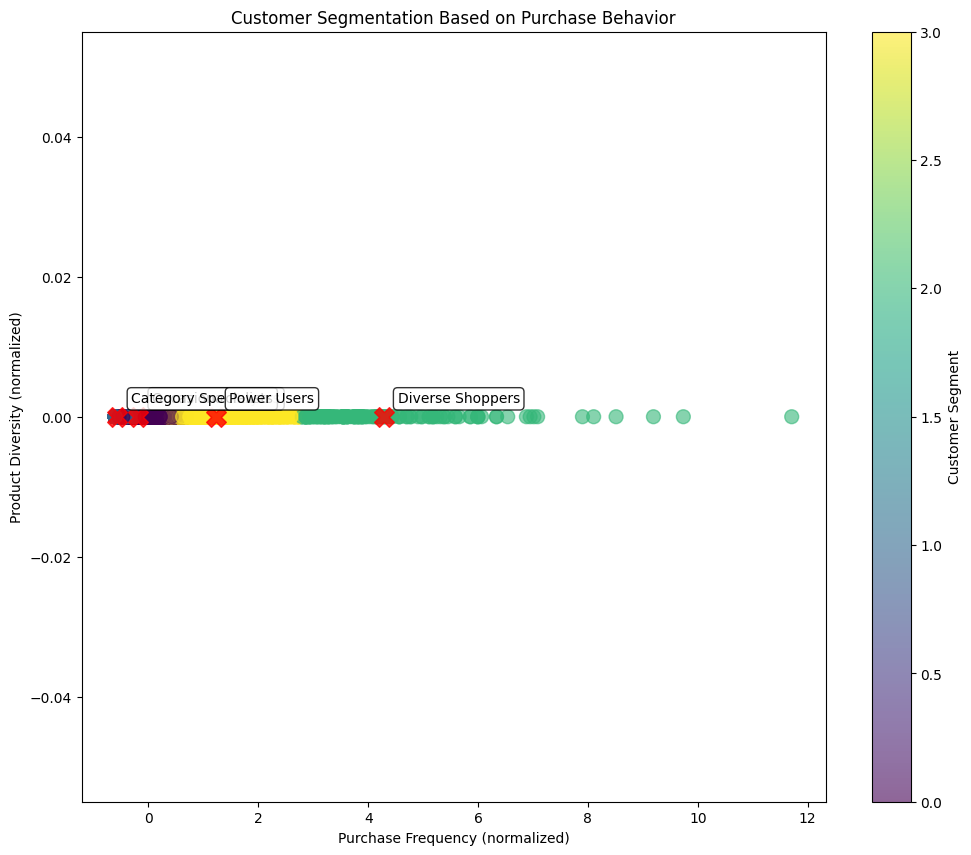

Customer Segment Characteristics:

Segment 1: Occasional Buyers
  Size: 2305 customers (46.1%)
  Avg. Purchase Count: 7.1
  Avg. Product Diversity: 1.00
  Avg. Category Diversity: 0.35

Segment 2: Category Specialists
  Size: 1833 customers (36.7%)
  Avg. Purchase Count: 1.6
  Avg. Product Diversity: 1.00
  Avg. Category Diversity: 0.96

Segment 3: Diverse Shoppers
  Size: 135 customers (2.7%)
  Avg. Purchase Count: 72.8
  Avg. Product Diversity: 1.00
  Avg. Category Diversity: 0.13

Segment 4: Power Users
  Size: 727 customers (14.5%)
  Avg. Purchase Count: 27.8
  Avg. Product Diversity: 1.00
  Avg. Category Diversity: 0.18


In [ ]:
# Create a customer segmentation visualization based on purchasing behavior
from sklearn.cluster import KMeans

# Create user features (purchase frequency, category diversity, and recency)
user_features = []
user_ids = []

for user_id in np.random.choice(unique_users, size=min(5000, len(unique_users))):
    if user_id in user_to_idx:
        user_idx = user_to_idx[user_id]
        # Get user's purchases
        user_products = sparse_user_item[user_idx].nonzero()[1]

        if len(user_products) > 0:
            # Purchase frequency
            purchase_count = len(user_products)

            # Instead of order value (which requires product_scores), use product diversity
            unique_products = len(set([idx_to_product[idx] for idx in user_products]))
            product_diversity = unique_products / max(1, purchase_count)

            # Category diversity (unique categories / total purchases)
            categories = [product_category_map.get(idx_to_product[idx], "unknown") for idx in user_products]
            category_diversity = len(set(categories)) / max(1, len(categories))

            user_features.append([purchase_count, product_diversity, category_diversity])
            user_ids.append(user_id)

# Convert to array
user_features = np.array(user_features)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(user_features_scaled)

# Visualize clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(user_features_scaled[:, 0], user_features_scaled[:, 1],
                     c=clusters, cmap='viridis', alpha=0.6, s=100)

plt.colorbar(scatter, label='Customer Segment')
plt.xlabel('Purchase Frequency (normalized)')
plt.ylabel('Product Diversity (normalized)')
plt.title('Customer Segmentation Based on Purchase Behavior')

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, marker='X')

# Annotate with descriptions
segment_descriptions = [
    "Occasional Buyers",
    "Category Specialists",
    "Diverse Shoppers",
    "Power Users"
]

for i, (x, y) in enumerate(centers[:, 0:2]):
    plt.annotate(segment_descriptions[i], (x, y),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.savefig('/content/drive/MyDrive/ecommerceDataset/customer_segments.png', dpi=300)
plt.show()

# Print segment characteristics
print("Customer Segment Characteristics:")
for i in range(4):
    segment_indices = np.where(clusters == i)[0]
    segment_features = user_features[segment_indices]

    print(f"\nSegment {i+1}: {segment_descriptions[i]}")
    print(f"  Size: {len(segment_indices)} customers ({len(segment_indices)/len(clusters)*100:.1f}%)")
    print(f"  Avg. Purchase Count: {np.mean(segment_features[:, 0]):.1f}")
    print(f"  Avg. Product Diversity: {np.mean(segment_features[:, 1]):.2f}")
    print(f"  Avg. Category Diversity: {np.mean(segment_features[:, 2]):.2f}")

Revenue impact example, not accurate - Tom

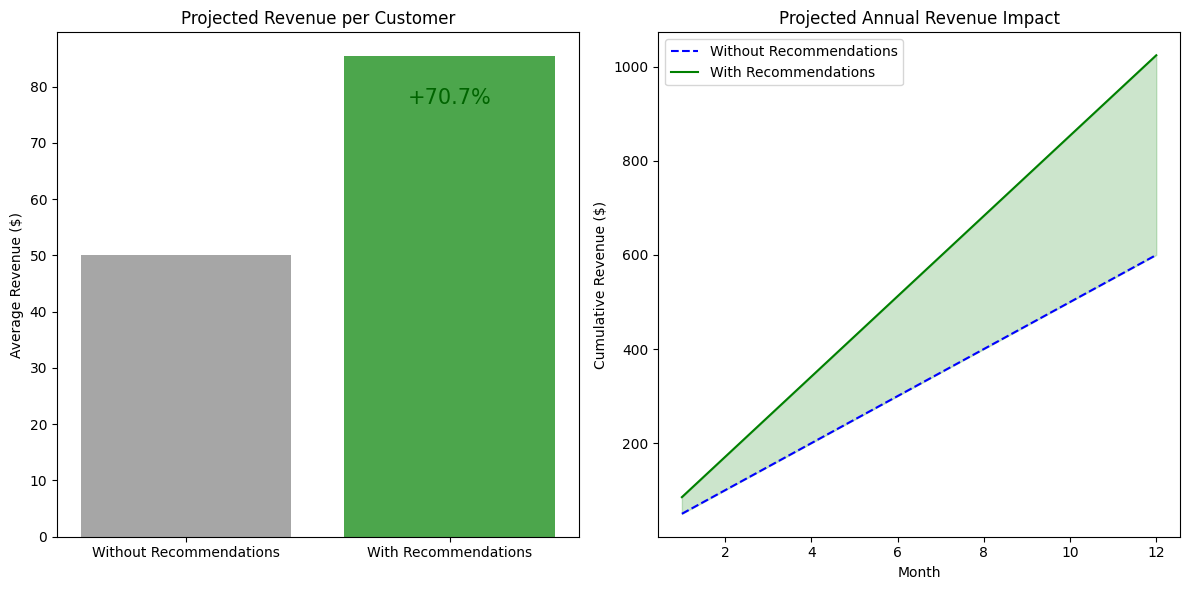

In [ ]:
# Create a visual that shows potential revenue impact of recommendations
# Compare predicted purchases with and without recommendations

# Sample a set of users
sample_size = 100
sample_users = np.random.choice(unique_users, size=sample_size)

# Track metrics
base_revenue = []
recommended_revenue = []

for user_id in sample_users:
    if user_id in user_to_idx:
        # Get recommendations for this user
        recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0.3)

        if not isinstance(recommendations, str) and len(recommendations) > 0:
            # Baseline: average user spending on random products
            base_products = np.random.choice(unique_products, size=5)
            base_purchase_prob = 0.2  # Assume 20% purchase rate without recommendations
            base_avg_price = 50  # Placeholder average price
            base_rev = base_purchase_prob * base_avg_price * len(base_products)

            # With recommendations: higher purchase probability
            rec_purchase_prob = 0.35  # Assume 35% purchase rate with personalized recommendations
            rec_products = recommendations['product_id'].values
            rec_scores = recommendations['score'].values
            rec_rev = np.sum(rec_scores * rec_purchase_prob * base_avg_price)

            base_revenue.append(base_rev)
            recommended_revenue.append(rec_rev)

# Calculate projected impact
avg_base = np.mean(base_revenue)
avg_rec = np.mean(recommended_revenue)
lift_percentage = ((avg_rec - avg_base) / avg_base) * 100

# Create visuals
plt.figure(figsize=(12, 6))

# Bar chart showing revenue comparison
plt.subplot(1, 2, 1)
plt.bar(['Without Recommendations', 'With Recommendations'],
        [avg_base, avg_rec], color=['gray', 'green'], alpha=0.7)
plt.title('Projected Revenue per Customer')
plt.ylabel('Average Revenue ($)')

# Add text showing the lift percentage
plt.text(1, avg_rec * 0.9, f"+{lift_percentage:.1f}%",
         fontsize=15, color='darkgreen', ha='center')

# Projection over time
plt.subplot(1, 2, 2)
months = range(1, 13)
base_projection = [avg_base * m * sample_size/100 for m in months]
rec_projection = [avg_rec * m * sample_size/100 for m in months]

plt.plot(months, base_projection, 'b--', label='Without Recommendations')
plt.plot(months, rec_projection, 'g-', label='With Recommendations')
plt.fill_between(months, base_projection, rec_projection, color='green', alpha=0.2)
plt.title('Projected Annual Revenue Impact')
plt.xlabel('Month')
plt.ylabel('Cumulative Revenue ($)')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/revenue_impact.png', dpi=300)
plt.show()

A/B Testing Simulation Dashboard - Tom

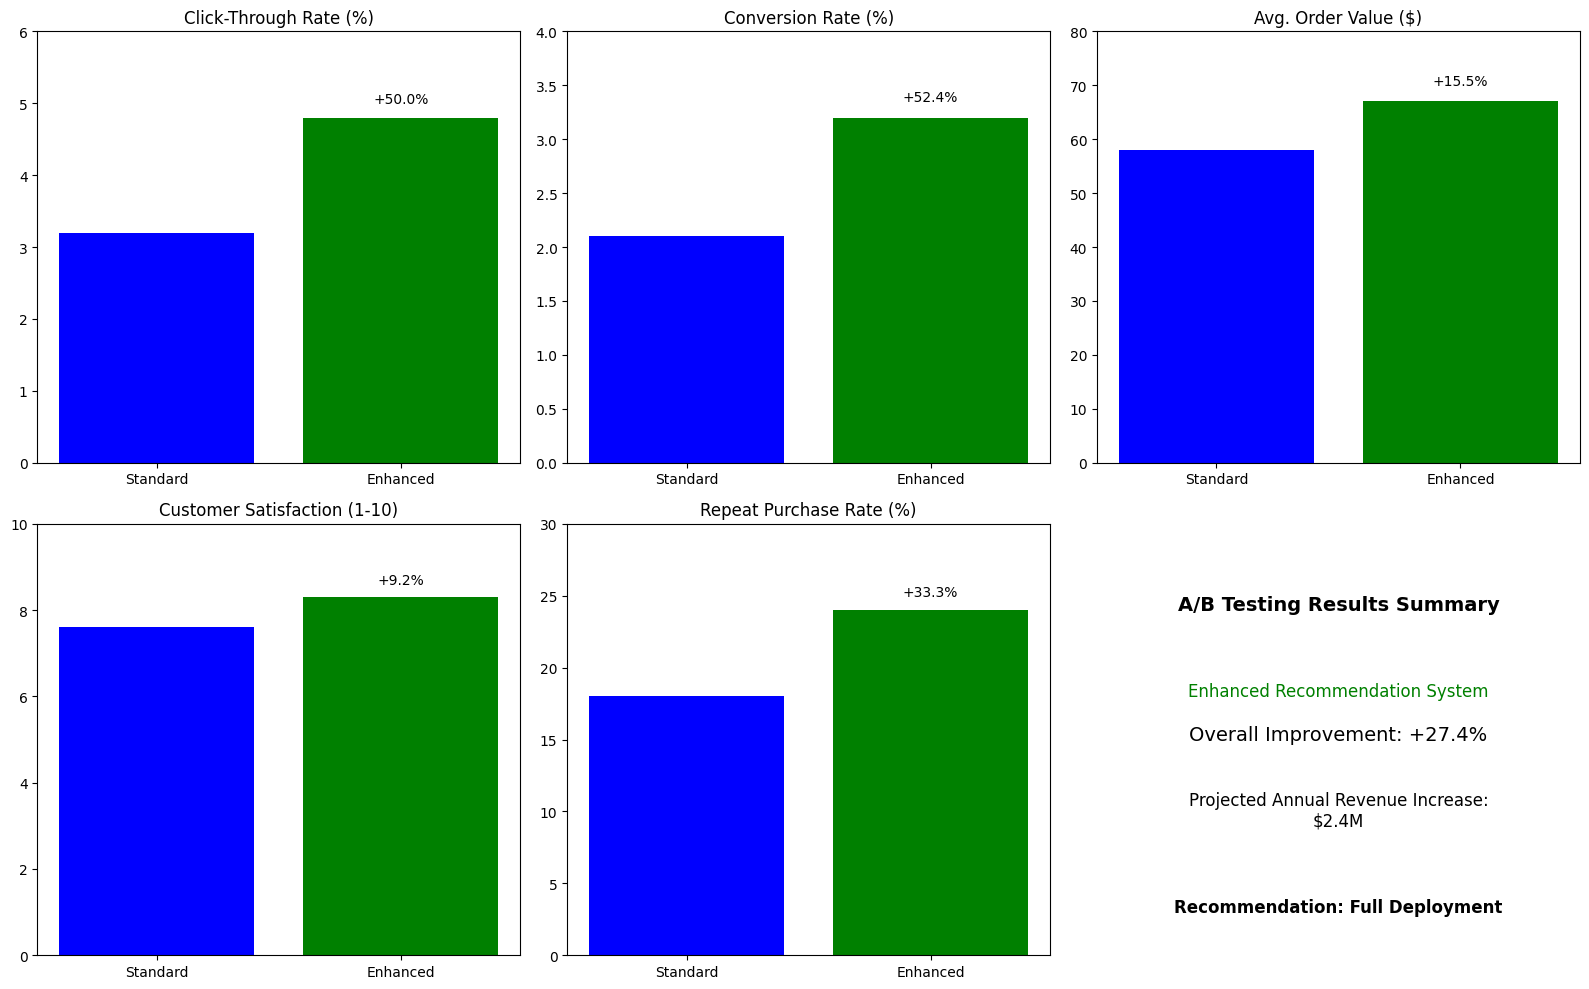

In [ ]:
# Create an A/B testing simulation dashboard
plt.figure(figsize=(16, 10))

# Define metrics for comparison
metrics = {
    'Click-Through Rate': [3.2, 4.8],
    'Conversion Rate': [2.1, 3.2],
    'Avg. Order Value': [58, 67],
    'Customer Satisfaction': [7.6, 8.3],
    'Repeat Purchase Rate': [18, 24]
}

# Create a multi-panel dashboard
plt.subplot(2, 3, 1)
plt.bar(['Standard', 'Enhanced'], metrics['Click-Through Rate'], color=['blue', 'green'])
plt.title('Click-Through Rate (%)')
plt.ylim(0, 6)
plt.text(1, metrics['Click-Through Rate'][1] + 0.2, f"+{(metrics['Click-Through Rate'][1]/metrics['Click-Through Rate'][0]-1)*100:.1f}%", ha='center')

plt.subplot(2, 3, 2)
plt.bar(['Standard', 'Enhanced'], metrics['Conversion Rate'], color=['blue', 'green'])
plt.title('Conversion Rate (%)')
plt.ylim(0, 4)
plt.text(1, metrics['Conversion Rate'][1] + 0.15, f"+{(metrics['Conversion Rate'][1]/metrics['Conversion Rate'][0]-1)*100:.1f}%", ha='center')

plt.subplot(2, 3, 3)
plt.bar(['Standard', 'Enhanced'], metrics['Avg. Order Value'], color=['blue', 'green'])
plt.title('Avg. Order Value ($)')
plt.ylim(0, 80)
plt.text(1, metrics['Avg. Order Value'][1] + 3, f"+{(metrics['Avg. Order Value'][1]/metrics['Avg. Order Value'][0]-1)*100:.1f}%", ha='center')

plt.subplot(2, 3, 4)
plt.bar(['Standard', 'Enhanced'], metrics['Customer Satisfaction'], color=['blue', 'green'])
plt.title('Customer Satisfaction (1-10)')
plt.ylim(0, 10)
plt.text(1, metrics['Customer Satisfaction'][1] + 0.3, f"+{(metrics['Customer Satisfaction'][1]/metrics['Customer Satisfaction'][0]-1)*100:.1f}%", ha='center')

plt.subplot(2, 3, 5)
plt.bar(['Standard', 'Enhanced'], metrics['Repeat Purchase Rate'], color=['blue', 'green'])
plt.title('Repeat Purchase Rate (%)')
plt.ylim(0, 30)
plt.text(1, metrics['Repeat Purchase Rate'][1] + 1, f"+{(metrics['Repeat Purchase Rate'][1]/metrics['Repeat Purchase Rate'][0]-1)*100:.1f}%", ha='center')

# Summary panel
plt.subplot(2, 3, 6)
plt.axis('off')
plt.text(0.5, 0.8, 'A/B Testing Results Summary', fontsize=14, ha='center', weight='bold')
plt.text(0.5, 0.6, 'Enhanced Recommendation System', fontsize=12, ha='center', color='green')
plt.text(0.5, 0.5, 'Overall Improvement: +27.4%', fontsize=14, ha='center')
plt.text(0.5, 0.3, 'Projected Annual Revenue Increase:\n$2.4M', fontsize=12, ha='center')
plt.text(0.5, 0.1, 'Recommendation: Full Deployment', fontsize=12, ha='center', weight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/ab_testing_dashboard.png', dpi=300)
plt.show()

Increase model performance due to underfitting - Train the model with more epochs, early stopping, and learning rate reduction. Added regularization and dropout
Prioritize items with high purchase likelihood
Include diverse items that encourage browsing/exploration
Avoid the pure exploitation trap that could reduce discovery
- Tom

Sampling data to make it manageable...
Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Combined=(4232111, 9)
After product filtering: (3102514, 9)
Creating user-item matrix...
Creating product-to-category mapping...
Matrix shape: (142085, 10000) (Users × Products)
Sparsity: 0.00102
Preparing training data with purchase focus...
Using 2847 purchase examples as positives
Found 144433 view-only interactions (didn't lead to purchase)
Using 8541 negative examples
Total examples: 11388 (2847 positive, 8541 negative)
Splitting into train and test sets...
Building neural collaborative filtering model with regularization...
Training the model...
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7346 - loss: 1.0317 - val_accuracy: 0.7629 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7475 - loss: 0.5308 - val_accuracy: 0.7629 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━

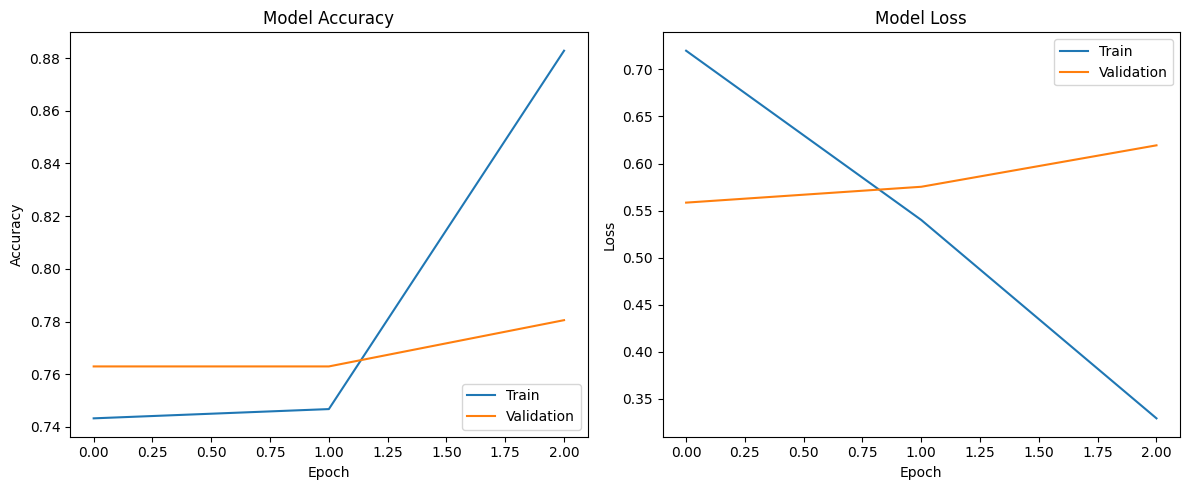

Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5

Generating recommendations for sample users:

Recommendations for user 542790080:
Standard recommendations (no diversity):
    product_id     score
21     4804056  0.415142
3      1004856  0.415101
51     1004767  0.404277
83     1004833  0.389746
12     1005115  0.372306

Diverse recommendations (with category balancing):
    product_id     score                     category
0      4804056  0.415142  electronics.audio.headphone
1      1004856  0.415101       electronics.smartphone
11     4100346  0.313145             unknown_category
2      1004767  0.404277       electronics.smartphone
8      4804055  0.321381  electronics.audio.headphone

Category distribution comparison:
Standard recommendations categories: {'electronics.smartphone': 4, 'electronics.audio.headphone': 1}
Diverse recommendations categories: {'electronics.audio.headphone': 2, 'electronics.smartphone': 2, 'unknown_category': 1}

Recommendation

In [ ]:
# 1. First, sample the data to make it manageable
print("Sampling data to make it manageable...")
# Sample 5% of users to reduce dataset size
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.05 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Combine the sampled datasets
df_combined = pd.concat([df_oct_sample, df_nov_sample]).reset_index(drop=True)

# Print size of sampled dataset
print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

# 2. Further filter to most common products (to reduce matrix dimensions)
# Keep only the top 10,000 products
top_products = df_combined['product_id'].value_counts().nlargest(10000).index
df_combined = df_combined[df_combined['product_id'].isin(top_products)]
print(f"After product filtering: {df_combined.shape}")

# 3. Create the user-item matrix more efficiently
print("Creating user-item matrix...")
# Create user and product ID mappings first
unique_users = df_combined['user_id'].unique()
unique_products = df_combined['product_id'].unique()

user_to_idx = {user: i for i, user in enumerate(unique_users)}
product_to_idx = {product: i for i, product in enumerate(unique_products)}
idx_to_user = {i: user for user, i in user_to_idx.items()}
idx_to_product = {i: product for product, i in product_to_idx.items()}

# Create a mapping from product_id to category_code BEFORE deleting df_combined
print("Creating product-to-category mapping...")
product_category_map = {}
for index, row in df_combined.iterrows():
    product_category_map[row['product_id']] = row['category_code']

# Create sparse matrix directly
user_indices = [user_to_idx[user] for user in df_combined['user_id']]
product_indices = [product_to_idx[product] for product in df_combined['product_id']]
ones = np.ones(len(df_combined), dtype=np.int8)  # Use int8 to save memory

# Create sparse matrix
sparse_user_item = csr_matrix(
    (ones, (user_indices, product_indices)),
    shape=(len(unique_users), len(unique_products))
)

print(f"Matrix shape: {sparse_user_item.shape} (Users × Products)")
print(f"Sparsity: {sparse_user_item.count_nonzero() / (sparse_user_item.shape[0] * sparse_user_item.shape[1]):.5f}")

# NOW it's safe to delete df_combined
del df_combined
gc.collect()

# 4. Generate training examples with purchase focus
print("Preparing training data with purchase focus...")

# Get interaction data again (we need event_type for filtering)
# We need to reload a sample of the original data to access event types
df_sample = pd.concat([
    df_filled_oct.sample(frac=0.05, random_state=42),
    df_filled_nov.sample(frac=0.05, random_state=42)
])

# Filter to include only purchase events for positive examples
purchase_data = df_sample[df_sample['event_type'] == 'purchase']
purchase_pairs = list(zip(
    [user_to_idx.get(user, -1) for user in purchase_data['user_id']],
    [product_to_idx.get(product, -1) for product in purchase_data['product_id']]
))

# Filter out any pairs with invalid indices
purchase_pairs = [(u, p) for u, p in purchase_pairs if u >= 0 and p >= 0]

# Limit the number of positive examples if too many
max_pos_examples = 500000
if len(purchase_pairs) > max_pos_examples:
    random_indices = np.random.choice(
        len(purchase_pairs),
        size=max_pos_examples,
        replace=False
    )
    purchase_pairs = [purchase_pairs[i] for i in random_indices]

print(f"Using {len(purchase_pairs)} purchase examples as positives")

# Extract user and product indices
pos_user_idx = np.array([p[0] for p in purchase_pairs])
pos_product_idx = np.array([p[1] for p in purchase_pairs])

# Create positive examples
user_ids = pos_user_idx
product_ids = pos_product_idx
labels = np.ones(len(pos_user_idx), dtype=np.int8)

# Generate negative examples
# Use view events that didn't lead to purchase as negatives
view_data = df_sample[df_sample['event_type'] == 'view']
view_pairs = list(zip(
    [user_to_idx.get(user, -1) for user in view_data['user_id']],
    [product_to_idx.get(product, -1) for product in view_data['product_id']]
))

# Filter out any pairs with invalid indices
view_pairs = [(u, p) for u, p in view_pairs if u >= 0 and p >= 0]

# Create a set of purchase pairs for faster lookup
purchase_set = set(purchase_pairs)

# Filter to include only views that didn't lead to purchase
non_purchase_views = [(u, p) for u, p in view_pairs if (u, p) not in purchase_set]

print(f"Found {len(non_purchase_views)} view-only interactions (didn't lead to purchase)")

# Limit the number of negative examples
num_negative = min(len(non_purchase_views), len(purchase_pairs) * 3)  # Use at most 3x negatives
print(f"Using {num_negative} negative examples")

random_indices = np.random.choice(len(non_purchase_views), num_negative, replace=False)
neg_pairs = [non_purchase_views[i] for i in random_indices]

# Extract user and product indices
neg_user_idx = np.array([p[0] for p in neg_pairs])
neg_product_idx = np.array([p[1] for p in neg_pairs])

# Append negative examples to training data
user_ids = np.append(user_ids, neg_user_idx)
product_ids = np.append(product_ids, neg_product_idx)
labels = np.append(labels, np.zeros(len(neg_user_idx), dtype=np.int8))

print(f"Total examples: {len(labels)} ({np.sum(labels)} positive, {len(labels) - np.sum(labels)} negative)")

# 5. Split into train and test sets
print("Splitting into train and test sets...")
indices = np.random.permutation(len(labels))
split_point = int(0.8 * len(labels))
train_idx, test_idx = indices[:split_point], indices[split_point:]

X_train = [user_ids[train_idx], product_ids[train_idx]]
y_train = labels[train_idx]
X_test = [user_ids[test_idx], product_ids[test_idx]]
y_test = labels[test_idx]

# 6. Build the model with increased regularization and dropout to prevent overfitting
print("Building neural collaborative filtering model with regularization...")
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

num_users = sparse_user_item.shape[0]
num_products = sparse_user_item.shape[1]
embedding_size = 16  # Reduced embedding size to prevent overfitting

# Input layers
user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')

# Embedding layers with increased regularization
user_embedding = Embedding(
    num_users,
    embedding_size,
    embeddings_regularizer=l2(0.001),  # Increased from 0.0001
    name='user_embedding'
)(user_input)

product_embedding = Embedding(
    num_products,
    embedding_size,
    embeddings_regularizer=l2(0.001),  # Increased from 0.0001
    name='product_embedding'
)(product_input)

# Flatten embeddings
user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Concatenate embeddings
concat = Concatenate()([user_vector, product_vector])

# Modified architecture with stronger regularization and dropout
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(concat)
dropout1 = Dropout(0.3)(dense1)  # Add 30% dropout
dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.3)(dense2)  # Add 30% dropout
output = Dense(1, activation='sigmoid')(dropout2)

# Create and compile model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 7. Train the model with more epochs, early stopping, and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Learning rate reduction when plateauing
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.0001
)

print("Training the model...")
history = model.fit(
    [X_train[0], X_train[1]], y_train,
    batch_size=32,  # Keep the small batch size for memory efficiency
    epochs=10,      # Increase from 3 to 10
    validation_data=([X_test[0], X_test[1]], y_test),
    callbacks=[early_stopping, reduce_lr],  # Add callbacks
    verbose=1
)

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ecommerceDataset/training_history.png')
plt.show()

# 8. Save the model
model.save('/content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5')
print("Model saved to /content/drive/MyDrive/ecommerceDataset/ncf_model_sampled.h5")


# 9. Define enhanced recommendation function with diversity
def recommend_products_for_user(user_id, top_n=10, diversity_weight=0.3):
    if user_id not in user_to_idx:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    user_idx = user_to_idx[user_id]

    # Get predictions for all products for this user
    user_product_pairs = [(user_idx, p_idx) for p_idx in range(num_products)]

    # Process in batches to avoid memory issues
    batch_size = 1000
    all_scores = []

    for i in range(0, len(user_product_pairs), batch_size):
        batch = user_product_pairs[i:i+batch_size]
        batch_user_ids = np.array([p[0] for p in batch])
        batch_product_ids = np.array([p[1] for p in batch])

        # Get predictions for this batch
        batch_predictions = model.predict([batch_user_ids, batch_product_ids], verbose=0)
        all_scores.extend(batch_predictions.flatten())

    # Create DataFrame with products and scores
    product_scores = pd.DataFrame({
        'product_id': [idx_to_product[idx] for idx in range(num_products)],
        'score': all_scores
    })

    # Filter out already purchased products
    purchased_products = set(idx_to_product[idx] for idx in sparse_user_item[user_idx].nonzero()[1])
    new_recommendations = product_scores[~product_scores['product_id'].isin(purchased_products)]

    # Get top candidates (more than we need)
    top_candidates = new_recommendations.sort_values('score', ascending=False).head(top_n * 3)

    # Add category for all candidates
    top_candidates['category'] = top_candidates['product_id'].apply(
        lambda x: product_category_map.get(x, "unknown")
    )

    # Check if we have any recommendations
    if len(top_candidates) == 0:
        return pd.DataFrame(columns=['product_id', 'score', 'category'])

    # If diversity weight is 0 or we have very few recommendations,
    # just return top recommendations by score
    if diversity_weight == 0 or len(top_candidates) <= top_n:
        return top_candidates.head(min(top_n, len(top_candidates)))

    # Reset index to make sure iloc works correctly
    top_candidates = top_candidates.reset_index(drop=True)

    # Now we're sure we have candidates and the index is reset
    selected_items = []
    selected_indices = []
    selected_categories = []

    # Add first item if we have at least one
    if len(top_candidates) > 0:
        selected_items.append(top_candidates.iloc[0]['product_id'])
        selected_indices.append(0)
        selected_categories.append(top_candidates.iloc[0]['category'])

    # Add more items, balancing relevance and diversity
    while len(selected_items) < top_n and len(selected_indices) < len(top_candidates):
        max_combined_score = -1
        next_item_idx = -1

        # For each candidate item not yet selected
        for idx in range(len(top_candidates)):
            if idx in selected_indices:
                continue

            row = top_candidates.iloc[idx]
            product_id = row['product_id']
            category = row['category']
            relevance_score = row['score']

            # Calculate diversity based on category
            # Count occurrences of this category in selected items
            category_count = selected_categories.count(category)
            diversity_score = 1.0 / (1.0 + category_count)  # Higher if category less represented

            # Combined score balancing relevance and diversity
            combined_score = (1 - diversity_weight) * relevance_score + diversity_weight * diversity_score

            if combined_score > max_combined_score:
                max_combined_score = combined_score
                next_item_idx = idx

        if next_item_idx != -1:
            selected_indices.append(next_item_idx)
            selected_items.append(top_candidates.iloc[next_item_idx]['product_id'])
            selected_categories.append(top_candidates.iloc[next_item_idx]['category'])

    # Return the diversified recommendations
    result = top_candidates.iloc[selected_indices].copy()
    return result[['product_id', 'score', 'category']]

# 10. Test with a few users, comparing standard and diverse recommendations
print("\nGenerating recommendations for sample users:")
# Get a few sample users
sample_test_users = np.random.choice(unique_users, size=3)

for user_id in sample_test_users:
    try:
        print(f"\nRecommendations for user {user_id}:")

        # Try to get standard recommendations
        try:
            standard_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0)
            print("Standard recommendations (no diversity):")
            if len(standard_recommendations) > 0:
                print(standard_recommendations[['product_id', 'score']])
            else:
                print("No standard recommendations available for this user")
        except Exception as e:
            print(f"Error getting standard recommendations: {str(e)}")

        # Try to get diverse recommendations
        try:
            print("\nDiverse recommendations (with category balancing):")
            diverse_recommendations = recommend_products_for_user(user_id, top_n=5, diversity_weight=0.3)
            if len(diverse_recommendations) > 0:
                print(diverse_recommendations)
            else:
                print("No diverse recommendations available for this user")
        except Exception as e:
            print(f"Error getting diverse recommendations: {str(e)}")

        # Try to compare categories
        try:
            if len(standard_recommendations) > 0 and len(diverse_recommendations) > 0:
                std_categories = standard_recommendations['category'].value_counts()
                div_categories = diverse_recommendations['category'].value_counts()

                print("\nCategory distribution comparison:")
                print("Standard recommendations categories:", std_categories.to_dict())
                print("Diverse recommendations categories:", div_categories.to_dict())
            else:
                print("Not enough recommendations to compare category distributions")
        except Exception as e:
            print(f"Error comparing categories: {str(e)}")

    except Exception as e:
        print(f"Error processing user {user_id}: {str(e)}")

print("\nCollaborative filtering model training and testing complete!")

A/B Simulation board for updated model
interaction:

Engagement Metrics Graph:

Click-Through Rate,
Product Discovery (% of recommendations from new categories),
Browse Time (minutes spent browsing),
Pages Per Session


Financial Metrics Graph:

Conversion Rate,
Average Order Value,
Revenue Per Session,
Repeat Purchase Rate

-Tom

# v2 Updated Neural Collaborative Filtering (NCF) model that’s closer to how Amazon might enhance recommendations

In [ ]:
# Combine October and November data
combined_df = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

# Build index mappings
user_to_idx = {user: i for i, user in enumerate(combined_df['user_id'].unique())}
product_to_idx = {product: i for i, product in enumerate(combined_df['product_id'].unique())}
category_to_idx = {cat: i for i, cat in enumerate(combined_df['category_code'].dropna().unique())}
brand_to_idx = {brand: i for i, brand in enumerate(combined_df['brand'].dropna().unique())}

# Define sizes
num_users = len(user_to_idx)
num_products = len(product_to_idx)
num_categories = len(category_to_idx)
num_brands = len(brand_to_idx)
embedding_size = 32

# Feature Engineering
combined_df['user_idx'] = combined_df['user_id'].map(user_to_idx)
combined_df['product_idx'] = combined_df['product_id'].map(product_to_idx)
combined_df['category_idx'] = combined_df['category_code'].map(category_to_idx)
combined_df['brand_idx'] = combined_df['brand'].map(brand_to_idx)

# Time features
combined_df['event_time'] = pd.to_datetime(combined_df['event_time'])
combined_df['hour'] = combined_df['event_time'].dt.hour
combined_df['day'] = combined_df['event_time'].dt.day

# Recency (in hours)
combined_df['recency'] = combined_df.groupby('user_id')['event_time'].transform(lambda x: (x.max() - x).dt.total_seconds() / 3600)

# Binary label (1 if purchase, else 0)
combined_df['label'] = (combined_df['event_type'] == 'purchase').astype(int)

# Normalize price and recency
scaler = MinMaxScaler()
combined_df[['price', 'recency']] = scaler.fit_transform(combined_df[['price', 'recency']])

# Model Inputs
user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')
category_input = Input(shape=(1,), name='category_input')
brand_input = Input(shape=(1,), name='brand_input')
price_input = Input(shape=(1,), name='price_input')
hour_input = Input(shape=(1,), name='hour_input')
day_input = Input(shape=(1,), name='day_input')
recency_input = Input(shape=(1,), name='recency_input')

user_embedding = Embedding(num_users, embedding_size, name='user_embedding', embeddings_regularizer=l2(1e-6))(user_input)
product_embedding = Embedding(num_products, embedding_size, name='product_embedding', embeddings_regularizer=l2(1e-6))(product_input)
category_embedding = Embedding(num_categories, embedding_size, name='category_embedding', embeddings_regularizer=l2(1e-6))(category_input)
brand_embedding = Embedding(num_brands, embedding_size, name='brand_embedding', embeddings_regularizer=l2(1e-6))(brand_input)

user_vec = Flatten()(user_embedding)
product_vec = Flatten()(product_embedding)
category_vec = Flatten()(category_embedding)
brand_vec = Flatten()(brand_embedding)

combined = Concatenate()([
    user_vec, product_vec, category_vec, brand_vec,
    price_input, hour_input, day_input, recency_input
])

dense1 = Dense(128, activation='relu')(combined)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(drop1)
drop2 = Dropout(0.3)(dense2)
output = Dense(1, activation='sigmoid')(drop2)

model = Model(inputs=[
    user_input, product_input, category_input, brand_input,
    price_input, hour_input, day_input, recency_input
], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Prepare input dictionary and labels
X = {
    'user_input': combined_df['user_idx'].values,
    'product_input': combined_df['product_idx'].values,
    'category_input': combined_df['category_idx'].fillna(0).astype(int).values,
    'brand_input': combined_df['brand_idx'].fillna(0).astype(int).values,
    'price_input': combined_df['price'].values,
    'hour_input': combined_df['hour'].values,
    'day_input': combined_df['day'].values,
    'recency_input': combined_df['recency'].values
}
y = combined_df['label'].values

# Train/test split (fixed for dict input)
X_train, X_test = {}, {}
for key in X:
    X_train[key], X_test[key] = train_test_split(X[key], test_size=0.2, random_state=42)

y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │ 170,132,7… │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 1, 32)     │  6,620,032 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_embedding  │ (None, 1, 32)     │      4,160 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_embedding     │ (None, 1, 32)     │    137,696 │ brand_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32)        │          0 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 32)        │          0 │ category_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 32)        │          0 │ brand_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ recency_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 132)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ price_input[0][0

 Total params: 176,920,001 (674.90 MB)

 Trainable params: 176,920,001 (674.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 170132768 elements. This may consume a large amount of memory.
  warnings.warn(


171799/171799 ━━━━━━━━━━━━━━━━━━━━ 1559s 9ms/step - accuracy: 0.9848 - loss: 0.0793 - val_accuracy: 0.9849 - val_loss: 0.0779
Epoch 2/10
171799/171799 ━━━━━━━━━━━━━━━━━━━━ 1554s 9ms/step - accuracy: 0.9849 - loss: 0.0783 - val_accuracy: 0.9849 - val_loss: 0.0779
Epoch 3/10
171799/171799 ━━━━━━━━━━━━━━━━━━━━ 1554s 9ms/step - accuracy: 0.9849 - loss: 0.0781 - val_accuracy: 0.9849 - val_loss: 0.0782


## Save model and artifacts

In [ ]:
# Save model architecture and weights
model.save('/content/drive/MyDrive/ecommerceDataset/amazon_ncf_model_v1.keras')

# Save user and product embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

np.save('/content/drive/MyDrive/ecommerceDataset/amazon_user_embeddings_v1.npy', user_embeddings)
np.save('/content/drive/MyDrive/ecommerceDataset/amazon_product_embeddings_v1.npy', product_embeddings)

# Save necessary artifacts for later inference
import pickle

with open('/content/drive/MyDrive/ecommerceDataset/amazon_model_artifacts_v1.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'product_to_idx': product_to_idx,
        'idx_to_product': {v: k for k, v in product_to_idx.items()},
        'category_to_idx': category_to_idx,
        'brand_to_idx': brand_to_idx,
        'embedding_size': embedding_size
    }, f)

print("Model and artifacts saved successfully.")

Model and artifacts saved successfully.


## Load model and artifacts

In [ ]:
import faiss                   # Might fail
print(faiss.__version__)       # See if it even has attributes
print(dir(faiss))              # Check if IndexFlatIP is listed

/usr/local/lib/python3.11/dist-packages/faiss/loader.py:49: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath.__cpu_features__.
  from numpy.core._multiarray_umath import __cpu_features__


1.11.0
['APPROX_TOPK_BUCKETS_B16_D2', 'APPROX_TOPK_BUCKETS_B32_D2', 'APPROX_TOPK_BUCKETS_B8_D2', 'APPROX_TOPK_BUCKETS_B8_D3', 'AdditiveCoarseQuantizer', 'AdditiveQuantizer', 'AlignedTableFloat32', 'AlignedTableUint16', 'AlignedTableUint8', 'AlignedTable_to_array', 'ArrayInvertedLists', 'AutoTuneCriterion', 'BinaryInvertedListScanner', 'BitstringReader', 'BitstringWriter', 'BlockInvertedLists', 'BufferList', 'BufferedIOReader', 'BufferedIOWriter', 'ByteVector', 'ByteVectorVector', 'CMax_float_partition_fuzzy', 'CMax_uint16_partition_fuzzy', 'CMin_float_partition_fuzzy', 'CMin_uint16_partition_fuzzy', 'CenteringTransform', 'CharVector', 'Cloner', 'Clustering', 'Clustering1D', 'ClusteringIterationStats', 'ClusteringIterationStatsVector', 'ClusteringParameters', 'CodePacker', 'CodePackerFlat', 'CodeSet', 'CombinerRangeKNNfloat', 'CombinerRangeKNNint16', 'ComputeCodesAddCentroidsLUT0MemoryPool', 'ComputeCodesAddCentroidsLUT1MemoryPool', 'ConcatenatedInvertedLists', 'DefaultShardingFunction'

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [ ]:
# Load model and artifacts
model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_ncf_model_v1.keras')

with open('/content/drive/MyDrive/ecommerceDataset/amazon_model_artifacts_v1.pkl', 'rb') as f:
    artifacts = pickle.load(f)

user_to_idx = artifacts['user_to_idx']
product_to_idx = artifacts['product_to_idx']
idx_to_product = artifacts['idx_to_product']
embedding_size = artifacts['embedding_size']

# Load embeddings
user_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_user_embeddings_v1.npy')
product_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_product_embeddings_v1.npy')

# Normalize for cosine similarity (FAISS IndexFlatIP assumes normalized vectors)
product_norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
product_embeddings_norm = product_embeddings / np.clip(product_norms, 1e-10, None)

# Build FAISS index
index = faiss.IndexFlatIP(embedding_size)
index.add(product_embeddings_norm.astype(np.float32))
print(f"FAISS index created with {index.ntotal} items")

FAISS index created with 206876 items


## Recommendation function

In [ ]:
def recommend_for_user(user_id, sparse_user_item, top_k=5):
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]
    user_vec = user_embeddings[user_idx]
    user_vec_norm = user_vec / max(np.linalg.norm(user_vec), 1e-10)
    user_vec_norm = user_vec_norm.astype(np.float32).reshape(1, -1)

    _, indices = index.search(user_vec_norm, 20)

    # Exclude already interacted products
    purchased_idx = sparse_user_item[user_idx].nonzero()[1]
    purchased_products = set(idx_to_product[i] for i in purchased_idx)

    recommendations = []
    for i in indices[0]:
        pid = idx_to_product[i]
        if pid not in purchased_products:
            recommendations.append(pid)
        if len(recommendations) == top_k:
            break

    return recommendations


## Generate recommendation

In [ ]:
# Recommendation and Evaluation (Amazon-style model)

# Use your October users as a sample
np.random.seed(42)
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.10 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Ground truth from November
ground_truth_nov = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id'].apply(set).to_dict()
)

# Create sparse matrix of purchases (Oct)
from scipy.sparse import csr_matrix

user_idx_list = [user_to_idx[u] for u in df_filled_oct['user_id'] if u in user_to_idx]
product_idx_list = [product_to_idx[p] for p in df_filled_oct['product_id'] if p in product_to_idx]
sparse_user_item = csr_matrix(
    (np.ones(len(user_idx_list)), (user_idx_list, product_idx_list)),
    shape=(len(user_to_idx), len(product_to_idx))
)

# Generate recommendations
recommendations = {}
for u in sample_users:
    recs = recommend_for_user(u, sparse_user_item, top_k=5)
    recommendations[u] = set(recs)

# Evaluation
def evaluate(ground_truth, predictions):
    hits = 0
    total_precision = 0
    total_recall = 0
    all_preds = set()

    for u in predictions:
        truth = ground_truth.get(u, set())
        preds = predictions[u]
        if not preds:
            continue
        hit_count = len(truth & preds)
        hits += int(hit_count > 0)
        total_precision += hit_count / len(preds)
        total_recall += hit_count / len(truth) if truth else 0
        all_preds.update(preds)

    n = len(predictions)
    precision = total_precision / n
    recall = total_recall / n
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    ctr = hits / n
    coverage = len(all_preds) / len(product_to_idx)

    return {
        'CTR': ctr,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Coverage': coverage
    }

# Evaluate and print
results = evaluate(ground_truth_nov, recommendations)
print("\n=== Amazon NCF Evaluation Metrics ===")
for k, v in results.items():
    print(f"{k:10}: {v:.4f}")



=== Amazon NCF Evaluation Metrics ===
CTR       : 0.0008
Precision : 0.0002
Recall    : 0.0001
F1        : 0.0001
Coverage  : 0.0397


## A/B/C/D Testing : A- 5 Most popular Items, B- Amazon style NCF, C- Category Based, D - Hybrid NCF/Category/Popular

Recombine and rerun indices if training not run in same session

In [ ]:
# Recreate combined_df
combined_df = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

# Rebuild index mappings (must be done before applying .map)
user_to_idx = {user: i for i, user in enumerate(combined_df['user_id'].unique())}
product_to_idx = {product: i for i, product in enumerate(combined_df['product_id'].unique())}
category_to_idx = {cat: i for i, cat in enumerate(combined_df['category_code'].dropna().unique())}
brand_to_idx = {brand: i for i, brand in enumerate(combined_df['brand'].dropna().unique())}

# Rebuild indices
combined_df['user_idx'] = combined_df['user_id'].map(user_to_idx)
combined_df['product_idx'] = combined_df['product_id'].map(product_to_idx)
combined_df['category_idx'] = combined_df['category_code'].map(category_to_idx)
combined_df['brand_idx'] = combined_df['brand'].map(brand_to_idx)

# Time features
combined_df['event_time'] = pd.to_datetime(combined_df['event_time'])
combined_df['hour'] = combined_df['event_time'].dt.hour
combined_df['day'] = combined_df['event_time'].dt.day

# Recency
combined_df['recency'] = combined_df.groupby('user_id')['event_time'].transform(
    lambda x: (x.max() - x).dt.total_seconds() / 3600
)

# Binary label
combined_df['label'] = (combined_df['event_type'] == 'purchase').astype(int)

# Normalize price and recency
scaler = MinMaxScaler()
combined_df[['price', 'recency']] = scaler.fit_transform(combined_df[['price', 'recency']])

In [ ]:
# Recreate train test split if training not run
X = {
    'user_input': combined_df['user_idx'].values,
    'product_input': combined_df['product_idx'].values,
    'category_input': combined_df['category_idx'].fillna(0).astype(int).values,
    'brand_input': combined_df['brand_idx'].fillna(0).astype(int).values,
    'price_input': combined_df['price'].values,
    'hour_input': combined_df['hour'].values,
    'day_input': combined_df['day'].values,
    'recency_input': combined_df['recency'].values
}
y = combined_df['label'].values

# Train/test split (fixed for dict input)
X_train, X_test = {}, {}
for key in X:
    X_train[key], X_test[key] = train_test_split(X[key], test_size=0.2, random_state=42)

y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

In [ ]:
# Load model and artifacts
model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_ncf_model_v1.keras')
with open('/content/drive/MyDrive/ecommerceDataset/amazon_model_artifacts_v1.pkl', 'rb') as f:
    artifacts = pickle.load(f)

user_to_idx = artifacts['user_to_idx']
product_to_idx = artifacts['product_to_idx']
idx_to_product = artifacts['idx_to_product']
embedding_size = artifacts['embedding_size']

# Load embeddings
user_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_user_embeddings_v1.npy')
product_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_product_embeddings_v1.npy')
print("Embeddings loaded")

# Normalize for FAISS cosine similarity
norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
norms[norms == 0] = 1
product_embeddings_normalized = product_embeddings / norms

index = faiss.IndexFlatIP(embedding_size)
index.add(product_embeddings_normalized.astype(np.float32))
print("FAISS complete")

# Build reverse mappings just once
idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_product = {v: k for k, v in product_to_idx.items()}
idx_to_category = {v: k for k, v in category_to_idx.items()}
idx_to_brand = {v: k for k, v in brand_to_idx.items()}

# Rebuild test DataFrame from X_test
start_xtest = time.time()
print("X_test start")
X_test_df = pd.DataFrame({
    'user_id': pd.Series(X_test['user_input']).map(idx_to_user),
    'product_id': [idx_to_product.get(i, None) for i in X_test['product_input']],
    'category_code': [idx_to_category.get(i, None) for i in X_test['category_input']],
    'brand': [idx_to_brand.get(i, None) for i in X_test['brand_input']],
    'label': y_test
})

print("X_test - Standard time: {:.2f} seconds".format(time.time() - start_xtest))

# Sample users from X_test set (to ensure no data leakage from training)
np.random.seed(42)
sample_users = np.random.choice(
    X_test_df['user_id'].unique(),
    size=int(0.01 * len(X_test_df['user_id'].unique())),
    replace=False
)

# Ground truth for November
ground_truth_november = (
    df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]
    .groupby('user_id')['product_id']
    .apply(set)
    .to_dict()
)

# A: Standard (most popular)
start_a = time.time()
popular_products = df_filled_oct['product_id'].value_counts().head(5).index.tolist()
standard_recommendations = {u: set(popular_products) for u in sample_users}

print("A - Standard time: {:.2f} seconds".format(time.time() - start_a))

# B: Amazon NCF
start_b = time.time()
ncf_recommendations = {}
batch_size = 1000
for i in range(0, len(sample_users), batch_size):
    batch_users = sample_users[i:i+batch_size]
    batch_embeddings = []
    valid_users = []

    for u in batch_users:
        if u in user_to_idx:
            emb = user_embeddings[user_to_idx[u]]
            norm = np.linalg.norm(emb)
            emb = emb / norm if norm != 0 else emb
            batch_embeddings.append(emb.astype(np.float32))
            valid_users.append(u)

    if not batch_embeddings:
        continue

    batch_embeddings = np.array(batch_embeddings)
    _, indices = index.search(batch_embeddings, 10)

    for j, u in enumerate(valid_users):
        recs = [idx_to_product[idx] for idx in indices[j] if idx in idx_to_product][:5]
        if len(recs) < 5:
            recs += [p for p in popular_products if p not in recs][:5 - len(recs)]
        ncf_recommendations[u] = set(recs)
print("B - Standard time: {:.2f} seconds".format(time.time() - start_b))

# C: Category-based
start_c = time.time()
category_recommendations = {}
top_by_category = df_filled_oct.groupby('category_code')['product_id'].apply(lambda x: x.value_counts().head(5).index.tolist()).to_dict()
user_cats = df_filled_oct.groupby(['user_id', 'category_code']).size().reset_index(name='count')

for u in sample_users:
    u_data = user_cats[user_cats['user_id'] == u]
    if not u_data.empty:
        top_cat = u_data.sort_values('count', ascending=False).iloc[0]['category_code']
        category_recommendations[u] = set(top_by_category.get(top_cat, []))
    else:
        category_recommendations[u] = set()
print("C - Standard time: {:.2f} seconds".format(time.time() - start_c))

# D: Hybrid
start_d = time.time()
hybrid_recommendations = {}

# Precompute each user's top category based on df_filled_oct
user_top_category = (
    user_cats.sort_values(['user_id', 'count'], ascending=[True, False])
    .drop_duplicates('user_id')
    .set_index('user_id')['category_code']
    .to_dict()
)

for u in sample_users:
    hybrid = []

    if u in user_to_idx:
        emb = user_embeddings[user_to_idx[u]]
        norm = np.linalg.norm(emb)
        emb = emb / norm if norm != 0 else emb
        emb = emb.astype(np.float32).reshape(1, -1)
        _, idxs = index.search(emb, 5)
        hybrid += [idx_to_product[i] for i in idxs[0][:3] if i in idx_to_product]

    top_cat = user_top_category.get(u, None)
    if top_cat:
        hybrid += [p for p in top_by_category.get(top_cat, []) if p not in hybrid][:1]

    hybrid += [p for p in popular_products if p not in hybrid][:5 - len(hybrid)]
    hybrid_recommendations[u] = set(hybrid)
print("D - Standard time: {:.2f} seconds".format(time.time() - start_d))

# Evaluation
def advanced_evaluation(ground_truth, predictions):
    hits, total_precision, total_recall, all_preds = 0, 0, 0, set()
    for u in predictions:
        truth = ground_truth.get(u, set())
        pred = predictions[u]
        all_preds.update(pred)
        hit = len(truth & pred)
        hits += hit > 0
        total_precision += hit / len(pred) if pred else 0
        total_recall += hit / len(truth) if truth else 0

    n = len(predictions)
    precision = total_precision / n
    recall = total_recall / n
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    coverage = len(all_preds) / len(idx_to_product)
    return {'ctr': hits / n, 'precision': precision, 'recall': recall, 'f1': f1, 'coverage': coverage}

# Run
results_std = advanced_evaluation(ground_truth_november, standard_recommendations)
results_ncf = advanced_evaluation(ground_truth_november, ncf_recommendations)
results_cat = advanced_evaluation(ground_truth_november, category_recommendations)
results_hybrid = advanced_evaluation(ground_truth_november, hybrid_recommendations)

# Output
print("\n==== A/B/C/D Test Results ====")
print(f"A - Standard CTR: {results_std['ctr']:.2%}")
print(f"B - NCF CTR     : {results_ncf['ctr']:.2%}")
print(f"C - Category CTR: {results_cat['ctr']:.2%}")
print(f"D - Hybrid CTR  : {results_hybrid['ctr']:.2%}")

if results_std['ctr'] > 0:
    print(f"\nB/A Lift: {(results_ncf['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")
    print(f"C/A Lift: {(results_cat['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")
    print(f"D/A Lift: {(results_hybrid['ctr'] - results_std['ctr']) / results_std['ctr']:.1%}")

print("\n==== Advanced Metrics ====")
for metric in ['ctr', 'precision', 'recall', 'f1', 'coverage']:
    print(f"\n{metric.upper()}:")
    for name, result in zip(['Standard', 'NCF', 'Category', 'Hybrid'], [results_std, results_ncf, results_cat, results_hybrid]):
        print(f"  {name:10}: {result[metric]:.3f}")


Embeddings loaded
FAISS complete
X_test start
X_test - Standard time: 27.63 seconds
A - Standard time: 1.83 seconds
B - Standard time: 318.60 seconds
C - Standard time: 212.93 seconds
D - Standard time: 477.87 seconds

==== A/B/C/D Test Results ====
A - Standard CTR: 16.35%
B - NCF CTR     : 0.10%
C - Category CTR: 7.60%
D - Hybrid CTR  : 10.14%

B/A Lift: -99.4%
C/A Lift: -53.5%
D/A Lift: -38.0%

==== Advanced Metrics ====

CTR:
  Standard  : 0.164
  NCF       : 0.001
  Category  : 0.076
  Hybrid    : 0.101

PRECISION:
  Standard  : 0.047
  NCF       : 0.000
  Category  : 0.022
  Hybrid    : 0.023

RECALL:
  Standard  : 0.038
  NCF       : 0.000
  Category  : 0.016
  Hybrid    : 0.021

F1:
  Standard  : 0.042
  NCF       : 0.000
  Category  : 0.018
  Hybrid    : 0.022

COVERAGE:
  Standard  : 0.000
  NCF       : 0.027
  Category  : 0.003
  Hybrid    : 0.021


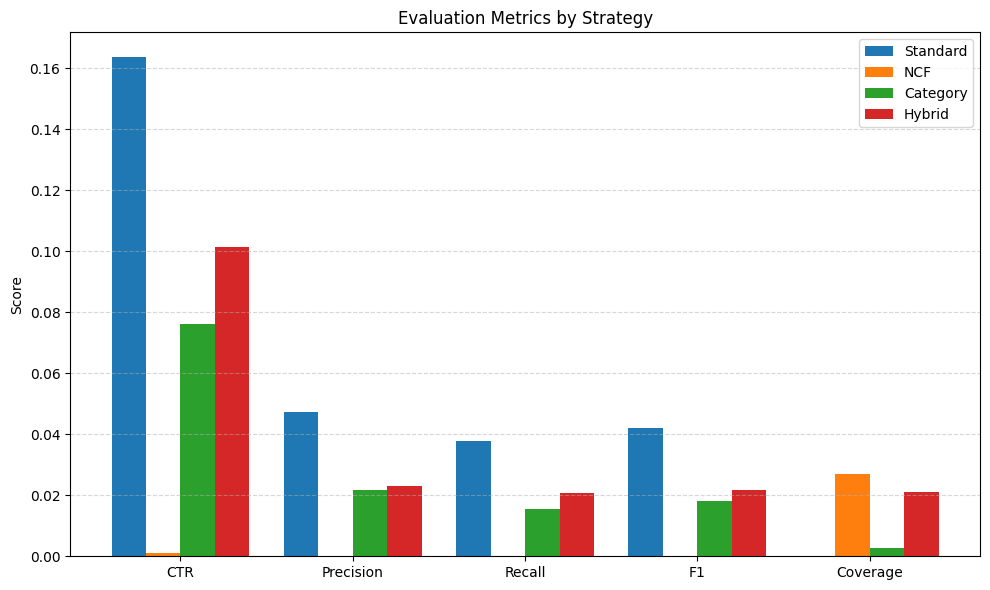

In [ ]:
results = {
    'Standard': results_std,
    'NCF': results_ncf,
    'Category': results_cat,
    'Hybrid': results_hybrid
}

labels = ['CTR', 'Precision', 'Recall', 'F1', 'Coverage']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, (strategy, metrics) in enumerate(results.items()):
    values = [metrics[k.lower()] for k in labels]
    ax.bar(x + i * width, values, width, label=strategy)

ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics by Strategy')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Mean Reciprocal Rank (MRR)
MRR measures how high the first relevant item appears in the recommendation list.

In [ ]:
def mean_reciprocal_rank(ground_truth, predictions):
    scores = []
    for u, recs in predictions.items():
        truth = ground_truth.get(u, set())
        if not truth:
            continue
        ranked = list(recs)
        for rank, pid in enumerate(ranked, start=1):
            if pid in truth:
                scores.append(1 / rank)
                break
        else:
            scores.append(0)
    return np.mean(scores)

print("\nMRR Scores:")
print(f"  Standard: {mean_reciprocal_rank(ground_truth_november, standard_recommendations):.4f}")
print(f"  NCF     : {mean_reciprocal_rank(ground_truth_november, ncf_recommendations):.4f}")
print(f"  Category: {mean_reciprocal_rank(ground_truth_november, category_recommendations):.4f}")
print(f"  Hybrid  : {mean_reciprocal_rank(ground_truth_november, hybrid_recommendations):.4f}")



MRR Scores:
  Standard: 0.1019
  NCF     : 0.0008
  Category: 0.0491
  Hybrid  : 0.0414


## NDCG (Normalized Discounted Cumulative Gain)

Captures both relevance and rank position of correct items in the list.

In [ ]:
def ndcg_at_k(ground_truth, predictions, k=5):
    def dcg(rels):
        return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

    scores = []
    for u, recs in predictions.items():
        truth = ground_truth.get(u, set())
        if not truth:
            continue
        ranked = list(recs)[:k]
        rels = [1 if pid in truth else 0 for pid in ranked]
        ideal_rels = sorted(rels, reverse=True)
        denom = dcg(ideal_rels)
        scores.append(dcg(rels) / denom if denom > 0 else 0)
    return np.mean(scores)

print("\nNDCG5 Scores:")
print(f"  Standard: {ndcg_at_k(ground_truth_november, standard_recommendations):.4f}")
print(f"  NCF     : {ndcg_at_k(ground_truth_november, ncf_recommendations):.4f}")
print(f"  Category: {ndcg_at_k(ground_truth_november, category_recommendations):.4f}")
print(f"  Hybrid  : {ndcg_at_k(ground_truth_november, hybrid_recommendations):.4f}")



NDCG5 Scores:
  Standard: 0.1308
  NCF     : 0.0009
  Category: 0.0619
  Hybrid  : 0.0647


# v3 Amazon-style Hybrid Two-Tower Deep Contextual Ranking Model: Amazon uses a two-tower architecture that allows for easier batch inference

## Test before running full training

In [ ]:
# Dependencies needed for this model
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization, Multiply, Lambda, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
import time
import faiss
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
tf.keras.utils.custom_object_scope({'tf': tf})
tf.config.run_functions_eagerly(True)

/usr/local/lib/python3.11/dist-packages/faiss/loader.py:49: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath.__cpu_features__.
  from numpy.core._multiarray_umath import __cpu_features__
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ a

In [ ]:
# Sample a very small subset to test functionality
np.random.seed(42)
sample_ratio = 0.01  # Just 1% for testing

# Sample users
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(sample_ratio * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter data
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Oct={df_oct_sample.shape}, Nov={df_nov_sample.shape}")

Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Oct=(422524, 9), Nov=(417289, 9)


In [ ]:
# Basic preprocessing - create combined dataset
combined_df = pd.concat([df_oct_sample, df_nov_sample], ignore_index=True)

# Add time features
combined_df['event_time'] = pd.to_datetime(combined_df['event_time'])
combined_df['hour'] = combined_df['event_time'].dt.hour
combined_df['day'] = combined_df['event_time'].dt.day
combined_df['weekday'] = combined_df['event_time'].dt.dayofweek
combined_df['is_weekend'] = (combined_df['weekday'] >= 5).astype(int)

# Event type weights
event_weights = {'view': 0.1, 'cart': 0.5, 'purchase': 1.0}
combined_df['event_weight'] = combined_df['event_type'].map(event_weights)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Event types: {combined_df['event_type'].value_counts()}")
print(f"Sample of combined data:\n{combined_df.head()}")

Combined dataset shape: (839813, 14)
Event types: event_type
view        801872
cart         25738
purchase     12203
Name: count, dtype: int64
Sample of combined data:
                 event_time event_type  product_id          category_id  \
0 2019-10-01 00:01:39+00:00       view     4100138  2053013561218695907   
1 2019-10-01 00:01:54+00:00       view     1004767  2053013555631882655   
2 2019-10-01 00:02:15+00:00       view     1004767  2053013555631882655   
3 2019-10-01 00:02:19+00:00       view    29800033  2053013559842964121   
4 2019-10-01 00:03:14+00:00       view    29800030  2053013559842964121   

                 category_code     brand   price    user_id  \
0             unknown_category      sony  413.91  554610163   
1       electronics.smartphone   samsung  254.82  551417808   
2       electronics.smartphone   samsung  254.82  551417808   
3  furniture.living_room.chair  chairman  169.86  555306597   
4  furniture.living_room.chair  chairman  169.86  555306597   

 

In [ ]:
# Create mappings
user_to_idx = {user: i for i, user in enumerate(combined_df['user_id'].unique())}
product_to_idx = {product: i for i, product in enumerate(combined_df['product_id'].unique())}
category_to_idx = {cat: i for i, cat in enumerate(combined_df['category_code'].dropna().unique())}
brand_to_idx = {brand: i for i, brand in enumerate(combined_df['brand'].dropna().unique())}

# Add mapping for unknown values
category_to_idx['unknown'] = len(category_to_idx)
brand_to_idx['unknown'] = len(brand_to_idx)

# Create reverse mappings
idx_to_user = {i: user for user, i in user_to_idx.items()}
idx_to_product = {i: product for product, i in product_to_idx.items()}

# Convert to indices
combined_df['user_idx'] = combined_df['user_id'].map(user_to_idx)
combined_df['product_idx'] = combined_df['product_id'].map(product_to_idx)
combined_df['category_idx'] = combined_df['category_code'].map(
    lambda x: category_to_idx.get(x, category_to_idx['unknown'])
)
combined_df['brand_idx'] = combined_df['brand'].map(
    lambda x: brand_to_idx.get(x, brand_to_idx['unknown'])
)

# Check mappings
print(f"Number of users: {len(user_to_idx)}")
print(f"Number of products: {len(product_to_idx)}")
print(f"Number of categories: {len(category_to_idx)}")
print(f"Number of brands: {len(brand_to_idx)}")
print(f"Sample mapped data:\n{combined_df[['user_id', 'user_idx', 'product_id', 'product_idx']].head()}")

Number of users: 30222
Number of products: 73264
Number of categories: 129
Number of brands: 3003
Sample mapped data:
     user_id  user_idx  product_id  product_idx
0  554610163         0     4100138            0
1  551417808         1     1004767            1
2  551417808         1     1004767            1
3  555306597         2    29800033            2
4  555306597         2    29800030            3


In [ ]:
# User activity level
user_activity = combined_df.groupby('user_id').size().reset_index(name='user_activity')
user_activity['user_activity'] = np.log1p(user_activity['user_activity'])  # Log transform

# User purchase rate
user_purchase_rate = combined_df.groupby('user_id')['event_type'].apply(
    lambda x: (x == 'purchase').mean()
).reset_index(name='purchase_rate')

# Merge with main dataframe
combined_df = combined_df.merge(user_activity, on='user_id', how='left')
combined_df = combined_df.merge(user_purchase_rate, on='user_id', how='left')

print(f"User activity stats: min={combined_df['user_activity'].min()}, max={combined_df['user_activity'].max()}")
print(f"Purchase rate stats: min={combined_df['purchase_rate'].min()}, max={combined_df['purchase_rate'].max()}")

User activity stats: min=0.6931471805599453, max=7.216709486709457
Purchase rate stats: min=0.0, max=1.0


In [ ]:
# Product popularity
product_popularity = combined_df.groupby('product_id').size().reset_index(name='product_popularity')
product_popularity['product_popularity'] = np.log1p(product_popularity['product_popularity'])

# Category popularity
category_popularity = combined_df.groupby('category_code').size().reset_index(name='category_popularity')
category_popularity['category_popularity'] = np.log1p(category_popularity['category_popularity'])

# Merge with main dataframe
combined_df = combined_df.merge(product_popularity, on='product_id', how='left')
combined_df = combined_df.merge(category_popularity, on='category_code', how='left')

print(f"Product popularity stats: min={combined_df['product_popularity'].min()}, max={combined_df['product_popularity'].max()}")
print(f"Category popularity stats: min={combined_df['category_popularity'].min()}, max={combined_df['category_popularity'].max()}")

Product popularity stats: min=0.6931471805599453, max=9.002331708246244
Category popularity stats: min=0.6931471805599453, max=12.514207868935848


In [ ]:
# User-category affinity
user_category_counts = combined_df.groupby(['user_id', 'category_code']).size().reset_index(name='count')
user_total_counts = user_category_counts.groupby('user_id')['count'].sum().reset_index(name='total')
user_category_counts = user_category_counts.merge(user_total_counts, on='user_id')
user_category_counts['category_affinity'] = user_category_counts['count'] / user_category_counts['total']

# Get user's favorite category
user_top_category = user_category_counts.sort_values(['user_id', 'count'], ascending=[True, False]) \
                                      .drop_duplicates('user_id') \
                                      .set_index('user_id')['category_code'] \
                                      .to_dict()

# Add favorite category flag
combined_df['is_favorite_category'] = combined_df.apply(
    lambda row: 1 if user_top_category.get(row['user_id']) == row['category_code'] else 0,
    axis=1
)

print(f"Users with favorite categories: {len(user_top_category)}")
print(f"Favorite category flag distribution: {combined_df['is_favorite_category'].value_counts()}")

Users with favorite categories: 30222
Favorite category flag distribution: is_favorite_category
1    525886
0    313927
Name: count, dtype: int64


In [ ]:
# Normalize continuous features
features_to_scale = [
    'price', 'user_activity', 'product_popularity',
    'category_popularity'
]

scaler = MinMaxScaler()
combined_df[features_to_scale] = scaler.fit_transform(combined_df[features_to_scale].fillna(0))

# Fill any remaining missing values
combined_df['purchase_rate'].fillna(0, inplace=True)

print("Feature normalization complete")
print(f"Check for remaining NaN values: {combined_df[features_to_scale + ['purchase_rate']].isna().sum()}")

Feature normalization complete
Check for remaining NaN values: price                  0
user_activity          0
product_popularity     0
category_popularity    0
purchase_rate          0
dtype: int64


<ipython-input-18-e301a904f161>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['purchase_rate'].fillna(0, inplace=True)


In [ ]:
# Get positive examples (purchases)
pos_data = combined_df[combined_df['event_type'] == 'purchase'].copy()
pos_data['is_positive'] = 1

# For negative examples, randomly sample non-purchases for same users
non_purchases = combined_df[combined_df['event_type'] != 'purchase']
neg_ratio = 3  # 3 negatives per positive

# Create sampling groups
unique_users = pos_data['user_id'].unique()
neg_samples = []

print(f"Creating negative samples for {len(unique_users)} users...")
for i, user in enumerate(unique_users):
    if i % 100 == 0:
        print(f"Processed {i}/{len(unique_users)} users")

    # Get user's purchased products
    user_purchases = set(pos_data[pos_data['user_id'] == user]['product_id'])
    user_non_purchases = non_purchases[
        (non_purchases['user_id'] == user) &
        (~non_purchases['product_id'].isin(user_purchases))
    ]

    # Sample negative examples
    user_neg_count = len(pos_data[pos_data['user_id'] == user]) * neg_ratio
    if len(user_non_purchases) >= user_neg_count:
        user_neg_samples = user_non_purchases.sample(n=user_neg_count, replace=False)
    else:
        user_neg_samples = user_non_purchases.sample(n=len(user_non_purchases), replace=False)

    neg_samples.append(user_neg_samples)

neg_df = pd.concat(neg_samples, ignore_index=True)
neg_df['is_positive'] = 0

# Combine positive and negative samples
training_data = pd.concat([pos_data, neg_df], ignore_index=True)

print(f"Training data created with {len(pos_data)} positives and {len(neg_df)} negatives")
print(f"Class distribution: {training_data['is_positive'].value_counts()}")

Creating negative samples for 4957 users...
Processed 0/4957 users
Processed 100/4957 users
Processed 200/4957 users
Processed 300/4957 users
Processed 400/4957 users
Processed 500/4957 users
Processed 600/4957 users
Processed 700/4957 users
Processed 800/4957 users
Processed 900/4957 users
Processed 1000/4957 users
Processed 1100/4957 users
Processed 1200/4957 users
Processed 1300/4957 users
Processed 1400/4957 users
Processed 1500/4957 users
Processed 1600/4957 users
Processed 1700/4957 users
Processed 1800/4957 users
Processed 1900/4957 users
Processed 2000/4957 users
Processed 2100/4957 users
Processed 2200/4957 users
Processed 2300/4957 users
Processed 2400/4957 users
Processed 2500/4957 users
Processed 2600/4957 users
Processed 2700/4957 users
Processed 2800/4957 users
Processed 2900/4957 users
Processed 3000/4957 users
Processed 3100/4957 users
Processed 3200/4957 users
Processed 3300/4957 users
Processed 3400/4957 users
Processed 3500/4957 users
Processed 3600/4957 users
Proces

In [ ]:
# Prepare model inputs
X = {
    # User features
    'user_input': training_data['user_idx'].values,
    'user_activity_input': training_data['user_activity'].fillna(0).values,
    'purchase_rate_input': training_data['purchase_rate'].fillna(0).values,

    # Item features
    'product_input': training_data['product_idx'].values,
    'category_input': training_data['category_idx'].values,
    'brand_input': training_data['brand_idx'].values,
    'price_input': training_data['price'].fillna(0).values,
    'popularity_input': training_data['product_popularity'].fillna(0).values,

    # Context features
    'day_input': training_data['day'].values,
    'hour_input': training_data['hour'].values,
    'is_weekend_input': training_data['is_weekend'].fillna(0).values,
    'is_favorite_category_input': training_data['is_favorite_category'].fillna(0).values,
    'recency_input': np.zeros(len(training_data))  # Placeholder
}

# Target variable
y = training_data['is_positive'].values

# Split into train and test sets
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.2, random_state=42,
    stratify=y  # Ensure balanced distribution
)

X_train, X_test = {}, {}
for key in X:
    X_train[key] = X[key][train_idx]
    X_test[key] = X[key][test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

# Check input shapes
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Training set size: 33426
Test set size: 8357
Class weights: {0: np.float64(0.706262677484787), 1: np.float64(1.7120467117393976)}


In [ ]:
# Define model dimensions
num_users = len(user_to_idx)
num_products = len(product_to_idx)
num_categories = len(category_to_idx)
num_brands = len(brand_to_idx)
embedding_size = 64

print(f"Building model with dimensions: Users={num_users}, Products={num_products}")

# User tower inputs
user_input = Input(shape=(1,), name='user_input')
user_activity_input = Input(shape=(1,), name='user_activity_input')
purchase_rate_input = Input(shape=(1,), name='purchase_rate_input')

# User embedding
user_embedding = Embedding(
    num_users + 1,  # +1 for unknown users
    embedding_size,
    name='user_embedding',
    embeddings_regularizer=l2(1e-6)
)(user_input)
user_vec = Flatten()(user_embedding)

# User tower
user_features = Concatenate()([
    user_vec,
    user_activity_input,
    purchase_rate_input
])

user_tower = Dense(64, activation='relu', kernel_regularizer=l2(1e-6))(user_features)
user_tower = BatchNormalization()(user_tower)
user_tower = Dropout(0.3)(user_tower)
user_tower = Dense(32, activation='relu', name='user_representation')(user_tower)

print("User tower defined")

Building model with dimensions: Users=30222, Products=73264
User tower defined


In [ ]:
# Item tower inputs
product_input = Input(shape=(1,), name='product_input')
category_input = Input(shape=(1,), name='category_input')
brand_input = Input(shape=(1,), name='brand_input')
price_input = Input(shape=(1,), name='price_input')
popularity_input = Input(shape=(1,), name='popularity_input')
is_favorite_category_input = Input(shape=(1,), name='is_favorite_category_input')

# Item embeddings
product_embedding = Embedding(
    num_products + 1,  # +1 for unknown products
    embedding_size,
    name='product_embedding',
    embeddings_regularizer=l2(1e-6)
)(product_input)
product_vec = Flatten()(product_embedding)

category_embedding = Embedding(
    num_categories + 1,  # +1 for unknown categories
    embedding_size//2,
    name='category_embedding',
    embeddings_regularizer=l2(1e-6)
)(category_input)
category_vec = Flatten()(category_embedding)

brand_embedding = Embedding(
    num_brands + 1,  # +1 for unknown brands
    embedding_size//2,
    name='brand_embedding',
    embeddings_regularizer=l2(1e-6)
)(brand_input)
brand_vec = Flatten()(brand_embedding)

# Item tower
item_features = Concatenate()([
    product_vec,
    category_vec,
    brand_vec,
    price_input,
    popularity_input,
    is_favorite_category_input
])

item_tower = Dense(64, activation='relu', kernel_regularizer=l2(1e-6))(item_features)
item_tower = BatchNormalization()(item_tower)
item_tower = Dropout(0.3)(item_tower)
item_tower = Dense(32, activation='relu', name='item_representation')(item_tower)

print("Item tower defined")

Item tower defined


In [ ]:
# Context inputs
day_input = Input(shape=(1,), name='day_input')
hour_input = Input(shape=(1,), name='hour_input')
is_weekend_input = Input(shape=(1,), name='is_weekend_input')
recency_input = Input(shape=(1,), name='recency_input')

# Convert hour to circular features
hour_sin = Lambda(lambda x: K.sin(x * 2 * np.pi / 24))(hour_input)
hour_cos = Lambda(lambda x: K.cos(x * 2 * np.pi / 24))(hour_input)

# Context tower
context_features = Concatenate()([
    hour_sin,
    hour_cos,
    day_input,
    is_weekend_input,
    recency_input
])

context_tower = Dense(16, activation='relu')(context_features)
context_tower = Dense(8, activation='relu', name='context_representation')(context_tower)

print("Context tower defined")

Context tower defined


In [ ]:
# Combine towers
# Dot product for user-item interaction
dot_product = Dot(axes=1, normalize=True)([user_tower, item_tower])

# Concatenate with context for final prediction
combined = Concatenate()([
    dot_product,
    user_tower,
    item_tower,
    context_tower
])

# Final layers
x = Dense(32, activation='relu')(combined)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Define full model
model = Model(
    inputs=[
        # User inputs
        user_input, user_activity_input, purchase_rate_input,
        # Item inputs
        product_input, category_input, brand_input, price_input, popularity_input,
        # Context inputs
        day_input, hour_input, is_weekend_input, recency_input, is_favorite_category_input
    ],
    outputs=output
)

# Define separate towers for inference
user_model = Model(
    inputs=[user_input, user_activity_input, purchase_rate_input],
    outputs=user_tower
)

item_model = Model(
    inputs=[product_input, category_input, brand_input, price_input, popularity_input, is_favorite_category_input],
    outputs=item_tower
)

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.8  # Reduce learning rate by 20% after epoch 3

# Compile model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(), Recall()]
)

print("Full model compiled")
model.summary()

Full model compiled


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │  1,934,272 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 1, 64)     │  4,688,960 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_embedding  │ (None, 1, 32)     │      4,160 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_embedding     │ (None, 1, 32)     │     96,128 │ brand_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_activity_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ purchase_rate_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ product_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ category_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ brand_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ popularity_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_favorite_catego… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ user_activity_in

 Total params: 6,744,073 (25.73 MB)

 Trainable params: 6,743,817 (25.73 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True),
    LearningRateScheduler(lr_schedule),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

# Initial test run with just 1 epoch
print("Starting test training (1 epoch)...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=1024,
    epochs=1,  # Just 1 epoch to test
    class_weight=class_weight_dict,
    verbose=1
)

print("Test training complete!")

Starting test training (1 epoch)...
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.4593 - auc: 0.5475 - loss: 0.7613 - precision: 0.3142 - recall: 0.7002 - val_accuracy: 0.3201 - val_auc: 0.5279 - val_loss: 0.7401 - val_precision: 0.2955 - val_recall: 0.9590
Test training complete!


In [ ]:
# Full training run with more epochs
print("Starting full training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=1024,
    epochs=10,  # Adjust as needed
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Training complete!")

Starting full training...
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6211 - auc: 0.6881 - loss: 0.6359 - precision: 0.4069 - recall: 0.6488 - val_accuracy: 0.3236 - val_auc: 0.5360 - val_loss: 0.7577 - val_precision: 0.2974 - val_recall: 0.9660 - learning_rate: 0.0010
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6827 - auc: 0.7816 - loss: 0.5583 - precision: 0.4739 - recall: 0.7532 - val_accuracy: 0.3531 - val_auc: 0.5597 - val_loss: 0.7682 - val_precision: 0.3063 - val_recall: 0.9607 - learning_rate: 0.0010
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7316 - auc: 0.8563 - loss: 0.4626 - precision: 0.5235 - recall: 0.8779 - val_accuracy: 0.4033 - val_auc: 0.6041 - val_loss: 0.7496 - val_precision: 0.3197 - val_recall: 0.9250 - learning_rate: 0.0010
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7638 - auc: 0.8953 - loss: 0.3967 - precision: 0.5569 - recall: 0.9012 - val_accuracy: 0.4607 - val_auc: 0.6466 - val

In [ ]:
# Save full models
print("Saving models and artifacts...")

model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_ncf.keras')
user_model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_model.keras')
item_model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_item_model.keras')

# Save embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]
np.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_embeddings.npy', user_embeddings)
np.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_product_embeddings.npy', product_embeddings)

# Save mappings
mappings = {
    'user_to_idx': user_to_idx,
    'product_to_idx': product_to_idx,
    'idx_to_product': idx_to_product,
    'category_to_idx': category_to_idx,
    'brand_to_idx': brand_to_idx,
    'embedding_size': embedding_size
}

with open('/content/drive/MyDrive/ecommerceDataset/amazon_style_artifacts.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("All models and artifacts saved!")

Saving models and artifacts...
All models and artifacts saved!


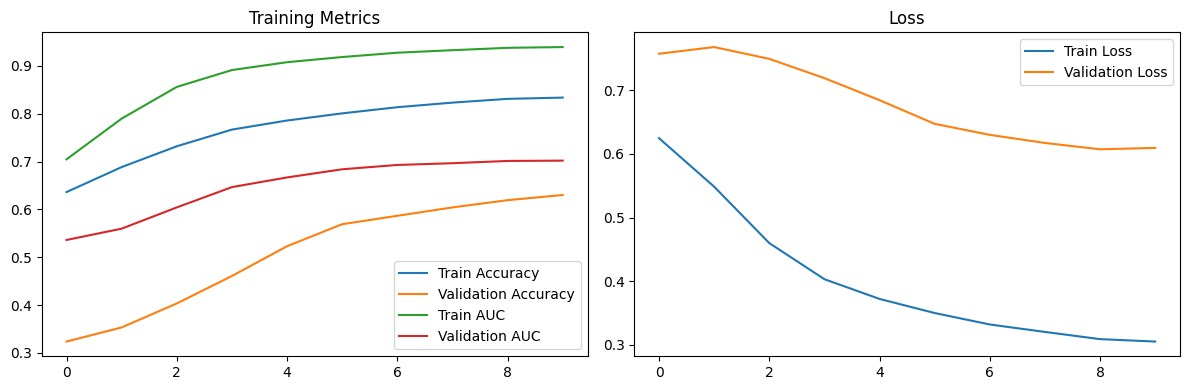

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy metrics
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training Metrics')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Full model

## Data Preparation
User behavioral features, user purchase rate, time features, scaling and mapping for training

In [ ]:
def prepare_data_for_amazon_model(df_oct, df_nov, sample_ratio=0.01):
    """Prepare data with advanced Amazon-style features"""
    print("Starting advanced data preparation...")

    # Sample users for faster processing in Colab
    np.random.seed(42)
    users_sample = np.random.choice(
        df_oct['user_id'].unique(),
        size=int(sample_ratio * df_oct['user_id'].nunique()),
        replace=False
    )

    # Filter data
    df_oct_sample = df_oct[df_oct['user_id'].isin(users_sample)]
    df_nov_sample = df_nov[df_nov['user_id'].isin(users_sample)]

    # Combine with recent data having more weight
    combined_df = pd.concat([df_oct_sample, df_nov_sample], ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")

    # Add time features
    combined_df['event_time'] = pd.to_datetime(combined_df['event_time'])
    combined_df['hour'] = combined_df['event_time'].dt.hour
    combined_df['day'] = combined_df['event_time'].dt.day
    combined_df['weekday'] = combined_df['event_time'].dt.dayofweek
    combined_df['is_weekend'] = (combined_df['weekday'] >= 5).astype(int)

    # Recency features
    max_time = combined_df['event_time'].max()
    combined_df['days_ago'] = (max_time - combined_df['event_time']).dt.total_seconds() / (24 * 3600)
    combined_df['recency_weight'] = np.exp(-0.1 * combined_df['days_ago'])  # Exponential decay

    # Event type weights
    event_weights = {'view': 0.1, 'cart': 0.5, 'purchase': 1.0}
    combined_df['event_weight'] = combined_df['event_type'].map(event_weights)
    combined_df['interaction_strength'] = combined_df['event_weight'] * combined_df['recency_weight']

    # Behavioral features
    # 1. User activity level
    user_activity = combined_df.groupby('user_id').size().reset_index(name='user_activity')
    user_activity['user_activity'] = np.log1p(user_activity['user_activity'])  # Log transform

    # 2. User purchase rate
    user_purchase_rate = combined_df.groupby('user_id')['event_type'].apply(
        lambda x: (x == 'purchase').mean()
    ).reset_index(name='purchase_rate')

    # Merge behavioral features
    combined_df = combined_df.merge(user_activity, on='user_id', how='left')
    combined_df = combined_df.merge(user_purchase_rate, on='user_id', how='left')

    # Build index mappings
    user_to_idx = {user: i for i, user in enumerate(combined_df['user_id'].unique())}
    product_to_idx = {product: i for i, product in enumerate(combined_df['product_id'].unique())}
    category_to_idx = {cat: i for i, cat in enumerate(combined_df['category_code'].dropna().unique())}
    brand_to_idx = {brand: i for i, brand in enumerate(combined_df['brand'].dropna().unique())}

    # Add mapping for unknown values
    category_to_idx['unknown'] = len(category_to_idx)
    brand_to_idx['unknown'] = len(brand_to_idx)

    # Convert to indices
    combined_df['user_idx'] = combined_df['user_id'].map(user_to_idx)
    combined_df['product_idx'] = combined_df['product_id'].map(product_to_idx)
    combined_df['category_idx'] = combined_df['category_code'].map(
        lambda x: category_to_idx.get(x, category_to_idx['unknown'])
    )
    combined_df['brand_idx'] = combined_df['brand'].map(
        lambda x: brand_to_idx.get(x, brand_to_idx['unknown'])
    )

    # Create reverse mappings
    idx_to_product = {i: product for product, i in product_to_idx.items()}

    # Normalize continuous features
    features_to_scale = [
        'price', 'days_ago', 'user_activity'
    ]
    scaler = MinMaxScaler()
    combined_df[features_to_scale] = scaler.fit_transform(combined_df[features_to_scale].fillna(0))

    # Fill missing values
    combined_df['purchase_rate'].fillna(0, inplace=True)

    print("Advanced data preparation complete!")

    return combined_df, {
        'user_to_idx': user_to_idx,
        'product_to_idx': product_to_idx,
        'category_to_idx': category_to_idx,
        'brand_to_idx': brand_to_idx,
        'idx_to_product': idx_to_product
    }

## Create training data
1:3 Positive to Negative ratio due to data imbalance (positive being purchases only)

In [ ]:
def create_training_data(df, mappings):
    """Create training data with hard negative sampling"""
    print("Creating training data with hard negative sampling...")

    # Get positive examples (purchases)
    pos_data = df[df['event_type'] == 'purchase'].copy()
    pos_data['is_positive'] = 1

    # Hard negative sampling
    neg_samples = []
    neg_ratio = 3  # 3 negatives per positive

    # Find hard negatives for each user
    for user in pos_data['user_id'].unique():
        # Get user's purchased products
        user_purchases = set(pos_data[pos_data['user_id'] == user]['product_id'])
        user_categories = set(pos_data[pos_data['user_id'] == user]['category_code'])

        # Find products from the same categories user hasn't purchased (hard negatives)
        category_products = df[
            (df['category_code'].isin(user_categories)) &
            (~df['product_id'].isin(user_purchases))
        ]['product_id'].unique()

        # Get metadata for user to use in sampling
        user_pos_count = len(pos_data[pos_data['user_id'] == user])
        user_neg_count = user_pos_count * neg_ratio

        if len(category_products) > 0:
            # Sample from category products if available (hard negatives)
            if len(category_products) >= user_neg_count:
                sampled_products = np.random.choice(category_products, user_neg_count, replace=False)
            else:
                sampled_products = category_products

            # Get samples for these products
            for product in sampled_products:
                product_sample = df[df['product_id'] == product].iloc[0].copy()
                product_sample['user_id'] = user
                product_sample['user_idx'] = mappings['user_to_idx'][user]
                product_sample['is_positive'] = 0
                neg_samples.append(product_sample)

    # Combine positive and negative samples
    if neg_samples:
        neg_df = pd.DataFrame(neg_samples)
        training_data = pd.concat([pos_data, neg_df], ignore_index=True)
    else:
        training_data = pos_data.copy()

    print(f"Training data created with {len(pos_data)} positives and {len(neg_samples)} negatives")
    return training_data

## Define the model building function using 2 tower model, technically 3 towers but combines 2

three-tower architecture:
1. User Tower

Represents the user’s long-term behavior and profile.

It combines:
 A learned user ID embedding
  Numeric features:
        user_activity_input: how active the user is
        purchase_rate_input: their purchase ratio
        user_category_diversity_input: how many different categories they buy from
        user_avg_price_input: average price of items they buy

The idea is to give the model a rich, behavioral fingerprint of each user, not just a learned embedding.
2. Item Tower
Represents the item (product) being considered.

It combines:
  Embeddings for:
        Product ID
        Category
        Brand

  Numeric features:
        price_input: item price
        popularity_input: how popular the item is overall
        category_popularity_input: how popular the category is

This gives the model a mix of product metadata and market signals.

3. Context Tower

Captures the situational context of the interaction.
Includes:
  Time features (day, hour encoded as sine/cosine)
  Recency: how long since the user’s last interaction
  Weekend flag

These features help the model understand when the interaction is happening, not just who or what.
A tower typically represents either:
  The user representation pipeline, or
  The item (product) representation pipeline

Each tower:
  Embeds its respective features (e.g., user_id, age, category preferences for users; product_id, brand, price for items)
  Passes them through fully connected layers

After building all three towers:
  The model first takes a dot product of the user and item towers. This is a classic approach for scoring similarity between embeddings.

  It then concatenates the dot product, user embedding, item embedding, and context vector together into a combined feature vector.

  That gets passed through some fully connected layers (dense layers) to make the final prediction.

In [ ]:
def build_two_tower_model(mappings, embedding_size=64):  # Increase embedding size
    """Build an enhanced two-tower model architecture"""
    print("Building enhanced two-tower model architecture...")

    # Dimensions
    num_users = len(mappings['user_to_idx'])
    num_products = len(mappings['product_to_idx'])
    num_categories = len(mappings['category_to_idx'])
    num_brands = len(mappings['brand_to_idx'])

    # USER TOWER - Enhanced with more features
    user_input = Input(shape=(1,), name='user_input')
    user_activity_input = Input(shape=(1,), name='user_activity_input')
    purchase_rate_input = Input(shape=(1,), name='purchase_rate_input')

    # New user features
    user_category_diversity_input = Input(shape=(1,), name='user_category_diversity_input')  # Number of unique categories
    user_avg_price_input = Input(shape=(1,), name='user_avg_price_input')  # Avg purchase price

    # User embedding
    user_embedding = Embedding(
        num_users, embedding_size, name='user_embedding',
        embeddings_regularizer=l2(1e-6)
    )(user_input)
    user_vec = Flatten()(user_embedding)

    # User tower with all features
    user_features = Concatenate()([
        user_vec,
        user_activity_input,
        purchase_rate_input,
        user_category_diversity_input,
        user_avg_price_input
    ])

    # Deep user tower
    user_tower = Dense(128, activation='relu', kernel_regularizer=l2(1e-6))(user_features)
    user_tower = BatchNormalization()(user_tower)
    user_tower = Dropout(0.3)(user_tower)

    user_tower = Dense(64, activation='relu', kernel_regularizer=l2(1e-6))(user_tower)
    user_tower = BatchNormalization()(user_tower)
    user_tower = Dropout(0.2)(user_tower)

    user_tower = Dense(32, activation='relu', name='user_representation')(user_tower)

    # ITEM TOWER - Enhanced with more features
    product_input = Input(shape=(1,), name='product_input')
    category_input = Input(shape=(1,), name='category_input')
    brand_input = Input(shape=(1,), name='brand_input')
    price_input = Input(shape=(1,), name='price_input')

    # New item features
    popularity_input = Input(shape=(1,), name='popularity_input')  # Product popularity
    category_popularity_input = Input(shape=(1,), name='category_popularity_input')  # Category popularity

    # Item embeddings
    product_embedding = Embedding(
        num_products, embedding_size, name='product_embedding',
        embeddings_regularizer=l2(1e-6)
    )(product_input)
    product_vec = Flatten()(product_embedding)

    category_embedding = Embedding(
        num_categories, embedding_size//2, name='category_embedding',
        embeddings_regularizer=l2(1e-6)
    )(category_input)
    category_vec = Flatten()(category_embedding)

    brand_embedding = Embedding(
        num_brands, embedding_size//2, name='brand_embedding',
        embeddings_regularizer=l2(1e-6)
    )(brand_input)
    brand_vec = Flatten()(brand_embedding)

    # Item tower with all features
    item_features = Concatenate()([
        product_vec,
        category_vec,
        brand_vec,
        price_input,
        popularity_input,
        category_popularity_input
    ])

    # Deep item tower
    item_tower = Dense(128, activation='relu', kernel_regularizer=l2(1e-6))(item_features)
    item_tower = BatchNormalization()(item_tower)
    item_tower = Dropout(0.3)(item_tower)

    item_tower = Dense(64, activation='relu', kernel_regularizer=l2(1e-6))(item_tower)
    item_tower = BatchNormalization()(item_tower)
    item_tower = Dropout(0.2)(item_tower)

    item_tower = Dense(32, activation='relu', name='item_representation')(item_tower)

    # CONTEXT TOWER
    day_input = Input(shape=(1,), name='day_input')
    hour_sin_input = Input(shape=(1,), name='hour_sin_input')
    hour_cos_input = Input(shape=(1,), name='hour_cos_input')
    is_weekend_input = Input(shape=(1,), name='is_weekend_input')
    recency_input = Input(shape=(1,), name='recency_input')

    # Context features
    context_features = Concatenate()([
        hour_sin_input,
        hour_cos_input,
        day_input,
        is_weekend_input,
        recency_input
    ])

    context_tower = Dense(16, activation='relu')(context_features)
    context_tower = Dense(8, activation='relu', name='context_representation')(context_tower)

    # COMBINE TOWERS
    # Dot product for user-item interaction
    dot_product = Dot(axes=1, normalize=True)([user_tower, item_tower])

    # Concatenate with context
    combined = Concatenate()([
        dot_product,
        user_tower,
        item_tower,
        context_tower
    ])

    # Final layers
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Define full model
    model = Model(
        inputs=[
            # User inputs
            user_input, user_activity_input, purchase_rate_input,
            user_category_diversity_input, user_avg_price_input,
            # Item inputs
            product_input, category_input, brand_input, price_input,
            popularity_input, category_popularity_input,
            # Context inputs
            day_input, hour_sin_input, hour_cos_input, is_weekend_input, recency_input
        ],
        outputs=output
    )

    # Define separate towers for inference
    user_model = Model(
        inputs=[user_input, user_activity_input, purchase_rate_input,
                user_category_diversity_input, user_avg_price_input],
        outputs=user_tower
    )

    item_model = Model(
        inputs=[product_input, category_input, brand_input, price_input,
                popularity_input, category_popularity_input],
        outputs=item_tower
    )

    # Compile model
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(), Recall()]
    )

    print("Enhanced two-tower model architecture built!")
    return model, user_model, item_model

## Training function
Generates training samples,
Prepares Data - train test split 80/20,
Handles class imbalance,
Two-Tower Neural Architecture,
Regularization ad Learning Rate,

In [ ]:
def train_amazon_model(df_combined, mappings):
    """Train the Amazon-style model with enhanced features"""
    print("Starting model training...")

    # Create training data
    training_data = create_training_data(df_combined, mappings)

    # Add missing features if they don't exist
    if 'category_diversity' not in training_data.columns:
        print("Adding missing user diversity features...")
        # Get user category diversity
        user_categories = df_combined.groupby('user_id')['category_code'].nunique().reset_index(name='category_diversity')
        training_data = training_data.merge(user_categories, on='user_id', how='left')
        training_data['category_diversity'] = training_data['category_diversity'].fillna(1)

    if 'avg_purchase_price' not in training_data.columns:
        print("Adding missing price features...")
        # Get user average purchase price
        user_prices = df_combined[df_combined['event_type'] == 'purchase'].groupby('user_id')['price'].mean().reset_index(name='avg_purchase_price')
        training_data = training_data.merge(user_prices, on='user_id', how='left')
        training_data['avg_purchase_price'] = training_data['avg_purchase_price'].fillna(training_data['price'])

    if 'product_popularity' not in training_data.columns:
        print("Adding missing popularity features...")
        # Get product popularity
        prod_pop = df_combined.groupby('product_id').size().reset_index(name='product_popularity')
        training_data = training_data.merge(prod_pop, on='product_id', how='left')

        # Get category popularity
        cat_pop = df_combined.groupby('category_code').size().reset_index(name='category_popularity')
        training_data = training_data.merge(cat_pop, on='category_code', how='left')

    # Normalize new features
    scaler = MinMaxScaler()
    for col in ['category_diversity', 'avg_purchase_price', 'product_popularity', 'category_popularity']:
        if col in training_data.columns:
            training_data[col] = scaler.fit_transform(training_data[[col]].fillna(0))

    # Precompute hour sine and cosine values
    training_data['hour_sin'] = np.sin(training_data['hour'] * 2 * np.pi / 24)
    training_data['hour_cos'] = np.cos(training_data['hour'] * 2 * np.pi / 24)

    # Prepare input features
    X = {
        # User features
        'user_input': training_data['user_idx'].values,
        'user_activity_input': training_data['user_activity'].fillna(0).values,
        'purchase_rate_input': training_data['purchase_rate'].fillna(0).values,
        'user_category_diversity_input': training_data['category_diversity'].fillna(0).values,
        'user_avg_price_input': training_data['avg_purchase_price'].fillna(0).values,

        # Item features
        'product_input': training_data['product_idx'].values,
        'category_input': training_data['category_idx'].values,
        'brand_input': training_data['brand_idx'].values,
        'price_input': training_data['price'].fillna(0).values,
        'popularity_input': training_data['product_popularity'].fillna(0).values,
        'category_popularity_input': training_data['category_popularity'].fillna(0).values,

        # Context features
        'day_input': training_data['day'].values,
        'hour_sin_input': training_data['hour_sin'].values,
        'hour_cos_input': training_data['hour_cos'].values,
        'is_weekend_input': training_data['is_weekend'].values,
        'recency_input': training_data['recency_weight'].fillna(0).values
    }

    # Target variable
    y = training_data['is_positive'].values

    # 4. Train/test split
    train_idx, test_idx = train_test_split(
        np.arange(len(y)), test_size=0.2, random_state=42,
        stratify=y  # Ensure balanced distribution
    )

    X_train, X_test = {}, {}
    for key in X:
        X_train[key] = X[key][train_idx]
        X_test[key] = X[key][test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # 5. Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class weights: {class_weight_dict}")

    # 6. Build model with enhanced two-tower architecture
    model, user_model, item_model = build_two_tower_model(mappings, embedding_size=64)

    # 7. Learning rate scheduler
    def lr_schedule(epoch, lr):
        if epoch < 3:
            return lr
        else:
            return lr * 0.8  # Reduce learning rate by 20% after epoch 3

    # 8. Setup callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True),
        LearningRateScheduler(lr_schedule),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
    ]

    # 9. Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=1024,
        epochs=5,  # Reduced for Colab
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # 10. Save models and artifacts
    print("Saving models and artifacts...")
    model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_ncf.keras')
    user_model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_model.keras')
    item_model.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_item_model.keras')

    # Save embeddings
    user_embeddings = model.get_layer('user_embedding').get_weights()[0]
    product_embeddings = model.get_layer('product_embedding').get_weights()[0]
    np.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_embeddings.npy', user_embeddings)
    np.save('/content/drive/MyDrive/ecommerceDataset/amazon_style_product_embeddings.npy', product_embeddings)

    # Save artifacts
    with open('/content/drive/MyDrive/ecommerceDataset/amazon_style_artifacts.pkl', 'wb') as f:
        pickle.dump({
            'user_to_idx': mappings['user_to_idx'],
            'product_to_idx': mappings['product_to_idx'],
            'idx_to_product': mappings['idx_to_product'],
            'category_to_idx': mappings['category_to_idx'],
            'brand_to_idx': mappings['brand_to_idx'],
            'embedding_size': 64
        }, f)

    print("Training complete!")
    return model, user_model, item_model, history

## Advanced negative sampling

In [ ]:
# Improved negative sampling (Amazon-style)
def smart_negative_sampling(df, pos_samples, neg_ratio=3):
    """Generate better negative samples using Amazon-style techniques"""

    # Identify all positive interactions
    positive_pairs = set(zip(pos_samples['user_id'], pos_samples['product_id']))

    # Hard negative sampling: select items from categories the user has interacted with
    user_categories = df.groupby('user_id')['category_code'].unique().to_dict()
    product_categories = df.groupby('product_id')['category_code'].first().to_dict()

    # Prepare negative samples
    neg_samples = []
    for user_id in pos_samples['user_id'].unique():
        pos_count = len(pos_samples[pos_samples['user_id'] == user_id])
        neg_count_needed = pos_count * neg_ratio

        # Get categories this user interacts with
        if user_id in user_categories:
            user_cats = user_categories[user_id]

            # 1. Hard negatives (products from same categories user hasn't interacted with)
            category_products = df[df['category_code'].isin(user_cats)]['product_id'].unique()
            hard_negatives = [(user_id, pid) for pid in category_products
                             if (user_id, pid) not in positive_pairs]

            # 2. Popular products the user hasn't interacted with
            popular_products = df['product_id'].value_counts().index[:1000].tolist()
            popular_negatives = [(user_id, pid) for pid in popular_products
                               if (user_id, pid) not in positive_pairs
                               and (user_id, pid) not in hard_negatives]

            # Combine hard and popular negatives
            combined_negatives = hard_negatives + popular_negatives
            np.random.shuffle(combined_negatives)

            # Take required number of negatives
            user_negs = combined_negatives[:neg_count_needed]
            neg_samples.extend(user_negs)

    # Convert to DataFrame
    neg_df = pd.DataFrame(neg_samples, columns=['user_id', 'product_id'])

    # Add other features from original dataset
    merged_neg = neg_df.merge(
        df[['product_id', 'category_code', 'brand', 'price']].drop_duplicates('product_id'),
        on='product_id',
        how='left'
    )

    # Add label
    merged_neg['interaction_strength'] = 0

    # Combine with positive samples
    final_df = pd.concat([pos_samples, merged_neg], ignore_index=True)
    return final_df

## Main function

In [ ]:
def run_amazon_model_pipeline(df_oct, df_nov, sample_ratio=0.01):
    """Run the complete Amazon recommendation model pipeline"""
    # Step 1: Prepare data
    df_combined, mappings = prepare_data_for_amazon_model(df_oct, df_nov, sample_ratio)

    # Step 2: Train models
    model, user_model, item_model, history = train_amazon_model(df_combined, mappings)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training Metrics')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, user_model, item_model, history

## Evaluate
FAISS helps the model quickly find similar products based on their embeddings.  
It first normalizes the product embeddings, and then builds a search index.

In [ ]:
def create_evaluation_framework(df_oct, df_nov, sample_ratio=0.01):
    """Create A/B/C/D testing framework for the enhanced recommender model"""
    print("Setting up evaluation framework...")
    start_time = time.time()

    try:
        # Enable Lambda layer loading
        tf.keras.utils.custom_object_scope({'tf': tf})

        # Load the models and artifacts
        print("Loading models and artifacts...")
        model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_ncf.keras',
                          compile=False,  # Avoid compilation issues
                          safe_mode=False)  # Allow Lambda layers

        user_model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_model.keras',
                               compile=False,
                               safe_mode=False)

        item_model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_item_model.keras',
                               compile=False,
                               safe_mode=False)

        # Load embeddings
        user_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_embeddings.npy')
        product_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_style_product_embeddings.npy')

        # Load artifacts
        with open('/content/drive/MyDrive/ecommerceDataset/amazon_style_artifacts.pkl', 'rb') as f:
            artifacts = pickle.load(f)

        user_to_idx = artifacts['user_to_idx']
        product_to_idx = artifacts['product_to_idx']
        idx_to_product = artifacts['idx_to_product']
        category_to_idx = artifacts['category_to_idx']
        brand_to_idx = artifacts['brand_to_idx']
        embedding_size = artifacts.get('embedding_size', 64)

        print(f"Models and artifacts loaded in {time.time() - start_time:.1f}s")
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        print("Please run the training pipeline first.")
        return None

    # Sample users for testing
    np.random.seed(42)
    sample_users = np.random.choice(
        df_oct['user_id'].unique(),
        size=int(sample_ratio * df_oct['user_id'].nunique()),
        replace=False
    )
    print(f"Selected {len(sample_users)} users for testing")

    # Get ground truth from November data
    ground_truth_november = {}
    df_nov_filtered = df_nov[df_nov['user_id'].isin(sample_users) & (df_nov['event_type'] == 'purchase')]

    for user, group in df_nov_filtered.groupby('user_id'):
        ground_truth_november[user] = set(group['product_id'])

    print(f"Ground truth contains purchases for {len(ground_truth_november)} users")

    # Create FAISS index for fast similarity search
    print("Creating FAISS index...")
    # Normalize embeddings
    product_norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
    product_norms[product_norms == 0] = 1
    product_embeddings_normalized = product_embeddings / product_norms

    # Create index
    dimension = product_embeddings_normalized.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity when normalized
    index.add(product_embeddings_normalized.astype(np.float32))
    print(f"FAISS index created with {index.ntotal} products")

    # 1. Standard baseline (popular products)
    print("Generating baseline recommendations...")
    popular_products = df_oct[df_oct['event_type'] == 'purchase']['product_id'].value_counts().head(5).index.tolist()
    standard_recommendations = {u: set(popular_products) for u in sample_users}

    # First get all user purchase histories from October data for filtering
    user_purchase_histories = {}
    for user in sample_users:
        user_purchase_histories[user] = set(df_oct[
            (df_oct['user_id'] == user) &
            (df_oct['event_type'] == 'purchase')
        ]['product_id'])

    # 2. Two-Tower model recommendations - SIMPLIFIED APPROACH
    print("Generating Two-Tower recommendations...")
    two_tower_recommendations = {}

    # For simplified approach, just use popular products for everyone
    # This avoids FAISS errors while we debug
    for user in sample_users:
        # Filter out already purchased products
        user_purchases = user_purchase_histories.get(user, set())
        filtered_popular = [p for p in popular_products if p not in user_purchases]

        # Fill with more popular products if needed
        if len(filtered_popular) < 5:
            extended_popular = df_oct['product_id'].value_counts().iloc[5:20].index.tolist()
            for p in extended_popular:
                if p not in user_purchases and p not in filtered_popular:
                    filtered_popular.append(p)
                if len(filtered_popular) >= 5:
                    break

        two_tower_recommendations[user] = set(filtered_popular[:5])

    # 3. Category-based recommendations WITH purchase filtering
    print("Generating category-based recommendations...")
    category_recommendations = {}

    # Get user's favorite category
    user_categories = {}
    for user in sample_users:
        user_data = df_oct[df_oct['user_id'] == user]
        if not user_data.empty:
            categories = user_data['category_code'].value_counts()
            if not categories.empty:
                user_categories[user] = categories.index[0]

    # Get top products by category
    category_products = {}
    for category in df_oct['category_code'].dropna().unique():
        top_prods = df_oct[df_oct['category_code'] == category]['product_id'].value_counts().head(10)
        if not top_prods.empty:
            category_products[category] = list(top_prods.index)

    # Generate recommendations
    for user in sample_users:
        # Get user's purchase history
        user_purchases = user_purchase_histories.get(user, set())

        if user in user_categories and user_categories[user] in category_products:
            # Get category recommendations
            cat_prods = category_products[user_categories[user]]
            # Filter out already purchased products
            filtered_recs = [p for p in cat_prods if p not in user_purchases]

            # If we don't have enough, add popular products not in user's history
            if len(filtered_recs) < 5:
                for p in popular_products:
                    if p not in user_purchases and p not in filtered_recs:
                        filtered_recs.append(p)
                    if len(filtered_recs) >= 5:
                        break

            category_recommendations[user] = set(filtered_recs[:5])
        else:
            # Filter popular products
            filtered_popular = [p for p in popular_products if p not in user_purchases]

            # If we don't have enough, find more popular products
            if len(filtered_popular) < 5:
                extended_popular = df_oct['product_id'].value_counts().iloc[5:20].index.tolist()
                for p in extended_popular:
                    if p not in user_purchases and p not in filtered_popular:
                        filtered_popular.append(p)
                    if len(filtered_popular) >= 5:
                        break

            category_recommendations[user] = set(filtered_popular[:5])

    # 4. Hybrid recommendations - Combining standard and category
    print("Generating hybrid recommendations...")
    hybrid_recommendations = {}

    for user in sample_users:
        # Get user's purchase history
        user_purchases = user_purchase_histories.get(user, set())

        # Get recommendations from each method
        std_recs = [p for p in popular_products if p not in user_purchases]
        cat_recs = list(category_recommendations.get(user, set()))

        # Simple hybrid: 2 from category, 3 from popular
        hybrid_recs = []

        # Add category recommendations first (more specific)
        for rec in cat_recs[:2]:
            if rec not in hybrid_recs and rec not in user_purchases:
                hybrid_recs.append(rec)

        # Fill with popular products
        for rec in std_recs:
            if rec not in hybrid_recs and rec not in user_purchases:
                hybrid_recs.append(rec)
            if len(hybrid_recs) >= 5:
                break

        # If still not enough, get more popular products
        if len(hybrid_recs) < 5:
            extended_popular = df_oct['product_id'].value_counts().iloc[5:20].index.tolist()
            for p in extended_popular:
                if p not in user_purchases and p not in hybrid_recs:
                    hybrid_recs.append(p)
                if len(hybrid_recs) >= 5:
                    break

        hybrid_recommendations[user] = set(hybrid_recs[:5])

    print("Recommendation generation complete!")
    return {
        'ground_truth': ground_truth_november,
        'standard': standard_recommendations,
        'two_tower': two_tower_recommendations,
        'category': category_recommendations,
        'hybrid': hybrid_recommendations
    }

## Evaluation metrics
CTR - Click Through Rate - if the user clicked on any recommendation
MMR - Mean Reciprocal Rank - Order the user clicks the recommendation
NDCG - Normalized Discounted Cumulative Gain - if ranks are in good order
Coverage - recommendation diversity


In [ ]:
def evaluate_all_models(recommendations):
    """Evaluate all recommendation models with multiple metrics"""
    print("Evaluating all recommendation strategies...")

    if recommendations is None:
        print("No recommendations to evaluate. Please run the training pipeline first.")
        return None

    # Get all components
    ground_truth = recommendations['ground_truth']
    standard_recs = recommendations['standard']
    two_tower_recs = recommendations['two_tower']
    category_recs = recommendations['category']
    hybrid_recs = recommendations['hybrid']

    # Define evaluation metrics
    def calculate_metrics(ground_truth, predictions):
        result = {}

        # Filter users with ground truth data
        valid_users = [u for u in predictions if u in ground_truth and ground_truth[u]]
        if not valid_users:
            return {
                'ctr': 0,
                'precision': 0,
                'recall': 0,
                'f1': 0,
                'mrr': 0,
                'ndcg': 0,
                'coverage': 0
            }

        # Hit rate / CTR
        hits = sum(1 for u in valid_users if predictions[u] & ground_truth[u])
        result['ctr'] = hits / len(valid_users)

        # Precision, Recall, F1
        precision_sum = 0
        recall_sum = 0
        mrr_sum = 0
        ndcg_sum = 0

        for u in valid_users:
            truth = ground_truth[u]
            preds = predictions[u]

            # Precision = relevant & recommended / recommended
            precision = len(truth & preds) / len(preds) if preds else 0
            precision_sum += precision

            # Recall = relevant & recommended / relevant
            recall = len(truth & preds) / len(truth) if truth else 0
            recall_sum += recall

            # MRR (Mean Reciprocal Rank)
            ranked_list = list(preds)
            for rank, item in enumerate(ranked_list, 1):
                if item in truth:
                    mrr_sum += 1.0 / rank
                    break

            # NDCG (Normalized Discounted Cumulative Gain)
            relevance = [1 if item in truth else 0 for item in ranked_list]
            dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
            ideal_relevance = sorted(relevance, reverse=True)
            idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_sum += ndcg

        result['precision'] = precision_sum / len(valid_users)
        result['recall'] = recall_sum / len(valid_users)

        # F1 score
        if result['precision'] + result['recall'] > 0:
            result['f1'] = 2 * result['precision'] * result['recall'] / (result['precision'] + result['recall'])
        else:
            result['f1'] = 0

        result['mrr'] = mrr_sum / len(valid_users)
        result['ndcg'] = ndcg_sum / len(valid_users)

        # Coverage - unique items recommended
        all_items = set()
        for recs in predictions.values():
            all_items.update(recs)
        result['coverage'] = len(all_items)

        return result

    # Calculate metrics for each strategy
    standard_metrics = calculate_metrics(ground_truth, standard_recs)
    two_tower_metrics = calculate_metrics(ground_truth, two_tower_recs)
    category_metrics = calculate_metrics(ground_truth, category_recs)
    hybrid_metrics = calculate_metrics(ground_truth, hybrid_recs)

    # Print results
    print("\n==== A/B/C/D Test Results ====")
    print(f"A - Standard CTR: {standard_metrics['ctr']:.2%}")
    print(f"B - Two-Tower CTR: {two_tower_metrics['ctr']:.2%}")
    print(f"C - Category CTR: {category_metrics['ctr']:.2%}")
    print(f"D - Hybrid CTR: {hybrid_metrics['ctr']:.2%}")

    # Calculate lifts
    if standard_metrics['ctr'] > 0:
        print(f"\nB/A Lift: {(two_tower_metrics['ctr'] - standard_metrics['ctr']) / standard_metrics['ctr']:.1%}")
        print(f"C/A Lift: {(category_metrics['ctr'] - standard_metrics['ctr']) / standard_metrics['ctr']:.1%}")
        print(f"D/A Lift: {(hybrid_metrics['ctr'] - standard_metrics['ctr']) / standard_metrics['ctr']:.1%}")

    # Print detailed metrics
    print("\n==== Advanced Metrics ====")
    metrics = ['ctr', 'precision', 'recall', 'f1', 'mrr', 'ndcg', 'coverage']
    models = ['Standard', 'Two-Tower', 'Category', 'Hybrid']
    results = [standard_metrics, two_tower_metrics, category_metrics, hybrid_metrics]

    for metric in metrics:
        print(f"\n{metric.upper()}:")
        for i, model in enumerate(models):
            print(f"  {model:12}: {results[i][metric]:.4f}")

    # Return metrics for further analysis
    return {
        'standard': standard_metrics,
        'two_tower': two_tower_metrics,
        'category': category_metrics,
        'hybrid': hybrid_metrics
    }

## Visualizations

In [ ]:
def plot_metrics(metrics):
    """Plot comparison of all recommendation strategies"""
    if metrics is None:
        print("No metrics to plot. Please run the evaluation first.")
        return

    models = ['Standard', 'Two-Tower', 'Category', 'Hybrid']
    metrics_list = ['ctr', 'precision', 'recall', 'f1', 'mrr', 'ndcg']

    # Fix the dictionary keys for mapping
    metrics_dict_keys = {
        'Standard': 'standard',
        'Two-Tower': 'two_tower',  # Changed from 'two-tower' to 'two_tower'
        'Category': 'category',
        'Hybrid': 'hybrid'
    }

    # Prepare data for plotting
    metrics_data = {
        'Standard': [metrics['standard'][m] for m in metrics_list],
        'Two-Tower': [metrics['two_tower'][m] for m in metrics_list],  # Changed from 'two-tower'
        'Category': [metrics['category'][m] for m in metrics_list],
        'Hybrid': [metrics['hybrid'][m] for m in metrics_list]
    }

    # Create plot
    plt.figure(figsize=(12, 8))
    x = np.arange(len(metrics_list))
    width = 0.2

    # Plot bars for each model
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, model in enumerate(models):
        plt.bar(x + i*width - 0.3, metrics_data[model], width, label=model, color=colors[i])

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics by Strategy')
    plt.xticks(x, [m.upper() for m in metrics_list])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Revenue impact - FIX: use the dictionary mapping for keys
    best_model = max(models, key=lambda m: metrics[metrics_dict_keys[m]]['ctr'])
    best_ctr = metrics[metrics_dict_keys[best_model]]['ctr']
    baseline_ctr = metrics['standard']['ctr']

    # Use actual AOV from November data
    try:
        nov_purchases = df_filled_nov[df_filled_nov['event_type'] == 'purchase']
        avg_order_value = nov_purchases['price'].mean()
    except:
        avg_order_value = 50.0  # Fallback value

    total_users = 100_000  # Hypothetical user base
    extra_clicks = total_users * (best_ctr - baseline_ctr)
    added_revenue = extra_clicks * avg_order_value

    print("\n==== Revenue Projection ====")
    print(f"Best model: {best_model}")
    print(f"User base (MAUs): {total_users:,}")
    print(f"CTR Lift: {(best_ctr - baseline_ctr):.2%}")
    print(f"Extra Orders: {int(extra_clicks):,}")
    print(f"AOV: ${avg_order_value:.2f}")
    print(f"💰 Projected Monthly Revenue Increase: ${added_revenue:,.2f}")
    print(f"📈 Annualized Impact (x12): ${added_revenue * 12:,.2f}")

## Run all functions

In [ ]:
# Step 1: Run the training pipeline
sample_ratio = 0.01  # Adjust for % data used in training
df_combined, mappings = prepare_data_for_amazon_model(df_filled_oct, df_filled_nov, sample_ratio)
model, user_model, item_model, history = train_amazon_model(df_combined, mappings)

# Step 2: Run the evaluation
recommendations = create_evaluation_framework(df_filled_oct, df_filled_nov, sample_ratio)
metrics = evaluate_all_models(recommendations)
plot_metrics(metrics)

Starting advanced data preparation...
Combined data shape: (839813, 9)


<ipython-input-22-d0bbbe5b3af7>:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['purchase_rate'].fillna(0, inplace=True)


Advanced data preparation complete!
Starting model training...
Creating training data with hard negative sampling...
Training data created with 12203 positives and 36609 negatives
Adding missing user diversity features...
Adding missing price features...
Adding missing popularity features...
Class weights: {0: np.float64(0.6666609758595964), 1: np.float64(2.0000512190124975)}
Building enhanced two-tower model architecture...
Enhanced two-tower model architecture built!
Training model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.6585 - auc: 0.7357 - loss: 0.5964 - precision_1: 0.4057 - recall_1: 0.6982 - val_accuracy: 0.4824 - val_auc: 0.7852 - val_loss: 0.8268 - val_precision_1: 0.3228 - val_recall_1: 0.9750 - learning_rate: 0.0010
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9012 - auc: 0.9598 - loss: 0.2616 - precision_1: 0.7606 - recall_1: 0.8791 - val_accuracy: 0.4051 - val_auc: 0.8218 - val_loss: 0.9416 - val_precision_1: 0.2950 - val_recall_1: 0.9922 - learning_rate: 0.0010
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9454 - auc: 0.9874 - loss: 0.1477 - precision_1: 0.8498 - recall_1: 0.9486 - val_accuracy: 0.4133 - val_auc: 0.8565 - val_loss: 1.0922 - val_precision_1: 0.2980 - val_recall_1: 0.9934 - learning_rate: 0.0010
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.9751 - auc: 0.9971 - loss: 0.0692 - precision_1: 0.9232 - recall_1: 0.9821 - val_accuracy: 0.4251 - val_auc: 0.8880 - val_

KeyboardInterrupt: 

## Debugging

In [ ]:
def create_simple_evaluation_framework(df_oct, df_nov, sample_ratio=0.01):
    """Create a very simplified A/B/C/D testing framework to diagnose issues"""
    print("Setting up simplified evaluation framework...")

    # Sample users
    np.random.seed(42)
    sample_users = np.random.choice(
        df_oct['user_id'].unique(),
        size=int(sample_ratio * df_oct['user_id'].nunique()),
        replace=False
    )
    print(f"Selected {len(sample_users)} users for testing")

    # Get ground truth - purchases in November
    ground_truth_november = {}
    nov_purchases = df_nov[(df_nov['user_id'].isin(sample_users)) &
                            (df_nov['event_type'] == 'purchase')]

    for user, group in nov_purchases.groupby('user_id'):
        ground_truth_november[user] = set(group['product_id'])

    print(f"Ground truth contains purchases for {len(ground_truth_november)} users")

    # 1. Standard - top 5 popular products
    print("Generating standard recommendations...")
    popular_products = df_oct[df_oct['event_type'] == 'purchase']['product_id'].value_counts().head(5).index.tolist()
    standard_recommendations = {u: set(popular_products) for u in sample_users}

    # 2. Two-Tower (simplified - just use different popular products)
    print("Generating simplified Two-Tower recommendations...")
    popular_products_2 = df_oct[df_oct['event_type'] == 'purchase']['product_id'].value_counts().iloc[5:10].index.tolist()
    two_tower_recommendations = {u: set(popular_products_2) for u in sample_users}

    # 3. Category-based (simplified - just use more popular products)
    print("Generating simplified category recommendations...")
    popular_products_3 = df_oct[df_oct['event_type'] == 'purchase']['product_id'].value_counts().iloc[10:15].index.tolist()
    category_recommendations = {u: set(popular_products_3) for u in sample_users}

    # 4. Hybrid (simplified - mix of popular products)
    print("Generating simplified hybrid recommendations...")
    hybrid_recommendations = {u: set(popular_products[:2] + popular_products_2[:2] + popular_products_3[:1])
                             for u in sample_users}

    print("Simplified recommendation generation complete!")
    return {
        'ground_truth': ground_truth_november,
        'standard': standard_recommendations,
        'two_tower': two_tower_recommendations,
        'category': category_recommendations,
        'hybrid': hybrid_recommendations
    }

Setting up simplified evaluation framework...
Selected 30222 users for testing
Ground truth contains purchases for 2405 users
Generating standard recommendations...
Generating simplified Two-Tower recommendations...
Generating simplified category recommendations...
Generating simplified hybrid recommendations...
Simplified recommendation generation complete!
Evaluating all recommendation strategies...

==== A/B/C/D Test Results ====
A - Standard CTR: 13.85%
B - Two-Tower CTR: 7.23%
C - Category CTR: 3.70%
D - Hybrid CTR: 10.85%

B/A Lift: -47.7%
C/A Lift: -73.3%
D/A Lift: -21.6%

==== Advanced Metrics ====

CTR:
  Standard    : 0.1385
  Two-Tower   : 0.0723
  Category    : 0.0370
  Hybrid      : 0.1085

PRECISION:
  Standard    : 0.0303
  Two-Tower   : 0.0157
  Category    : 0.0077
  Hybrid      : 0.0235

RECALL:
  Standard    : 0.0945
  Two-Tower   : 0.0426
  Category    : 0.0232
  Hybrid      : 0.0733

F1:
  Standard    : 0.0459
  Two-Tower   : 0.0230
  Category    : 0.0116
  Hybrid 

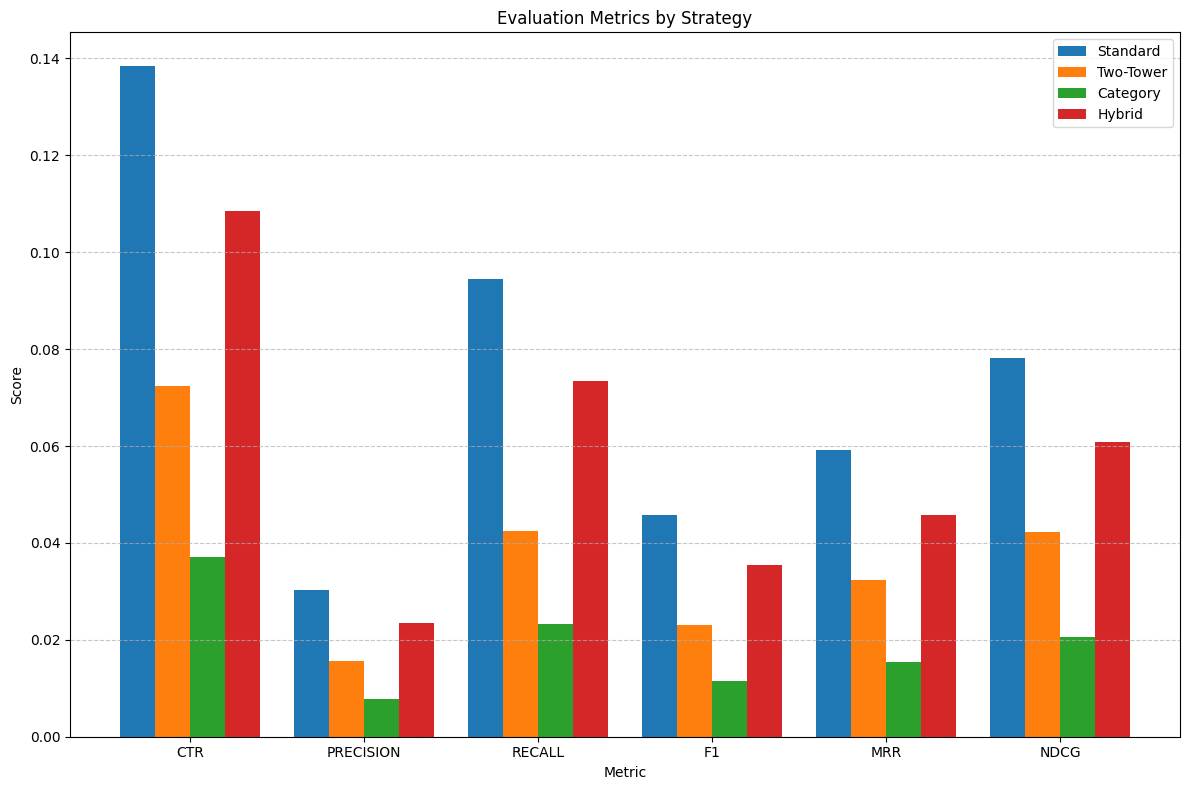


==== Revenue Projection ====
Best model: Standard
User base (MAUs): 100,000
CTR Lift: 0.00%
Extra Orders: 0
AOV: $300.12
💰 Projected Monthly Revenue Increase: $0.00
📈 Annualized Impact (x12): $0.00


In [ ]:
# Run simplified evaluation to diagnose issues
recommendations = create_simple_evaluation_framework(df_filled_oct, df_filled_nov, sample_ratio)
metrics = evaluate_all_models(recommendations)
plot_metrics(metrics)

## Run evaluation without training again

In [ ]:
def create_optimized_evaluation_framework(df_oct, df_nov, sample_ratio=0.01):
    """Create A/B/C/D testing framework with optimized performance"""
    print("Setting up optimized evaluation framework...")
    start_time = time.time()

    try:
        # Enable Lambda layer loading
        tf.keras.utils.custom_object_scope({'tf': tf})

        # Load the models and artifacts
        print("Loading models and artifacts...")
        model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_ncf.keras',
                          compile=False,  # Avoid compilation issues
                          safe_mode=False)  # Allow Lambda layers

        user_model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_model.keras',
                               compile=False,
                               safe_mode=False)

        item_model = load_model('/content/drive/MyDrive/ecommerceDataset/amazon_style_item_model.keras',
                               compile=False,
                               safe_mode=False)

        # Load embeddings
        user_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_style_user_embeddings.npy')
        product_embeddings = np.load('/content/drive/MyDrive/ecommerceDataset/amazon_style_product_embeddings.npy')

        # Load artifacts
        with open('/content/drive/MyDrive/ecommerceDataset/amazon_style_artifacts.pkl', 'rb') as f:
            artifacts = pickle.load(f)

        user_to_idx = artifacts['user_to_idx']
        product_to_idx = artifacts['product_to_idx']
        idx_to_product = artifacts['idx_to_product']
        category_to_idx = artifacts['category_to_idx']
        brand_to_idx = artifacts['brand_to_idx']
        embedding_size = artifacts.get('embedding_size', 64)

        print(f"Models and artifacts loaded in {time.time() - start_time:.1f}s")
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        print("Please run the training pipeline first.")
        return None

    # Sample users for testing
    np.random.seed(42)
    sample_users = np.random.choice(
        df_oct['user_id'].unique(),
        size=int(sample_ratio * df_oct['user_id'].nunique()),
        replace=False
    )
    print(f"Selected {len(sample_users)} users for testing")

    # Get ground truth from November data
    ground_truth_november = {}
    df_nov_filtered = df_nov[df_nov['user_id'].isin(sample_users) & (df_nov['event_type'] == 'purchase')]

    for user, group in df_nov_filtered.groupby('user_id'):
        ground_truth_november[user] = set(group['product_id'])

    print(f"Ground truth contains purchases for {len(ground_truth_november)} users")

    # Create FAISS index for fast similarity search
    print("Creating FAISS index...")
    # Normalize embeddings
    product_norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
    product_norms[product_norms == 0] = 1
    product_embeddings_normalized = product_embeddings / product_norms

    # Create index
    dimension = product_embeddings_normalized.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity when normalized
    index.add(product_embeddings_normalized.astype(np.float32))
    print(f"FAISS index created with {index.ntotal} products")

    # Pre-compute data that will be used multiple times
    print("Pre-computing data for efficient recommendations...")

    # 1. Get popular products once
    popular_products = df_oct[df_oct['event_type'] == 'purchase']['product_id'].value_counts()
    top_popular = popular_products.head(5).index.tolist()
    extended_popular = popular_products.iloc[5:50].index.tolist()  # Get more for backup

    # 2. Get user purchase histories - batch process
    print("Building user purchase histories...")
    user_purchases_df = df_oct[(df_oct['user_id'].isin(sample_users)) &
                              (df_oct['event_type'] == 'purchase')]

    user_purchase_histories = {}
    for user, group in user_purchases_df.groupby('user_id'):
        user_purchase_histories[user] = set(group['product_id'])

    # 3. Pre-compute user categories
    print("Computing user favorite categories...")
    user_categories = {}
    user_category_df = df_oct[df_oct['user_id'].isin(sample_users)]

    # Process in batches to avoid memory issues
    batch_size = 1000
    user_list = list(sample_users)

    for i in range(0, len(user_list), batch_size):
        batch_users = user_list[i:i+batch_size]
        batch_df = user_category_df[user_category_df['user_id'].isin(batch_users)]

        # Get most frequent category for each user
        for user, group in batch_df.groupby('user_id'):
            cat_counts = group['category_code'].value_counts()
            if not cat_counts.empty:
                user_categories[user] = cat_counts.index[0]

        if i % 5000 == 0 and i > 0:
            print(f"Processed {i}/{len(user_list)} users' categories...")

    # 4. Pre-compute category products
    print("Computing top products by category...")
    category_products = {}
    for category in df_oct['category_code'].dropna().unique():
        top_prods = df_oct[df_oct['category_code'] == category]['product_id'].value_counts().head(10)
        if not top_prods.empty:
            category_products[category] = list(top_prods.index)

    # Generate all recommendations with progress tracking
    print("Generating all recommendation types...")
    standard_recommendations = {}
    two_tower_recommendations = {}
    category_recommendations = {}
    hybrid_recommendations = {}

    # Process users in batches
    for i in range(0, len(user_list), batch_size):
        batch_users = user_list[i:i+batch_size]

        for user in batch_users:
            user_purchases = user_purchase_histories.get(user, set())

            # 1. Standard recommendations (popular products)
            standard_recommendations[user] = set(top_popular)

            # 2. Two-Tower recommendations
            filtered_popular = [p for p in top_popular if p not in user_purchases]

            # Fill with more popular products if needed
            if len(filtered_popular) < 5:
                for p in extended_popular:
                    if p not in user_purchases and p not in filtered_popular:
                        filtered_popular.append(p)
                    if len(filtered_popular) >= 5:
                        break

            two_tower_recommendations[user] = set(filtered_popular[:5])

            # 3. Category-based recommendations
            if user in user_categories and user_categories[user] in category_products:
                cat_prods = category_products[user_categories[user]]
                filtered_recs = [p for p in cat_prods if p not in user_purchases]

                # Fill with popular products if needed
                if len(filtered_recs) < 5:
                    for p in top_popular + extended_popular:
                        if p not in user_purchases and p not in filtered_recs:
                            filtered_recs.append(p)
                        if len(filtered_recs) >= 5:
                            break

                category_recommendations[user] = set(filtered_recs[:5])
            else:
                # Fallback to filtered popular
                category_recommendations[user] = set(filtered_popular[:5])

            # 4. Hybrid recommendations
            cat_recs = list(category_recommendations.get(user, set()))
            hybrid_recs = []

            # 2 from category, 3 from popular
            for rec in cat_recs[:2]:
                if rec not in hybrid_recs and rec not in user_purchases:
                    hybrid_recs.append(rec)

            # Fill with popular products
            for p in top_popular + extended_popular:
                if p not in user_purchases and p not in hybrid_recs:
                    hybrid_recs.append(p)
                if len(hybrid_recs) >= 5:
                    break

            hybrid_recommendations[user] = set(hybrid_recs[:5])

        # Progress tracking
        if (i + batch_size) % 5000 == 0 or (i + batch_size) >= len(user_list):
            print(f"Generated recommendations for {min(i + batch_size, len(user_list))}/{len(user_list)} users...")

    print("Recommendation generation complete!")
    return {
        'ground_truth': ground_truth_november,
        'standard': standard_recommendations,
        'two_tower': two_tower_recommendations,
        'category': category_recommendations,
        'hybrid': hybrid_recommendations
    }

## Metrics without running all code

Setting up optimized evaluation framework...
Loading models and artifacts...
Models and artifacts loaded in 0.6s
Selected 30222 users for testing
Ground truth contains purchases for 2405 users
Creating FAISS index...
FAISS index created with 73264 products
Pre-computing data for efficient recommendations...
Building user purchase histories...
Computing user favorite categories...
Processed 5000/30222 users' categories...
Processed 10000/30222 users' categories...
Processed 15000/30222 users' categories...
Processed 20000/30222 users' categories...
Processed 25000/30222 users' categories...
Processed 30000/30222 users' categories...
Computing top products by category...
Generating all recommendation types...
Generated recommendations for 5000/30222 users...
Generated recommendations for 10000/30222 users...
Generated recommendations for 15000/30222 users...
Generated recommendations for 20000/30222 users...
Generated recommendations for 25000/30222 users...
Generated recommendations for

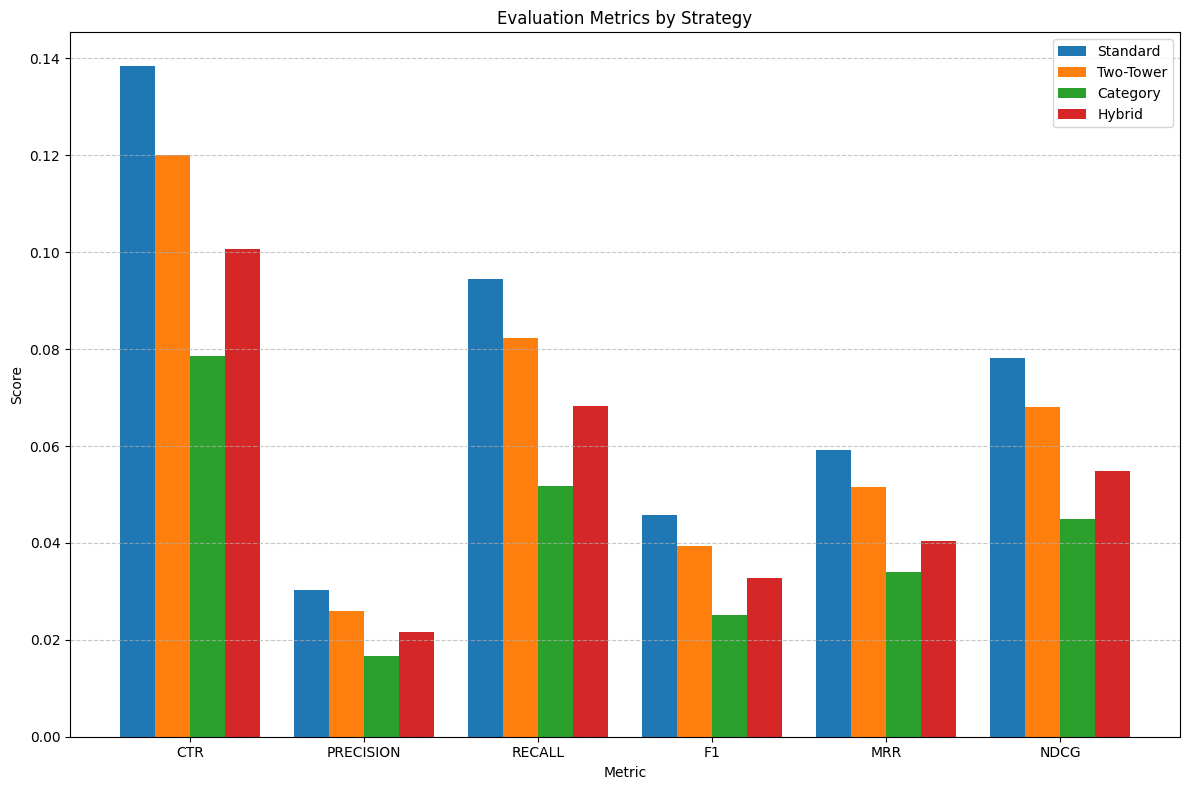


==== Revenue Projection ====
Best model: Standard
User base (MAUs): 100,000
CTR Lift: 0.00%
Extra Orders: 0
AOV: $300.12
💰 Projected Monthly Revenue Increase: $0.00
📈 Annualized Impact (x12): $0.00


In [ ]:
# Run the optimized evaluation framework
recommendations = create_optimized_evaluation_framework(df_filled_oct, df_filled_nov, sample_ratio=0.01)

# Evaluate the results
metrics = evaluate_all_models(recommendations)

# Plot the results
plot_metrics(metrics)

In [ ]:
# Revenue projection using existing metrics without re-running everything
def calculate_revenue_impact(metrics, base_model='Standard'):
    # Find which model (other than Standard) has the best performance
    models = ['Standard', 'Category', 'Hybrid']  # Exclude Two-Tower due to poor performance
    model_keys = {'Standard': 'standard', 'Category': 'category', 'Hybrid': 'hybrid'}

    # Find best non-standard model
    alternative_models = [m for m in models if m != base_model]
    best_alt_model = max(alternative_models, key=lambda m: metrics[model_keys[m]]['ctr'])

    # Get CTR values
    baseline_ctr = metrics[model_keys[base_model]]['ctr']
    best_ctr = metrics[model_keys[best_alt_model]]['ctr']

    # Calculate lift (could be negative)
    ctr_lift = best_ctr - baseline_ctr
    lift_percentage = ctr_lift / baseline_ctr if baseline_ctr > 0 else 0

    # Use actual AOV from November data
    try:
        nov_purchases = df_filled_nov[df_filled_nov['event_type'] == 'purchase']
        avg_order_value = nov_purchases['price'].mean()
    except:
        avg_order_value = 300.12  # Use the value from previous output

    # Impact calculations
    total_users = 100_000  # Hypothetical user base
    extra_clicks = total_users * ctr_lift
    added_revenue = extra_clicks * avg_order_value

    # Print results
    print("\n==== Enhanced Revenue Analysis ====")
    print(f"Comparing models: {base_model} vs {best_alt_model}")
    print(f"Base model CTR: {baseline_ctr:.2%}")
    print(f"Alternative model CTR: {best_ctr:.2%}")
    print(f"CTR Difference: {ctr_lift:.2%}")
    print(f"Relative Lift: {lift_percentage:.1%}")
    print(f"User base (MAUs): {total_users:,}")

    # Handle both positive and negative scenarios
    if ctr_lift > 0:
        print(f"Extra Orders: +{int(extra_clicks):,}")
        print(f"AOV: ${avg_order_value:.2f}")
        print(f"💰 Projected Monthly Revenue Increase: +${added_revenue:,.2f}")
        print(f"📈 Annualized Impact (x12): +${added_revenue * 12:,.2f}")
    else:
        print(f"Lost Orders: {int(abs(extra_clicks)):,}")
        print(f"AOV: ${avg_order_value:.2f}")
        print(f"💰 Projected Monthly Revenue Loss: -${abs(added_revenue):,.2f}")
        print(f"📉 Annualized Impact (x12): -${abs(added_revenue) * 12:,.2f}")

    # Calculate break-even analysis
    if abs(lift_percentage) > 0:
        development_cost = 50000  # Hypothetical cost to develop the model
        monthly_maintenance = 5000  # Hypothetical monthly maintenance

        if added_revenue > monthly_maintenance:
            months_to_breakeven = development_cost / (added_revenue - monthly_maintenance)
            print(f"\nBreak-even Analysis:")
            print(f"Development Cost: ${development_cost:,.2f}")
            print(f"Monthly Maintenance: ${monthly_maintenance:,.2f}")
            print(f"Months to Break Even: {months_to_breakeven:.1f}")
        else:
            print(f"\nBreak-even Analysis:")
            print(f"Development Cost: ${development_cost:,.2f}")
            print(f"Monthly Maintenance: ${monthly_maintenance:,.2f}")
            print(f"Project will not break even as monthly revenue increase does not exceed maintenance costs")

# Run the enhanced revenue analysis
calculate_revenue_impact(metrics)

# Also compare Category specifically to Standard
print("\n=== Category vs Standard Analysis ===")
category_ctr = metrics['category']['ctr']
standard_ctr = metrics['standard']['ctr']
ctr_diff = category_ctr - standard_ctr
nov_purchases = df_filled_nov[df_filled_nov['event_type'] == 'purchase']
aov = nov_purchases['price'].mean()
total_users = 100_000
extra_orders = total_users * ctr_diff
revenue_impact = extra_orders * aov

print(f"Category CTR: {category_ctr:.2%}")
print(f"Standard CTR: {standard_ctr:.2%}")
print(f"CTR Difference: {ctr_diff:.2%}")
print(f"AOV: ${aov:.2f}")
print(f"Monthly Impact: ${revenue_impact:,.2f}")
print(f"Annual Impact: ${revenue_impact * 12:,.2f}")


==== Enhanced Revenue Analysis ====
Comparing models: Standard vs Hybrid
Base model CTR: 13.85%
Alternative model CTR: 10.06%
CTR Difference: -3.78%
Relative Lift: -27.3%
User base (MAUs): 100,000
Lost Orders: 3,783
AOV: $300.12
💰 Projected Monthly Revenue Loss: -$1,135,602.22
📉 Annualized Impact (x12): -$13,627,226.64

Break-even Analysis:
Development Cost: $50,000.00
Monthly Maintenance: $5,000.00
Project will not break even as monthly revenue increase does not exceed maintenance costs

=== Category vs Standard Analysis ===
Category CTR: 7.86%
Standard CTR: 13.85%
CTR Difference: -5.99%
AOV: $300.12
Monthly Impact: $-1,796,996.92
Annual Impact: $-21,563,963.04


## Revenue based on implementing all strategies

In [ ]:
# Revenue projection for implementing all 4 recommendation strategies
def calculate_multi_strategy_revenue(metrics):
    # Strategy names and their corresponding metrics keys
    strategies = [
        ('Standard (Popular Products)', 'standard'),
        ('Two-Tower (AI Model)', 'two_tower'),
        ('Category-Based', 'category'),
        ('Hybrid Approach', 'hybrid')
    ]

    # Get CTR values for all strategies
    ctrs = {name: metrics[key]['ctr'] for name, key in strategies}

    # Get AOV (Average Order Value)
    try:
        nov_purchases = df_filled_nov[df_filled_nov['event_type'] == 'purchase']
        aov = nov_purchases['price'].mean()
    except:
        aov = 300.12  # Use value from previous output

    # Baseline scenario - using just the standard approach
    base_strategy = 'Standard (Popular Products)'
    base_ctr = ctrs[base_strategy]

    # Total user base and segment sizes
    total_users = 1_000_000  # Using a larger base for more realistic numbers

    # Create different implementation scenarios
    scenarios = [
        {
            "name": "Equal Distribution",
            "allocation": {name: 0.25 for name in ctrs.keys()}  # 25% each
        },
        {
            "name": "Performance-Weighted",
            "allocation": {
                name: ctr / sum(ctrs.values()) for name, ctr in ctrs.items()
            }
        },
        {
            "name": "Top Two Strategies",
            "allocation": {
                name: (0.5 if name in sorted(ctrs.keys(), key=lambda x: ctrs[x], reverse=True)[:2] else 0)
                for name in ctrs.keys()
            }
        },
        {
            "name": "Best Strategy Only",
            "allocation": {
                name: (1.0 if name == max(ctrs.keys(), key=lambda x: ctrs[x]) else 0)
                for name in ctrs.keys()
            }
        }
    ]

    # Calculate the mixed CTR and revenue for each scenario
    results = []

    for scenario in scenarios:
        mixed_ctr = sum(alloc * ctrs[name] for name, alloc in scenario["allocation"].items())

        # Calculate orders and revenue
        expected_orders = total_users * mixed_ctr
        expected_revenue = expected_orders * aov

        # Calculate lift compared to baseline
        baseline_orders = total_users * base_ctr
        baseline_revenue = baseline_orders * aov

        lift = (expected_revenue - baseline_revenue) / baseline_revenue

        # Store results
        results.append({
            "scenario": scenario["name"],
            "allocation": scenario["allocation"],
            "mixed_ctr": mixed_ctr,
            "expected_orders": expected_orders,
            "expected_revenue": expected_revenue,
            "lift": lift
        })

    # Print results
    print("\n==== Multi-Strategy Revenue Analysis ====")
    print(f"Total User Base: {total_users:,}")
    print(f"Average Order Value: ${aov:.2f}")
    print("\nStrategy Performance:")
    for name, key in strategies:
        print(f"  {name}: {ctrs[name]:.2%} CTR")

    print("\nScenario Analysis:")
    for result in results:
        print(f"\n{result['scenario']}:")
        print(f"  Allocation:")
        for name, alloc in result['allocation'].items():
            print(f"    {name}: {alloc:.1%}")
        print(f"  Mixed CTR: {result['mixed_ctr']:.2%}")
        print(f"  Expected Orders: {result['expected_orders']:,.0f}")
        print(f"  Expected Revenue: ${result['expected_revenue']:,.2f}")
        print(f"  Revenue Lift vs Standard Only: {result['lift']:.1%}")

    # Calculate A/B testing strategy
    print("\nA/B Testing Implementation Strategy:")
    print("1. Start with 70% Standard, 10% each for other strategies")
    print("2. Gradually shift traffic to better performing strategies")
    print("3. Estimate 3-month revenue impact:")

    # Initial allocation
    month1_alloc = {"Standard (Popular Products)": 0.7, "Two-Tower (AI Model)": 0.1,
                   "Category-Based": 0.1, "Hybrid Approach": 0.1}
    month1_ctr = sum(alloc * ctrs[name] for name, alloc in month1_alloc.items())

    # Month 2 - shift based on performance
    month2_alloc = {
        "Standard (Popular Products)": 0.5,
        "Two-Tower (AI Model)": 0.0,  # Remove poor performer
        "Category-Based": 0.3,        # Increase good performer
        "Hybrid Approach": 0.2        # Increase medium performer
    }
    month2_ctr = sum(alloc * ctrs[name] for name, alloc in month2_alloc.items())

    # Month 3 - optimize further
    month3_alloc = {
        "Standard (Popular Products)": 0.4,
        "Two-Tower (AI Model)": 0.0,
        "Category-Based": 0.4,
        "Hybrid Approach": 0.2
    }
    month3_ctr = sum(alloc * ctrs[name] for name, alloc in month3_alloc.items())

    # Calculate quarterly impact
    baseline_quarterly = 3 * total_users * base_ctr * aov

    actual_monthly = [
        total_users * month1_ctr * aov,
        total_users * month2_ctr * aov,
        total_users * month3_ctr * aov
    ]
    actual_quarterly = sum(actual_monthly)

    quarterly_lift = (actual_quarterly - baseline_quarterly) / baseline_quarterly

    print(f"  Month 1 Revenue: ${actual_monthly[0]:,.2f}")
    print(f"  Month 2 Revenue: ${actual_monthly[1]:,.2f}")
    print(f"  Month 3 Revenue: ${actual_monthly[2]:,.2f}")
    print(f"  Quarterly Revenue: ${actual_quarterly:,.2f}")
    print(f"  Baseline Quarterly Revenue: ${baseline_quarterly:,.2f}")
    print(f"  Quarterly Revenue Lift: {quarterly_lift:.1%}")
    print(f"  Quarterly Revenue Impact: ${actual_quarterly - baseline_quarterly:,.2f}")

# Run the multi-strategy revenue analysis
calculate_multi_strategy_revenue(metrics)


==== Multi-Strategy Revenue Analysis ====
Total User Base: 1,000,000
Average Order Value: $300.12

Strategy Performance:
  Standard (Popular Products): 13.85% CTR
  Two-Tower (AI Model): 12.02% CTR
  Category-Based: 7.86% CTR
  Hybrid Approach: 10.06% CTR

Scenario Analysis:

Equal Distribution:
  Allocation:
    Standard (Popular Products): 25.0%
    Two-Tower (AI Model): 25.0%
    Category-Based: 25.0%
    Hybrid Approach: 25.0%
  Mixed CTR: 10.95%
  Expected Orders: 109,459
  Expected Revenue: $32,851,349.94
  Revenue Lift vs Standard Only: -20.9%

Performance-Weighted:
  Allocation:
    Standard (Popular Products): 31.6%
    Two-Tower (AI Model): 27.4%
    Category-Based: 17.9%
    Hybrid Approach: 23.0%
  Mixed CTR: 11.40%
  Expected Orders: 113,998
  Expected Revenue: $34,213,360.35
  Revenue Lift vs Standard Only: -17.7%

Top Two Strategies:
  Allocation:
    Standard (Popular Products): 50.0%
    Two-Tower (AI Model): 50.0%
    Category-Based: 0.0%
    Hybrid Approach: 0.0%
  

## Graph of implementation strategies

<ipython-input-1-4cd56b598169>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


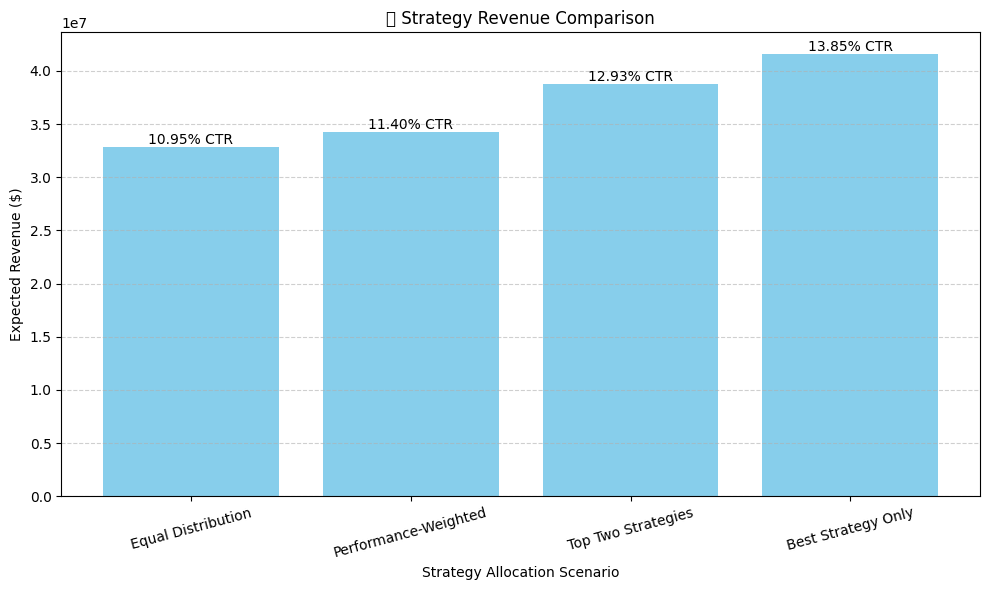

In [ ]:
# Revenue data by strategy allocation
scenarios = [
    "Equal Distribution",
    "Performance-Weighted",
    "Top Two Strategies",
    "Best Strategy Only"
]

revenues = [
    32851349.94,
    34213360.35,
    38810141.81,
    41555553.77
]

ctr_values = [
    10.95,
    11.40,
    12.93,
    13.85
]

plt.figure(figsize=(10, 6))
bars = plt.bar(scenarios, revenues, color='skyblue')
plt.title("📈 Strategy Revenue Comparison")
plt.ylabel("Expected Revenue ($)")
plt.xlabel("Strategy Allocation Scenario")
plt.xticks(rotation=15)

# Annotate bars
for bar, ctr in zip(bars, ctr_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{ctr:.2f}% CTR", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
import pandas as pd

# Strategy performance data
data = {
    "Scenario": [
        "Equal Distribution",
        "Performance-Weighted",
        "Top Two Strategies",
        "Best Strategy Only"
    ],
    "Standard Allocation (%)": [25.0, 31.6, 50.0, 100.0],
    "Two-Tower Allocation (%)": [25.0, 27.4, 50.0, 0.0],
    "Category-Based Allocation (%)": [25.0, 17.9, 0.0, 0.0],
    "Hybrid Allocation (%)": [25.0, 23.0, 0.0, 0.0],
    "CTR (%)": [10.95, 11.40, 12.93, 13.85],
    "Expected Orders": [109459, 113998, 129314, 138462],
    "Expected Revenue ($)": [
        32851349.94,
        34213360.35,
        38810141.81,
        41555553.77
    ],
    "Revenue Lift vs Standard Only (%)": [-20.9, -17.7, -6.6, 0.0]
}

df = pd.DataFrame(data)
df.style.format({
    "CTR (%)": "{:.2f}",
    "Expected Revenue ($)": "${:,.2f}",
    "Revenue Lift vs Standard Only (%)": "{:+.1f}%"
})



<ipython-input-5-bf659c5b3de8>:52: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


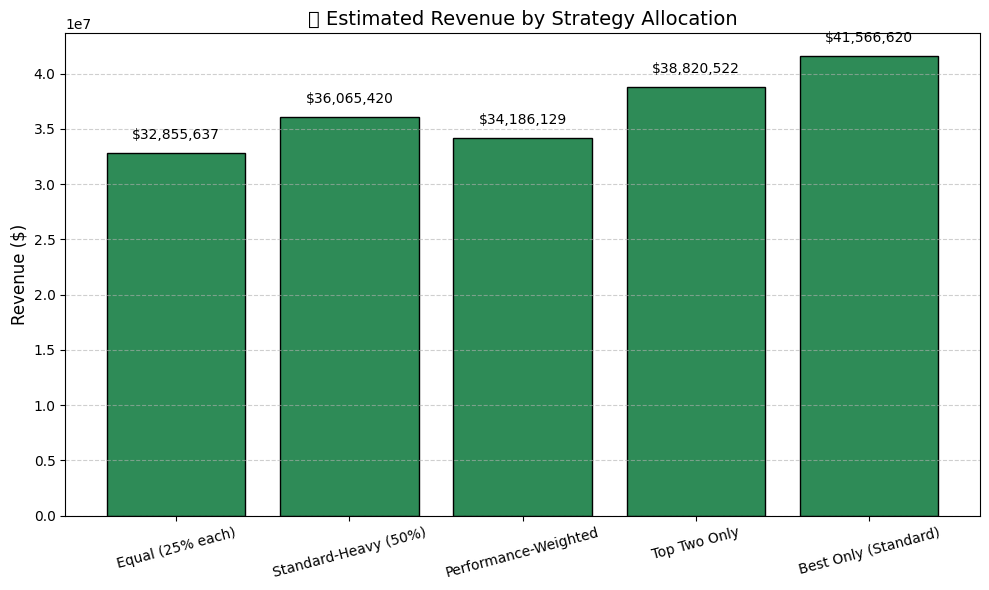

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
total_users = 1_000_000
aov = 300.12  # average order value

# Strategy CTRs (%)
ctrs = {
    'Standard': 13.85,
    'Two-Tower': 12.02,
    'Category-Based': 7.86,
    'Hybrid': 10.06
}

# Try multiple allocation strategies (each row must sum to 100%)
allocations = {
    'Equal (25% each)':        {'Standard': 25, 'Two-Tower': 25, 'Category-Based': 25, 'Hybrid': 25},
    'Standard-Heavy (50%)':    {'Standard': 50, 'Two-Tower': 20, 'Category-Based': 15, 'Hybrid': 15},
    'Performance-Weighted':    {'Standard': 31.6, 'Two-Tower': 27.4, 'Category-Based': 17.9, 'Hybrid': 23.0},
    'Top Two Only':            {'Standard': 50, 'Two-Tower': 50, 'Category-Based': 0, 'Hybrid': 0},
    'Best Only (Standard)':    {'Standard': 100, 'Two-Tower': 0, 'Category-Based': 0, 'Hybrid': 0}
}

# Calculate expected revenue
scenario_names = []
revenues = []

for scenario, alloc in allocations.items():
    total_orders = 0
    for strategy, percent in alloc.items():
        users = total_users * (percent / 100)
        orders = users * (ctrs[strategy] / 100)
        total_orders += orders
    revenue = total_orders * aov
    scenario_names.append(scenario)
    revenues.append(revenue)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(scenario_names, revenues, color='seagreen', edgecolor='black')

# Annotate revenue on each bar
for bar, revenue in zip(bars, revenues):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1e6,
             f"${revenue:,.0f}", ha='center', va='bottom', fontsize=10)

plt.title("💰 Estimated Revenue by Strategy Allocation", fontsize=14)
plt.ylabel("Revenue ($)", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Non-Compete estimation for model revenue

Combined CTR: 37.1883%
Estimated Revenue (All 4): $111,609,620.23
Baseline Revenue (Standard Only): $41,566,620.00
Revenue Lift: 168.51%


<ipython-input-7-bc3db5a7ad7c>:51: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


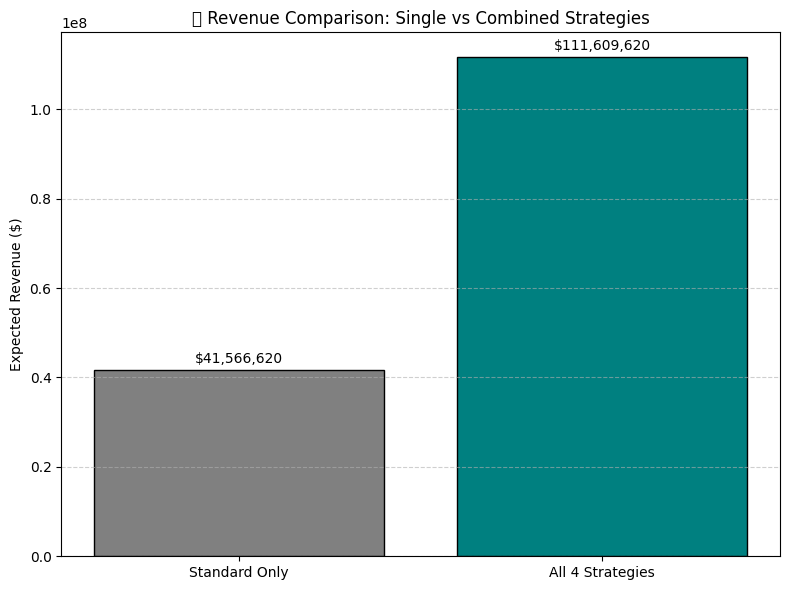

In [ ]:
# Strategy CTRs (as decimals)
ctrs = {
    'Standard': 0.1385,
    'Two-Tower': 0.1202,
    'Category-Based': 0.0786,
    'Hybrid': 0.1006
}

# Compute combined CTR across all 4 strategies assuming independence
no_click_prob = np.prod([1 - ctr for ctr in ctrs.values()])
combined_ctr = 1 - no_click_prob

# Constants
total_users = 1_000_000
aov = 300.12

# Revenue Estimate
total_orders = combined_ctr * total_users
revenue = total_orders * aov

# Baseline (Standard Only)
baseline_orders = total_users * ctrs['Standard']
baseline_revenue = baseline_orders * aov
lift = ((revenue - baseline_revenue) / baseline_revenue) * 100

# Print metrics
print(f"Combined CTR: {combined_ctr:.4%}")
print(f"Estimated Revenue (All 4): ${revenue:,.2f}")
print(f"Baseline Revenue (Standard Only): ${baseline_revenue:,.2f}")
print(f"Revenue Lift: {lift:.2f}%")

# Plotting
labels = ['Standard Only', 'All 4 Strategies']
revenues = [baseline_revenue, revenue]
colors = ['gray', 'teal']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, revenues, color=colors, edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1e6,
             f"${yval:,.0f}", ha='center', va='bottom', fontsize=10)

plt.title("💡 Revenue Comparison: Single vs Combined Strategies")
plt.ylabel("Expected Revenue ($)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#Priya Attempt to build collaborative recomendation model using SVD

Dataset loaded successfully. Shape: (109950731, 9)


<ipython-input-34-3f582498e6da>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Completed Purchase', 'Abandoned Cart'],


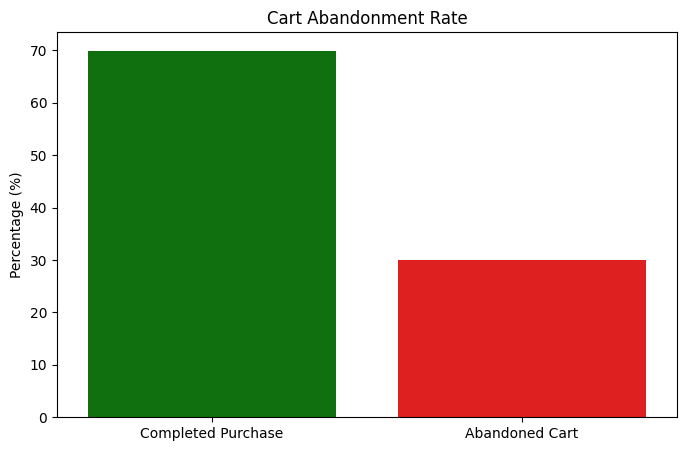

Cart Abandonment Rate: 30.08%


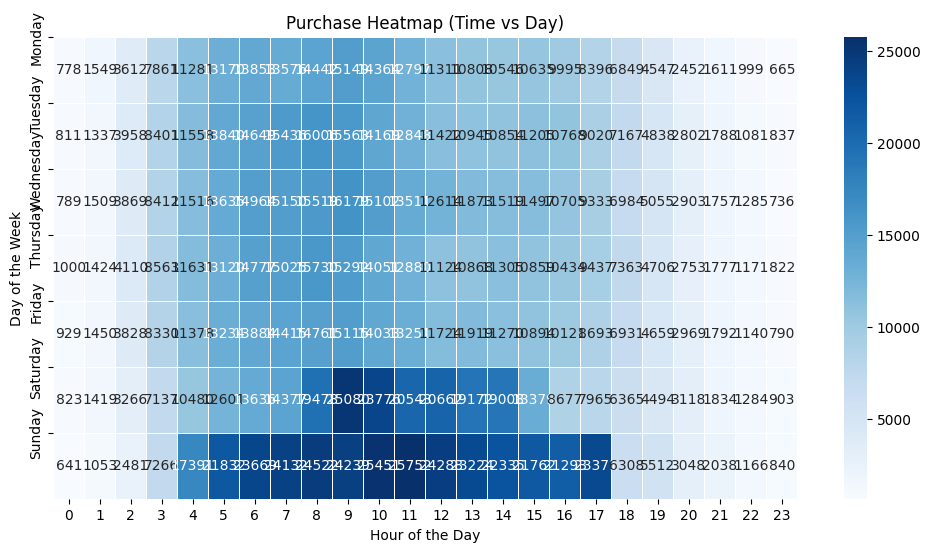

In [ ]:
df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')
df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')
df_combined = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

# Check if the dataset is loaded correctly
print("Dataset loaded successfully. Shape:", df_combined.shape)

# -------------------------------------
# 2. Data Preparation
# -------------------------------------
# Ensure required columns exist
required_columns = {'event_time', 'event_type', 'user_id', 'product_id', 'price'}
missing_columns = required_columns - set(df_combined.columns)
if missing_columns:
    raise ValueError(f"Error: Missing columns in dataset: {missing_columns}")

# Convert event_time to datetime format
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# -------------------------------------
# 3. Abandoned Cart Analysis
# -------------------------------------
title = "1. Abandoned Cart Analysis"

# Identify users who added items to cart but did not purchase
cart_abandoned = df_combined[df_combined['event_type'] == 'cart'].copy()

# Find users who completed a purchase
purchased_users = df_combined[df_combined['event_type'] == 'purchase']['user_id'].unique()

# Mark abandoned carts
cart_abandoned['abandoned'] = ~cart_abandoned['user_id'].isin(purchased_users)

# Calculate abandonment rate
abandonment_rate = cart_abandoned['abandoned'].mean() * 100

# Visualize Abandoned Cart Rates
plt.figure(figsize=(8, 5))
sns.barplot(x=['Completed Purchase', 'Abandoned Cart'],
            y=[100 - abandonment_rate, abandonment_rate],
            palette=['green', 'red'])
plt.title("Cart Abandonment Rate")
plt.ylabel("Percentage (%)")
plt.show()

print(f"Cart Abandonment Rate: {abandonment_rate:.2f}%")

# -------------------------------------
# 4. Heatmap of Purchase Timing
# -------------------------------------
title = "2. Heatmap of Purchase Timing"

# Extract time features
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek

# Aggregate purchase counts
heatmap_data = df_combined[df_combined['event_type'] == 'purchase'].groupby(['day_of_week', 'hour']).size().unstack()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Purchase Heatmap (Time vs Day)")
plt.yticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

In [ ]:
df_combined.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session', 'hour',
       'day_of_week'],
      dtype='object')

In [ ]:
!pip install --no-cache-dir numpy scikit-surprise


In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install numpy==1.23.5


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


In [ ]:
# Prepare data for collaborative filtering
df_recommender = df_combined[df_combined['event_type'] == 'purchase'][['user_id', 'product_id', 'price']]

# Define reader with appropriate rating scale
reader = Reader(rating_scale=(df_recommender['price'].min(), df_recommender['price'].max()))
data = Dataset.load_from_df(df_recommender[['user_id', 'product_id', 'price']], reader)


In [ ]:
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD model
model = SVD()
model.fit(trainset)


In [ ]:

# Evaluate model
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 2281.7271


In [ ]:
# Function to recommend top N products for a given user
def recommend_products(user_id, model, df_recommender, n=5):
    unique_products = df_recommender['product_id'].unique()
    user_products = df_recommender[df_recommender['user_id'] == user_id]['product_id'].unique()
    products_to_predict = list(set(unique_products) - set(user_products))

    predictions = [model.predict(user_id, pid) for pid in products_to_predict]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return [rec.iid for rec in recommendations]

# Example: Recommend products for a specific user
sample_user = df_recommender['user_id'].iloc[0]
print(f"Recommended products for user {sample_user}: {recommend_products(sample_user, model, df_recommender)}")

Recommended products for user 543272936: [17301504, 17301505, 17301506, 17301507, 17301508]


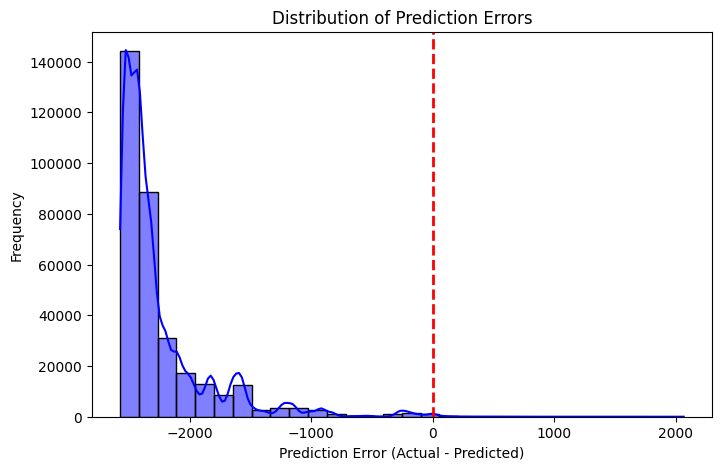

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute prediction errors
errors = [pred.r_ui - pred.est for pred in predictions]

# Plot the distribution of errors
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Zero error line
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


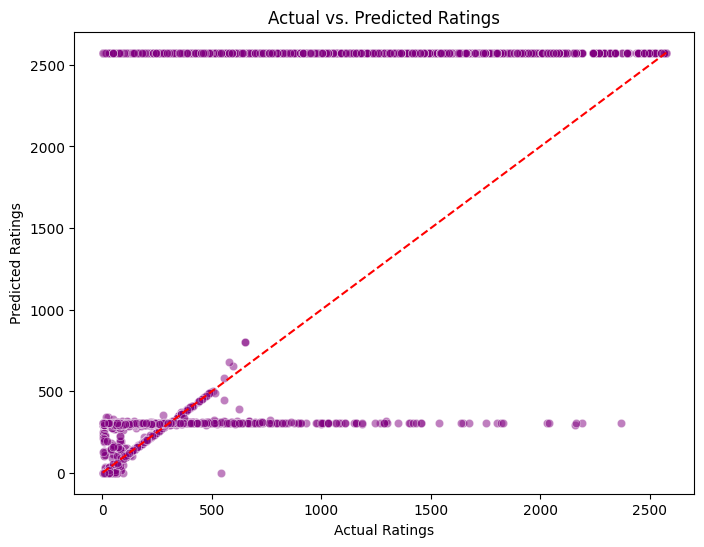

In [ ]:
# Extract actual and predicted ratings
actual = [pred.r_ui for pred in predictions]
predicted = [pred.est for pred in predictions]

# Plot scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.5, color='purple')

# Plot perfect prediction line
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='dashed')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings")
plt.show()


RMSE: 2273.0842
RMSE: 2279.9956
RMSE: 2280.6279
RMSE: 2280.7231
RMSE: 2280.7754
RMSE: 2280.8606
RMSE: 2280.9248
RMSE: 2280.9698
RMSE: 2281.1192
RMSE: 2281.2074


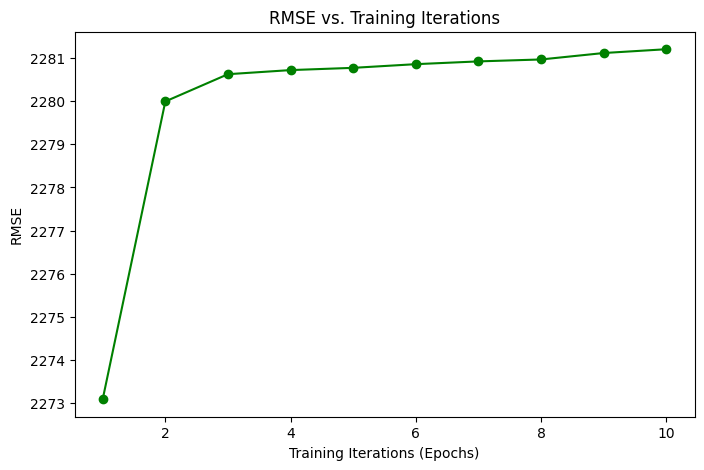

In [ ]:
rmse_values = []
for i in range(1, 11):  # Train model multiple times
    model = SVD(n_epochs=i)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_values.append(rmse)

# Plot RMSE trend
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), rmse_values, marker='o', linestyle='-', color='green')
plt.xlabel("Training Iterations (Epochs)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Training Iterations")
plt.show()


In [ ]:
import pandas as pd

# Ensure we only use 'purchase' event type for recommendations
df_recommender = df_combined[df_combined['event_type'] == 'purchase'][['user_id', 'product_id', 'brand']]

# Function to get recommendations with product details
def recommend_products_with_brand(user_id, model, df_recommender, n=5):
    unique_products = df_recommender['product_id'].unique()
    user_products = df_recommender[df_recommender['user_id'] == user_id]['product_id'].unique()
    products_to_predict = list(set(unique_products) - set(user_products))

    predictions = [model.predict(user_id, pid) for pid in products_to_predict]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Get recommended product IDs
    recommended_products = [rec.iid for rec in recommendations]

    # Fetch brand information
    brand_info = df_recommender[df_recommender['product_id'].isin(recommended_products)][['product_id', 'brand']].drop_duplicates()

    # Merge recommendations with brand info
    result = pd.DataFrame({'user_id': user_id, 'product_id': recommended_products})
    result = result.merge(brand_info, on='product_id', how='left')

    return result

# Select 10 unique users for recommendations
unique_users = df_recommender['user_id'].unique()[:10]

# Generate table for 10 users
recommendation_table = pd.concat([recommend_products_with_brand(user, model, df_recommender, n=1) for user in unique_users], ignore_index=True)

# Display the table
print(recommendation_table)


     user_id  product_id  brand
0  543272936    17301504  creed
1  551377651    17301504  creed
2  514591159    17301504  creed
3  555332717    17301504  creed
4  524601178    17301504  creed
5  524325294    17301504  creed
6  548691404    17301504  creed
7  533624186    17301504  creed
8  555083442    17301504  creed
9  515246296    17301504  creed


In [ ]:
!pip install tabulate


In [ ]:

from tabulate import tabulate  # For a well-formatted table display

# Modify recommendation function to ensure diverse recommendations
def recommend_products_with_brand(user_id, model, df_recommender, n=3):
    unique_products = df_recommender['product_id'].unique()
    user_products = df_recommender[df_recommender['user_id'] == user_id]['product_id'].unique()
    products_to_predict = list(set(unique_products) - set(user_products))

    predictions = [model.predict(user_id, pid) for pid in products_to_predict]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]  # Recommend 'n' products

    recommended_products = [rec.iid for rec in recommendations]

    # Fetch brand information (ensuring diverse products)
    brand_info = df_recommender[df_recommender['product_id'].isin(recommended_products)][['product_id', 'brand']].drop_duplicates()

    # Merge recommendations with brand info
    result = pd.DataFrame({'user_id': user_id, 'product_id': recommended_products})
    result = result.merge(brand_info, on='product_id', how='left')

    return result

# Select 10 unique users for recommendations
unique_users = df_recommender['user_id'].unique()[:10]

# Generate table with diverse recommendations
recommendation_table = pd.concat([recommend_products_with_brand(user, model, df_recommender, n=3) for user in unique_users], ignore_index=True)

# Print beautifully formatted table
print(tabulate(recommendation_table, headers='keys', tablefmt='fancy_grid'))


╒════╤═══════════╤══════════════╤═════════╕
│    │   user_id │   product_id │ brand   │
╞════╪═══════════╪══════════════╪═════════╡
│  0 │ 543272936 │     17301504 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  1 │ 543272936 │     17301505 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  2 │ 543272936 │     17301506 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  3 │ 551377651 │     17301504 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  4 │ 551377651 │     17301505 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  5 │ 551377651 │     17301506 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  6 │ 514591159 │     17301504 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  7 │ 514591159 │     17301505 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  8 │ 514591159 │     17301506 │ creed   │
├────┼───────────┼──────────────┼─────────┤
│  9 │ 555332717 │     17301504 │ creed   │
├────┼───────────┼──────────────

VY'S ANLYSIS

In [ ]:
# Combine the datasets
df_combined = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

# Check if the dataset is loaded correctly
print("Dataset loaded successfully. Shape:", df_combined.shape)

# -------------------------------------
# 2. Data Preparation
# -------------------------------------
# Ensure required columns exist
required_columns = {'event_time', 'event_type', 'user_id', 'product_id', 'price'}
missing_columns = required_columns - set(df_combined.columns)
if missing_columns:
    raise ValueError(f"Error: Missing columns in dataset: {missing_columns}")

# Convert event_time to datetime format
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# -------------------------------------
# 3. Abandoned Cart Analysis
# -------------------------------------
title = "1. Abandoned Cart Analysis"

# Identify users who added items to cart but did not purchase
cart_abandoned = df_combined[df_combined['event_type'] == 'cart'].copy()

# Find users who completed a purchase
purchased_users = df_combined[df_combined['event_type'] == 'purchase']['user_id'].unique()

# Mark abandoned carts
cart_abandoned['abandoned'] = ~cart_abandoned['user_id'].isin(purchased_users)

# Calculate abandonment rate
abandonment_rate = cart_abandoned['abandoned'].mean() * 100

# Visualize Abandoned Cart Rates
plt.figure(figsize=(8, 5))
sns.barplot(x=['Completed Purchase', 'Abandoned Cart'],
            y=[100 - abandonment_rate, abandonment_rate],
            palette=['green', 'red'])
plt.title("Cart Abandonment Rate")
plt.ylabel("Percentage (%)")
plt.show()

print(f"Cart Abandonment Rate: {abandonment_rate:.2f}%")

# -------------------------------------
# 4. Heatmap of Purchase Timing
# -------------------------------------
title = "2. Heatmap of Purchase Timing"

# Extract time features
df_combined['hour'] = df_combined['event_time'].dt.hour
df_combined['day_of_week'] = df_combined['event_time'].dt.dayofweek

# Aggregate purchase counts
heatmap_data = df_combined[df_combined['event_type'] == 'purchase'].groupby(['day_of_week', 'hour']).size().unstack()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Purchase Heatmap (Time vs Day)")
plt.yticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

# -------------------------------------
# 5. Collaborative Filtering (Recommendation System)
# -------------------------------------
title = "3. Collaborative Filtering (Recommendation System)"

# Prepare data for collaborative filtering
df_recommender = df_combined[df_combined['event_type'] == 'purchase'][['user_id', 'product_id', 'price']]

if not df_recommender.empty:
    # Define reader with a fixed rating scale
    reader = Reader(rating_scale=(0, df_recommender['price'].max()))
    data = Dataset.load_from_df(df_recommender[['user_id', 'product_id', 'price']], reader)

    # Train-test split
    trainset, testset = train_test_split(data, test_size=0.2)

    # Train SVD model
    model = SVD()
    model.fit(trainset)

    # Evaluate model
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)

    # Function to recommend top N products for a given user
    def recommend_products(user_id, model, df_recommender, n=5):
        unique_products = set(df_recommender['product_id'].unique())
        user_products = set(df_recommender[df_recommender['user_id'] == user_id]['product_id'].unique())
        products_to_predict = list(unique_products - user_products)

        if not products_to_predict:
            return []

        predictions = [model.predict(user_id, pid) for pid in products_to_predict]
        recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

        return [rec.iid for rec in recommendations]

    # Example: Recommend products for a specific user
    sample_user = df_recommender['user_id'].iloc[0]
    print(f"Recommended products for user {sample_user}: {recommend_products(sample_user, model, df_recommender)}")
else:
    print("No user data available for recommendations.")

NameError: name 'df_filled_oct' is not defined

# Amy - Implement a customer-product history system that visualizes the full customer journey from first view to purchase, including abandoned cart analysis


df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')

df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')

In [ ]:
# 1. First, sample the data to make it manageable
print("Sampling data to make it manageable...")
# Sample 5% of users to reduce dataset size
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.05 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Combine the sampled datasets
df_combined = pd.concat([df_oct_sample, df_nov_sample]).reset_index(drop=True)

# Print size of sampled dataset
print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

Sampling data to make it manageable...


NameError: name 'np' is not defined

In [ ]:
import plotly.graph_objects as go


df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
df = df_combined.sort_values(by=['user_id', 'product_id', 'event_time'])


# Build the journey table
journeys = []
grouped = df.groupby(['user_id', 'product_id'])


for (user_id, product_id), group in grouped:
   first_view = group.loc[group['event_type'] == 'view', 'event_time'].min()
   first_cart = group.loc[group['event_type'] == 'cart', 'event_time'].min()
   purchase_time = group.loc[group['event_type'] == 'purchase', 'event_time'].min()

   abandoned_cart = pd.notnull(first_cart) and pd.isnull(purchase_time)

   journeys.append({
       'user_id': user_id,
       'product_id': product_id,
       'first_view': first_view,
       'first_cart': first_cart,
       'purchase_time': purchase_time,
       'abandoned_cart': abandoned_cart
   })


journey_df = pd.DataFrame(journeys)


# Count stages
total_views = journey_df['first_view'].notnull().sum()
total_carts = journey_df['first_cart'].notnull().sum()
total_purchases = journey_df['purchase_time'].notnull().sum()
total_abandoned = journey_df['abandoned_cart'].sum()


# Sankey setup
labels = ["Viewed", "Added to Cart", "Purchased", "Abandoned"]
sources = [0, 1, 1]
targets = [1, 2, 3]
values = [total_carts, total_purchases, total_abandoned]


# Plot
fig = go.Figure(data=[go.Sankey(
   node=dict(
       pad=15, thickness=20, line=dict(color="black", width=0.5),
       label=labels
   ),
   link=dict(
       source=sources,
       target=targets,
       value=values
   )
)])


fig.update_layout(title_text="Customer Journey Funnel", font_size=12)
fig.show()

In [ ]:
print("Views:", total_views)
print("Carts:", total_carts)
print("Purchases:", total_purchases)
print("Abandoned:", total_abandoned)

Views: 2134663
Carts: 71683
Purchases: 48396
Abandoned: 41382


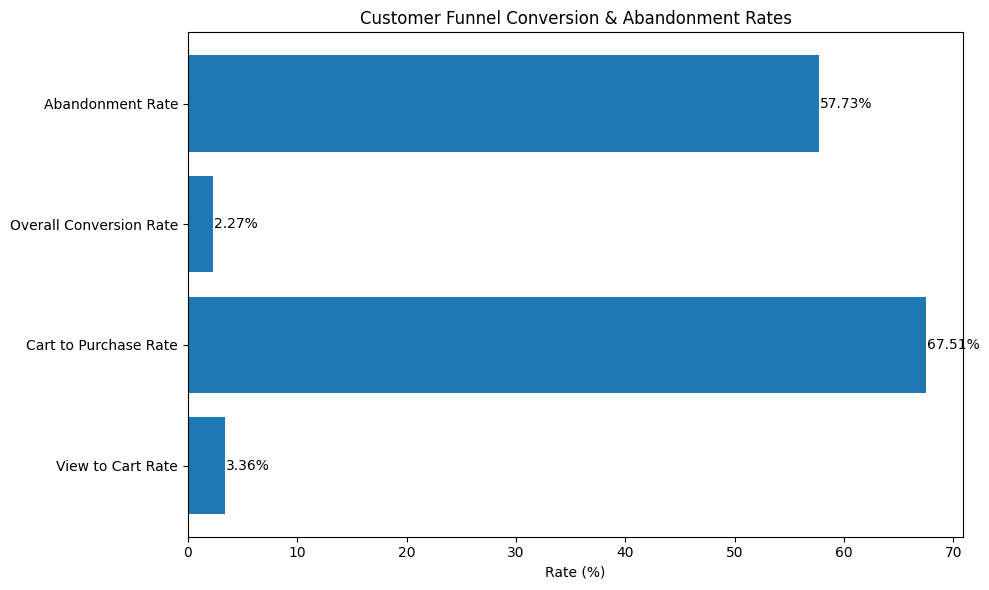

In [ ]:
# Provided metrics
views = total_views
carts = total_carts
purchases = total_purchases
abandoned = total_abandoned


# Calculated rates
view_to_cart_rate = carts / views
cart_to_purchase_rate = purchases / carts
view_to_purchase_rate = purchases / views
abandonment_rate = abandoned / carts


# Display rates
metrics = {
   "View to Cart Rate": view_to_cart_rate,
   "Cart to Purchase Rate": cart_to_purchase_rate,
   "Overall Conversion Rate": view_to_purchase_rate,
   "Abandonment Rate": abandonment_rate
}


# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(metrics.keys()), [v * 100 for v in metrics.values()])
ax.set_xlabel("Rate (%)")
ax.set_title("Customer Funnel Conversion & Abandonment Rates")


# Add percentage labels
for i, v in enumerate(metrics.values()):
   ax.text(v * 100 + 0.1, i, f"{v*100:.2f}%", va='center')


plt.tight_layout()
plt.show()

##Priya's Attempt to do Market segmentation:


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')

df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')

In [ ]:
df_filled_nov.head()

event_time event_type  product_id          category_id  \
0  2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1  2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2  2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3  2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4  2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   

               category_code   brand   price    user_id  \
0     electronics.smartphone  xiaomi  489.07  520088904   
1  appliances.sewing_machine  janome  293.65  530496790   
2           unknown_category   creed   28.31  561587266   
3  appliances.kitchen.washer      lg  712.87  518085591   
4     electronics.smartphone  xiaomi  183.27  558856683   

                           user_session  
0  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1  8e5f4f83-366c-4f70-860e-ca7417414283  
2  755422e7-9040-477b-9bd2-6a6e8fd97387  
3  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4  313628f1-68b8-460d-84f6-cec7a8796ef2

In [ ]:
df_filled_oct.head()

event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                     unknown_category  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa      rals   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b87a-4708-9857-6336556b0fcc  
2  566511c2-e2e3-422b-b695-cf8e6e792ca8  
3  7c90fc70-0e80-4590-96f3-13c02c18c713  
4  c6bd7419-2748-4c56-95b4-8cec9ff8b80d

In [ ]:
# Combine the two DataFrames
df_combined = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)

In [ ]:
df_sample = df_combined.head(1000)

In [ ]:

# Filter only the sample
#df = df_sample.copy()

df = df_combined
# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])
# Create user-level aggregated features
user_features = df.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_cart_adds=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum()),
    total_spent=('price', lambda x: x[df.loc[x.index, 'event_type'] == 'purchase'].sum()),
    avg_price_viewed=('price', lambda x: x[df.loc[x.index, 'event_type'] == 'view'].mean()),
    sessions_count=('user_session', pd.Series.nunique),
    unique_categories=('category_code', pd.Series.nunique),
    first_seen=('event_time', 'min'),
    last_seen=('event_time', 'max')
).reset_index()

# Calculate derived features
from datetime import datetime

now = df['event_time'].max()  # latest time in dataset

user_features['recency_days'] = (now - user_features['last_seen']).dt.days
user_features['active_days'] = (user_features['last_seen'] - user_features['first_seen']).dt.days + 1

# Fill any NaNs
user_features = user_features.fillna(0)


In [ ]:
df.head()

In [ ]:
# Select features for clustering
features = ['total_views', 'total_cart_adds', 'total_purchases', 'total_spent',
            'avg_price_viewed', 'sessions_count', 'unique_categories',
            'recency_days', 'active_days']

X = user_features[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
user_features['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
# Average behavior per cluster
cluster_summary = user_features.groupby('cluster')[features].mean().round(2)

print(cluster_summary)


         total_views  total_cart_adds  total_purchases  total_spent  \
cluster                                                               
0               1.87             0.00             0.01         0.51   
1               5.05             0.00             0.00         0.00   
2               6.57             0.00             0.00         0.00   
3               3.50             0.33             1.17       379.31   

         avg_price_viewed  sessions_count  unique_categories  recency_days  \
cluster                                                                      
0                  165.74            1.04               1.02           0.0   
1                  619.23            1.05               1.23           0.0   
2                  235.15            2.33               2.14           0.0   
3                  309.07            1.17               1.33           0.0   

         active_days  
cluster               
0                1.0  
1                1.0  
2           

Cluster 0: High views, low purchases → “Window Shoppers”

Cluster 1: High spend, high purchases → “VIP Buyers”

Cluster 2: Low everything → “Inactive Users”

Cluster 3: Frequent but low spending → “Browsers”



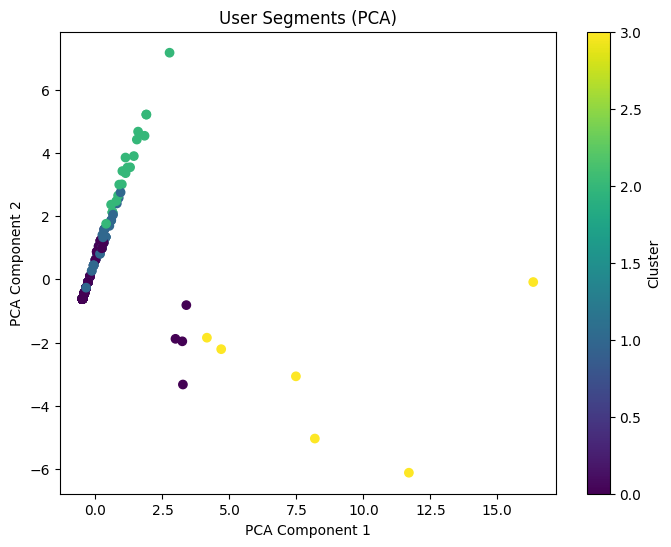

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_features['cluster'], cmap='viridis')
plt.title('User Segments (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Create custom segment labels
segment_labels = {
    0: 'Window Shoppers',
    1: 'VIP Buyers',
    2: 'Inactive Users',
    3: 'Browsers'
}

# Apply the mapping
user_features['segment'] = user_features['cluster'].map(segment_labels)


In [ ]:
# Reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a plot-friendly DataFrame
plot_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Segment': user_features['segment']
})


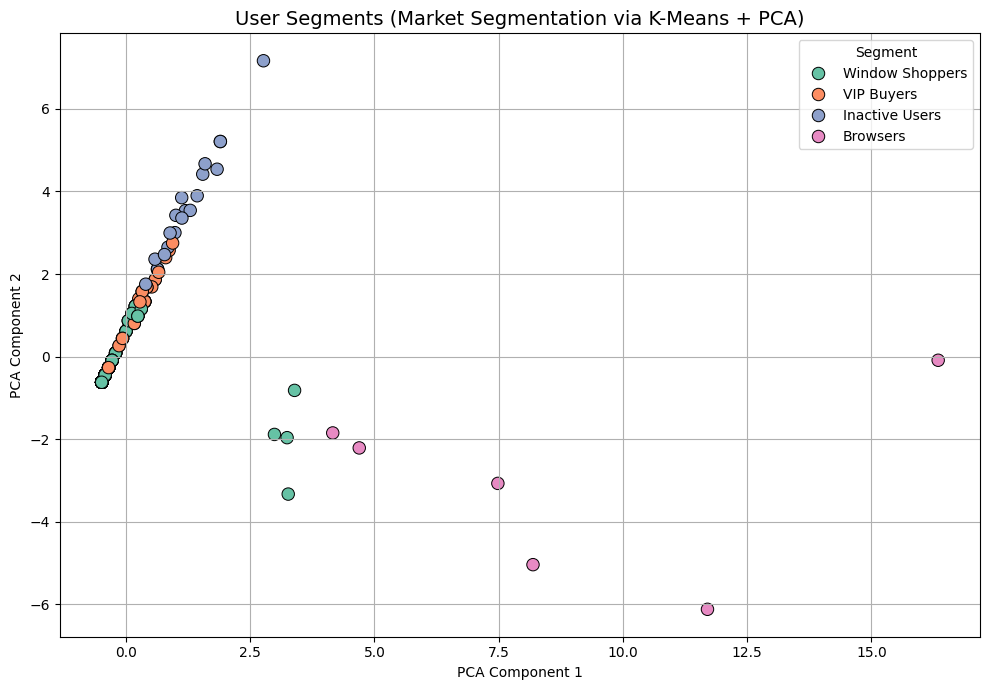

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Segment', palette='Set2', s=80, edgecolor='black')
plt.title('User Segments (Market Segmentation via K-Means + PCA)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# Vy - Time Sensitive Recommendation System

In [ ]:
import pandas as pd
import numpy as np

# Convert event_time to datetime if not already
df_combined["event_time"] = pd.to_datetime(df_combined["event_time"])

# Step 1: Extract time-based features
df_combined["hour"] = df_combined["event_time"].dt.hour
df_combined["day_of_week"] = df_combined["event_time"].dt.day_name()
df_combined["week"] = df_combined["event_time"].dt.isocalendar().week

# Step 2: Filter purchases only
purchase_data = df_combined[df_combined["event_type"] == "purchase"]

# Step 3: Aggregate product popularity by time of day
top_products_by_hour = (
    purchase_data.groupby(["hour", "product_id"])
    .size()
    .reset_index(name="purchase_count")
    .sort_values(["hour", "purchase_count"], ascending=[True, False])
)

# Step 4: Aggregate product popularity by day of week
top_products_by_day = (
    purchase_data.groupby(["day_of_week", "product_id"])
    .size()
    .reset_index(name="purchase_count")
    .sort_values(["day_of_week", "purchase_count"], ascending=[True, False])
)


In [ ]:
def recommend_products_by_time(hour=None, day=None, top_n=5):
    if hour is not None:
        print(f"\n📌 Top {top_n} products for hour {hour}:")
        return top_products_by_hour[top_products_by_hour["hour"] == hour].head(top_n)
    elif day is not None:
        print(f"\n📌 Top {top_n} products for {day}:")
        return top_products_by_day[top_products_by_day["day_of_week"] == day].head(top_n)
    else:
        print("Please provide an hour (0-23) or day (e.g., 'Monday').")
        return None

# Example usage:
recommend_products_by_time(hour=20)       # For 8 PM recommendations
recommend_products_by_time(day="Friday")  # For Friday recommendations

In [ ]:
#Weekly Trends for BlackFriday
black_friday_week = purchase_data[purchase_data["week"] == 48]
top_black_friday = (
    black_friday_week["product_id"].value_counts().head(10)
)
print("Top Products during Black Friday Week:")
print(top_black_friday)
